In [186]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic

pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]


In [187]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [188]:
def read_timesteps(simname):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(f'/home/akinshol/Data/Timescales/DataFiles/{simname}.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    

    data = pd.DataFrame(data)
    data['sim'] = simname
    return data

In [200]:
data = read_sat()

In [201]:
data.keys()

Index(['B-V', 'B_mag', 'G_inflow_0', 'G_inflow_1.5', 'G_inflow_2.5',
       'G_outflow_0', 'G_outflow_1.5', 'G_outflow_2.5', 'Gin_T', 'Gout_T',
       'HIgasfrac', 'I_mag', 'M_gas', 'M_star', 'R_mag', 'Rmax', 'Rvir', 'SFR',
       'U_mag', 'V90_Vdisp', 'V_mag', 'Xc', 'Yc', 'Zc', 'a', 'age', 'c', 'c_a',
       'fMhires', 'feh', 'g_temp', 'gasfrac', 'h1dist', 'haloid', 'hostDist',
       'hostHalo', 'hostVirialR', 'id2', 'mHI', 'mass', 'n_gas', 'n_particles',
       'n_star', 'ovdens', 'sSFR', 'sfh', 'sfhbins', 'tquench', 'zgas',
       'zstar', 'sim', 'g-r'],
      dtype='object')

In [202]:
dist, vir = distance_to_nearest_host(data)
q = data.sSFR < 1e-11
s = dist < 300
s = s[dist != 0]
q = q[dist != 0]
data = data[dist != 0]

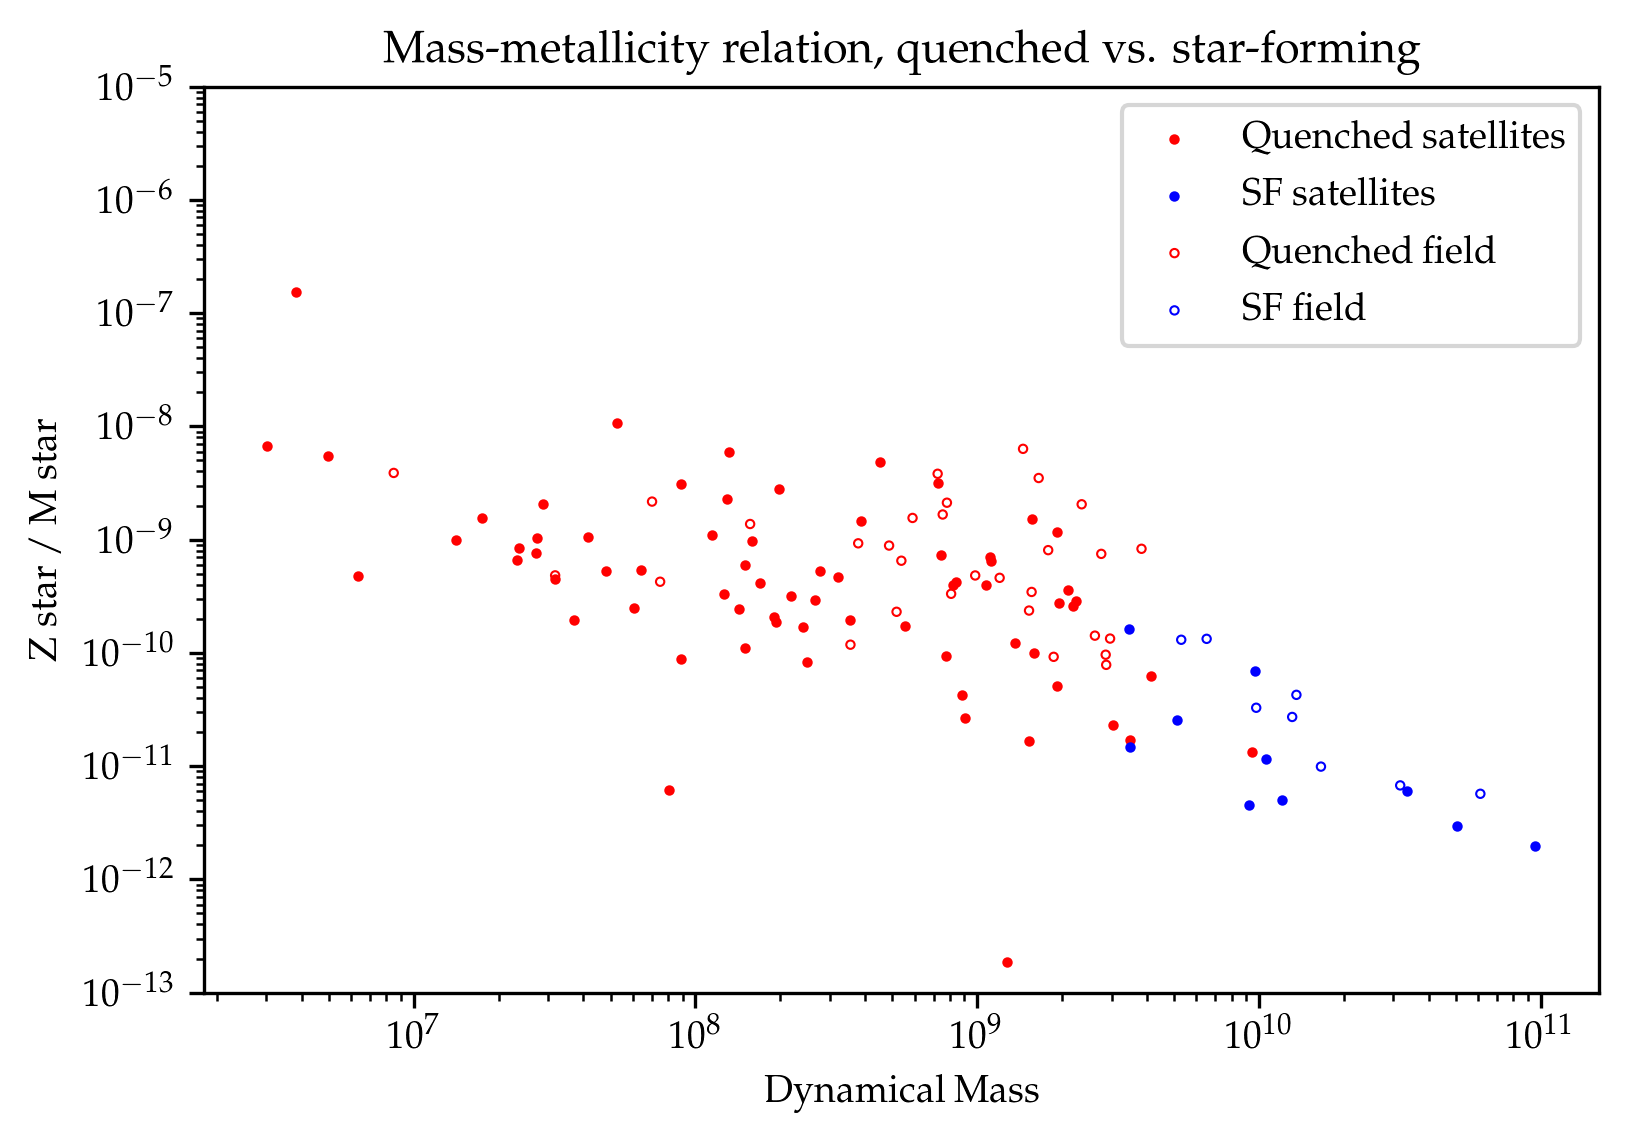

In [212]:
plt.figure(dpi=300)
plt.scatter(data.mass[q & s], data.zstar[q & s]/data.M_star[q & s], color='red', marker='o',label='Quenched satellites', s=4, linewidth=0.5)
plt.scatter(data.mass[~q & s], data.zstar[~q & s]/data.M_star[~q & s], color='blue', marker='o', label='SF satellites', s=4, linewidth=0.5)
plt.scatter(data.mass[q & ~s], data.zstar[q & ~s]/data.M_star[q & ~s],  facecolors='none', edgecolors='red', marker='o',label='Quenched field', s=4, linewidth=0.5)
plt.scatter(data.mass[~q & ~s], data.zstar[~q & ~s]/data.M_star[~q & ~s],facecolors='none', edgecolors='blue', marker='o', label='SF field', s=4, linewidth=0.5)
plt.loglog()
plt.ylim(1e-13,1e-5)
plt.legend()
plt.xlabel('Dynamical Mass')
plt.ylabel('Z star / M star')
plt.title('Mass-metallicity relation, quenched vs. star-forming')
plt.show()

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


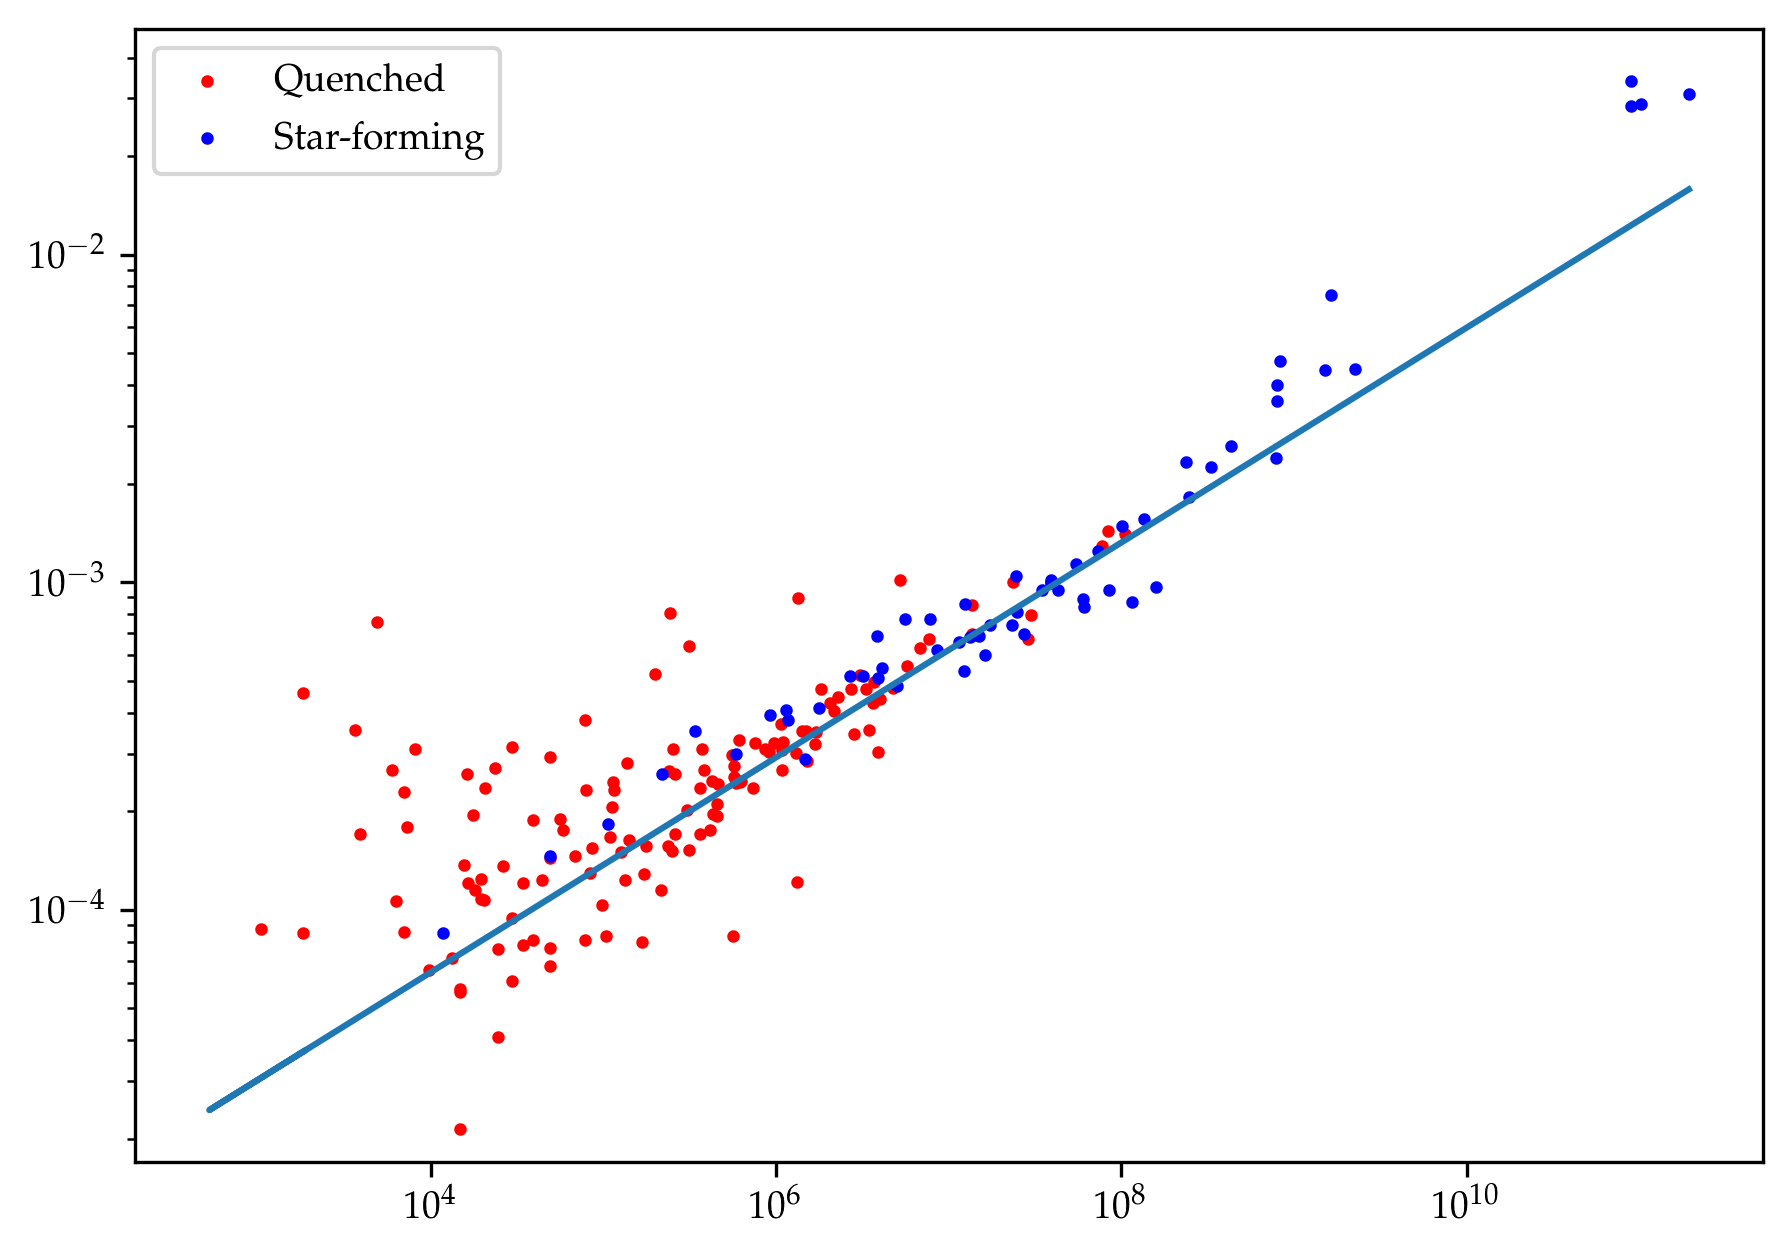

In [103]:
plt.figure(dpi=300, figsize=(7,5))
plt.scatter(q.M_star, q.zstar, color='red', label='Quenched', s=4)
plt.scatter(s.M_star, s.zstar, color='blue', label='Star-forming', s=4)
x = np.log10(np.array(data.M_star, dtype=float))
y = np.log10(np.array(data.zstar, dtype=float))

x = x[y != float('-inf')]
y = y[y != float('-inf')]

m,b = np.polyfit(x, y, 1)
ynew = 10**(m*x+b)
plt.plot(10**x, ynew)

plt.loglog()
plt.legend()
plt.show()




/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


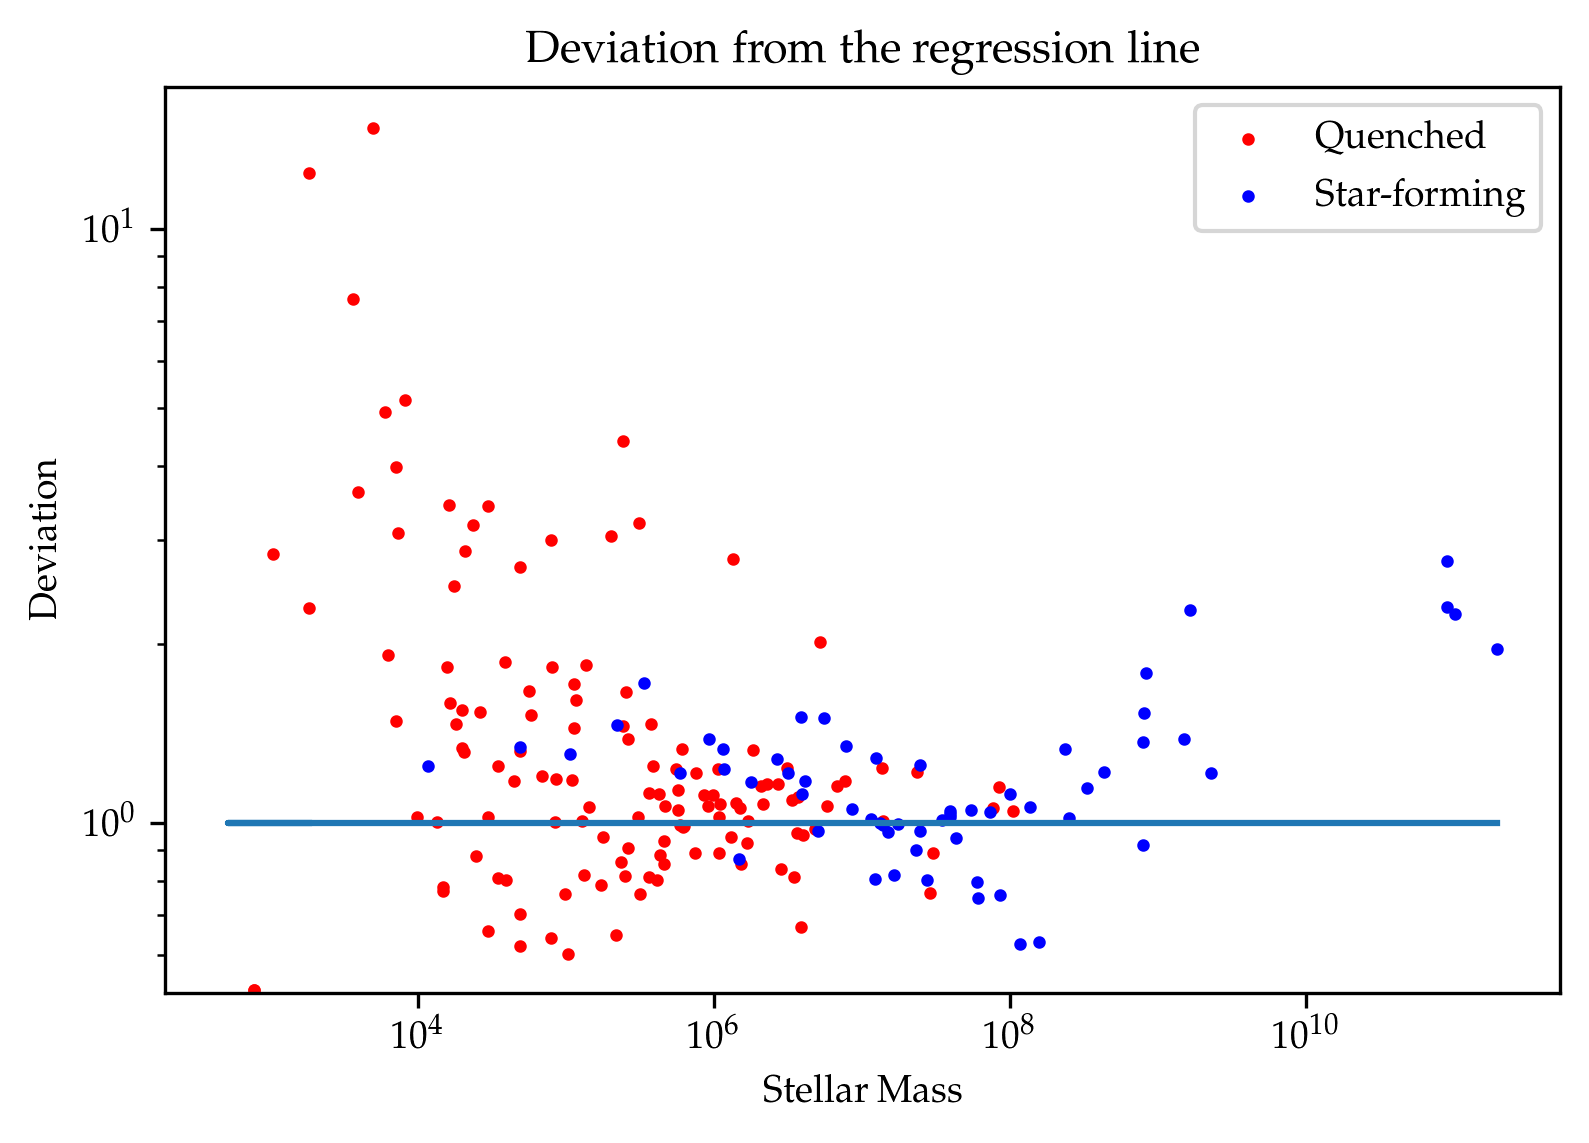

In [111]:
plt.figure(dpi=300)

x = np.log10(np.array(data.M_star, dtype=float))
y = np.log10(np.array(data.zstar, dtype=float))

x = x[y != float('-inf')]
y = y[y != float('-inf')]

plt.plot(10**x, [1]*len(x))

m,b = np.polyfit(x, y, 1)

x = np.log10(np.array(q.M_star, dtype=float))
y = np.log10(np.array(q.zstar, dtype=float))

x = x[y != float('-inf')]
y = y[y != float('-inf')]

ynew = 10**(m*x+b)

plt.scatter(10**x, (10**y)/ynew, color='red', label='Quenched', s=4)

x = np.log10(np.array(s.M_star, dtype=float))
y = np.log10(np.array(s.zstar, dtype=float))

x = x[y != float('-inf')]
y = y[y != float('-inf')]

ynew = 10**(m*x+b)

plt.scatter(10**x, (10**y)/ynew, color='blue', label='Star-forming', s=4)

plt.title('Deviation from the regression line')
plt.xlabel('Stellar Mass')
plt.ylabel('Deviation')
plt.loglog()
plt.legend()
plt.show()

In [115]:
def read_new_data():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

timescales = read_new_data()
timescales['key'] = [str(sim)+'-'+str(i) for sim,i in zip(timescales.sim,timescales.haloid)]
data = read_all()
data['key'] = [str(sim)+'-'+str(i) for sim,i in zip(data.sim,data.haloid)]

In [161]:
merged = pd.merge(timescales, data, on='key',suffixes=('_data','_timescales'))
merged = merged[~np.isnan(np.array(merged.tinfall,dtype=float))&(merged.n_star_data > 100)]

quenched = np.array(merged.quenched,dtype=bool)
tquench = np.array(merged.tquench_timescales,dtype=float)
tinfall = np.array(merged.tinfall, dtype=float)

timescale = tinfall - tquench

mstar = np.array(merged.M_star_data, dtype=float)
zstar = np.array(merged.zstar, dtype=float)

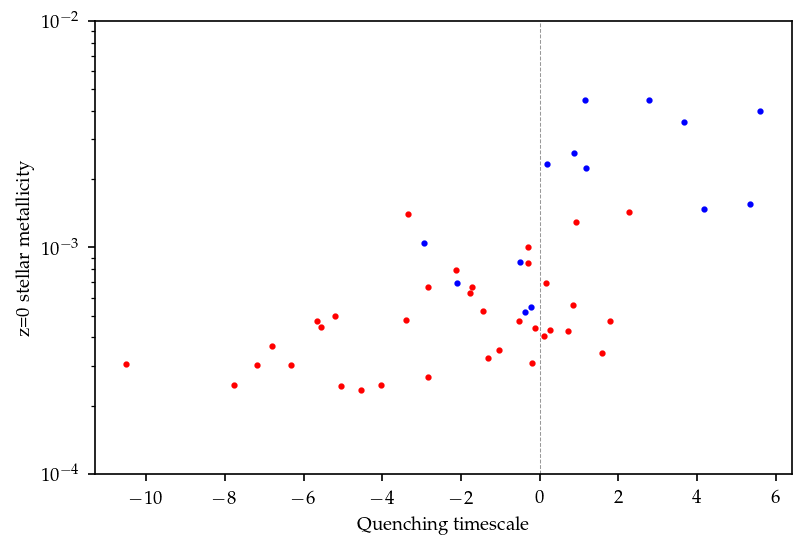

In [165]:
plt.figure(dpi=150)
plt.scatter(timescale[quenched], zstar[quenched],s=4, c='red', label='Quenched')
plt.scatter(timescale[~quenched], zstar[~quenched],s=4, c='blue',label='Star-forming')
plt.semilogy()
plt.ylim(1e-4, 1e-2)
plt.xlabel('Quenching timescale')
plt.ylabel('z=0 stellar metallicity')
plt.plot([0,0],[1e-4,1e-2],'k--',linewidth=0.5,alpha=0.4)
plt.show()

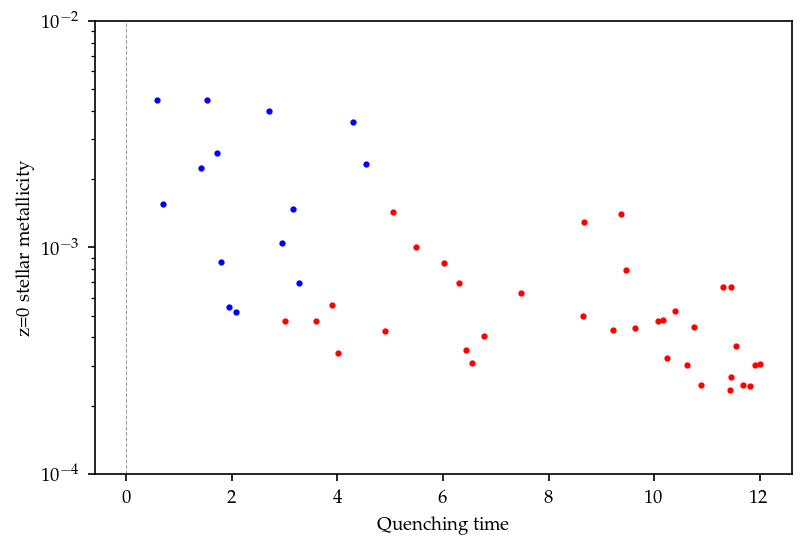

In [171]:
plt.figure(dpi=150)
plt.scatter(tquench[quenched], zstar[quenched],s=4, c='red', label='Quenched')
plt.scatter(tquench[~quenched], zstar[~quenched],s=4, c='blue',label='Star-forming')
plt.semilogy()
plt.ylim(1e-4, 1e-2)
plt.xlabel('Quenching time')
plt.ylabel('z=0 stellar metallicity')
plt.plot([0,0],[1e-4,1e-2],'k--',linewidth=0.5,alpha=0.4)
plt.show()

In [175]:
test = read_timesteps('h148')

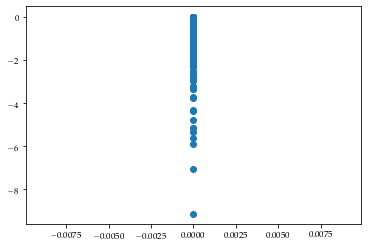

In [185]:
plt.scatter(test.sfr, test.inflow_23)
plt.show()

In [183]:
test.inflow_23

0      -0.404846
1      -0.207019
2      -0.031289
3      -0.016006
4      -0.006689
5      -0.004934
6      -0.043123
7       0.000000
8      -0.001728
9      -0.000458
10     -0.001453
11     -0.009488
12     -0.004874
13     -0.000255
14      0.000000
15           NaN
16     -0.001656
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24      0.000000
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
          ...   
2040   -0.144562
2041   -0.591469
2042   -0.713833
2043   -0.006726
2044   -0.082471
2045   -0.119717
2046   -0.003465
2047   -0.020811
2048   -0.009403
2049   -0.044870
2050   -0.019360
2051   -0.255799
2052   -0.039505
2053   -0.146860
2054   -0.073244
2055   -0.015692
2056   -0.009448
2057   -0.100001
2058   -0.144321
2059   -0.018677
2060   -0.014183
2061   -0.056311
2062   -0.110628
2063   -0.025846
2064   -0.065390
2065   -0.144243
2066   -0.070102
2067   -0.0070

In [243]:
def read_timesteps(simname):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(f'/home/akinshol/Data/Timescales/DataFiles/{simname}.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    
    data = pd.DataFrame(data)
    return data

def read_timescales():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

In [250]:
timescales = read_timescales()
timescales = timescales[(timescales.sim == 'h242') & (timescales.haloid==10)]
timescales.T

51
M_star         8.00638e+08
haloid                  10
n_star              159188
quenched             False
sim                   h242
tinfall            8.29637
tinfall_lower      8.61961
tinfall_upper      8.29637
tquench                NaN
tquench_lower          NaN
tquench_upper          NaN

[10.0, 12.0, 24.0, 30.0, 34.0, 40.0, 41.0, 44.0, 48.0, 49.0, 71.0, 78.0, 80.0, 86.0, 165.0, 223.0, 439.0]
6.070902913790072


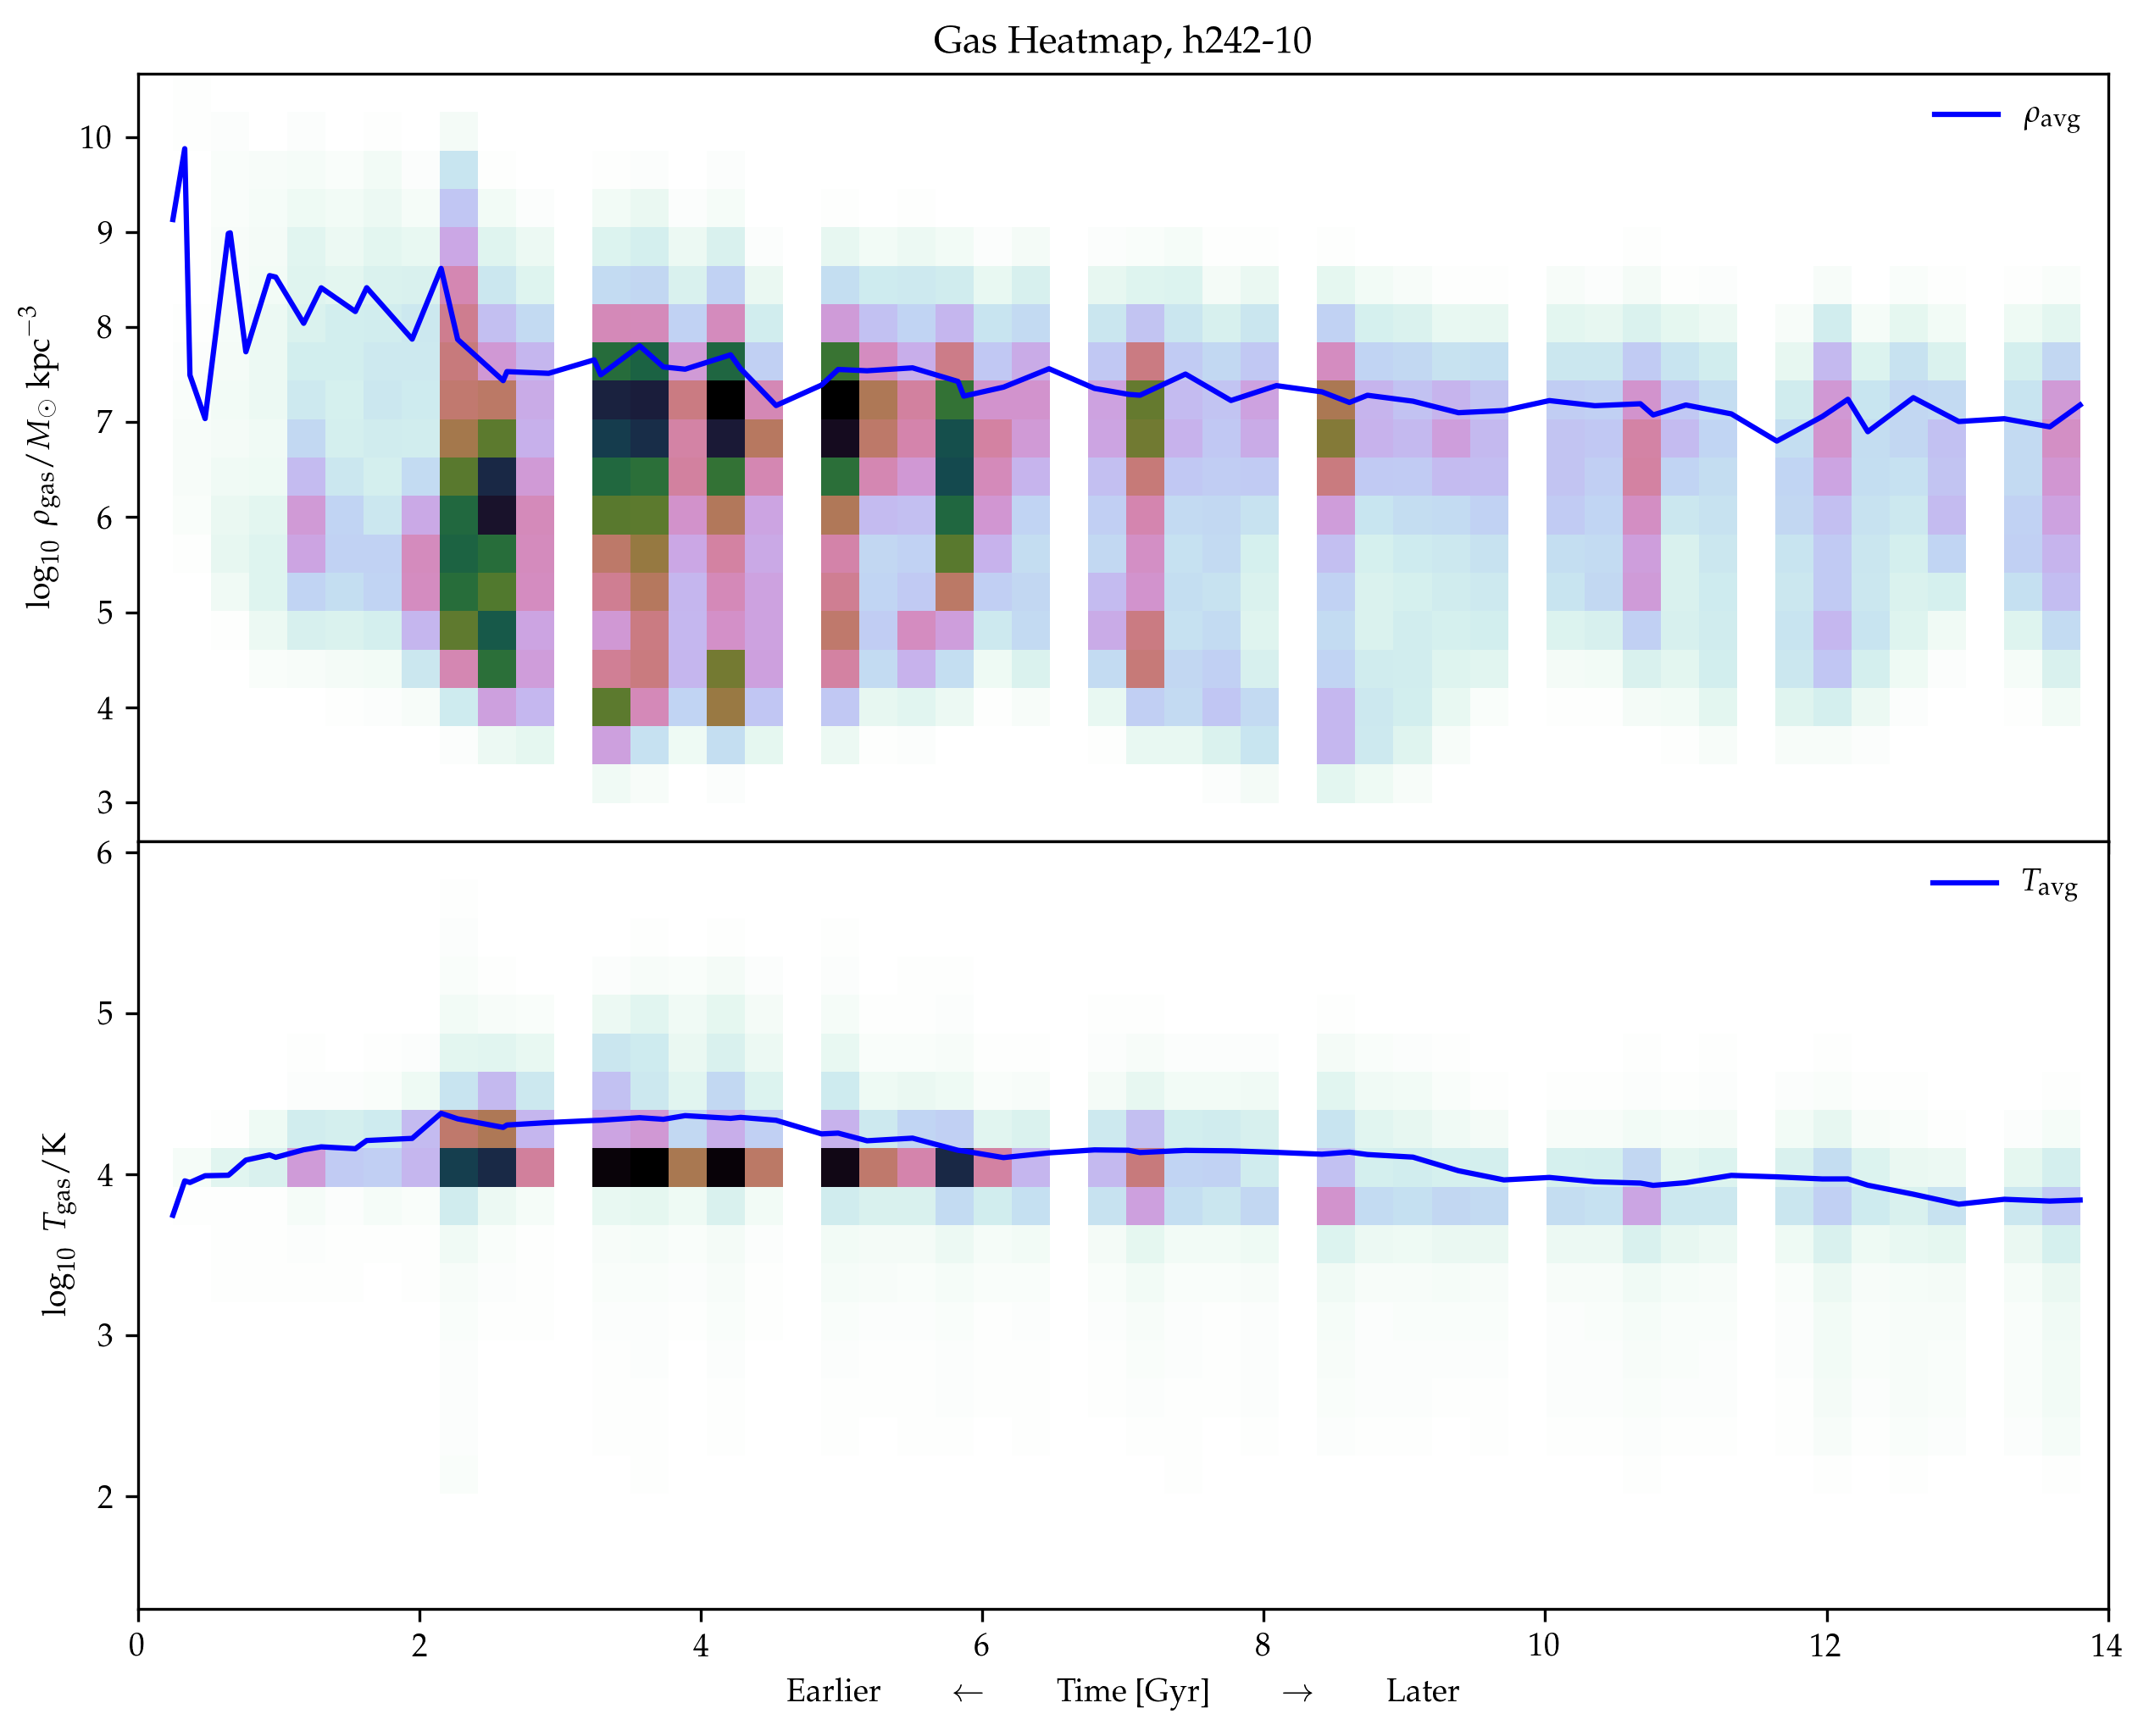

5.982528538486096


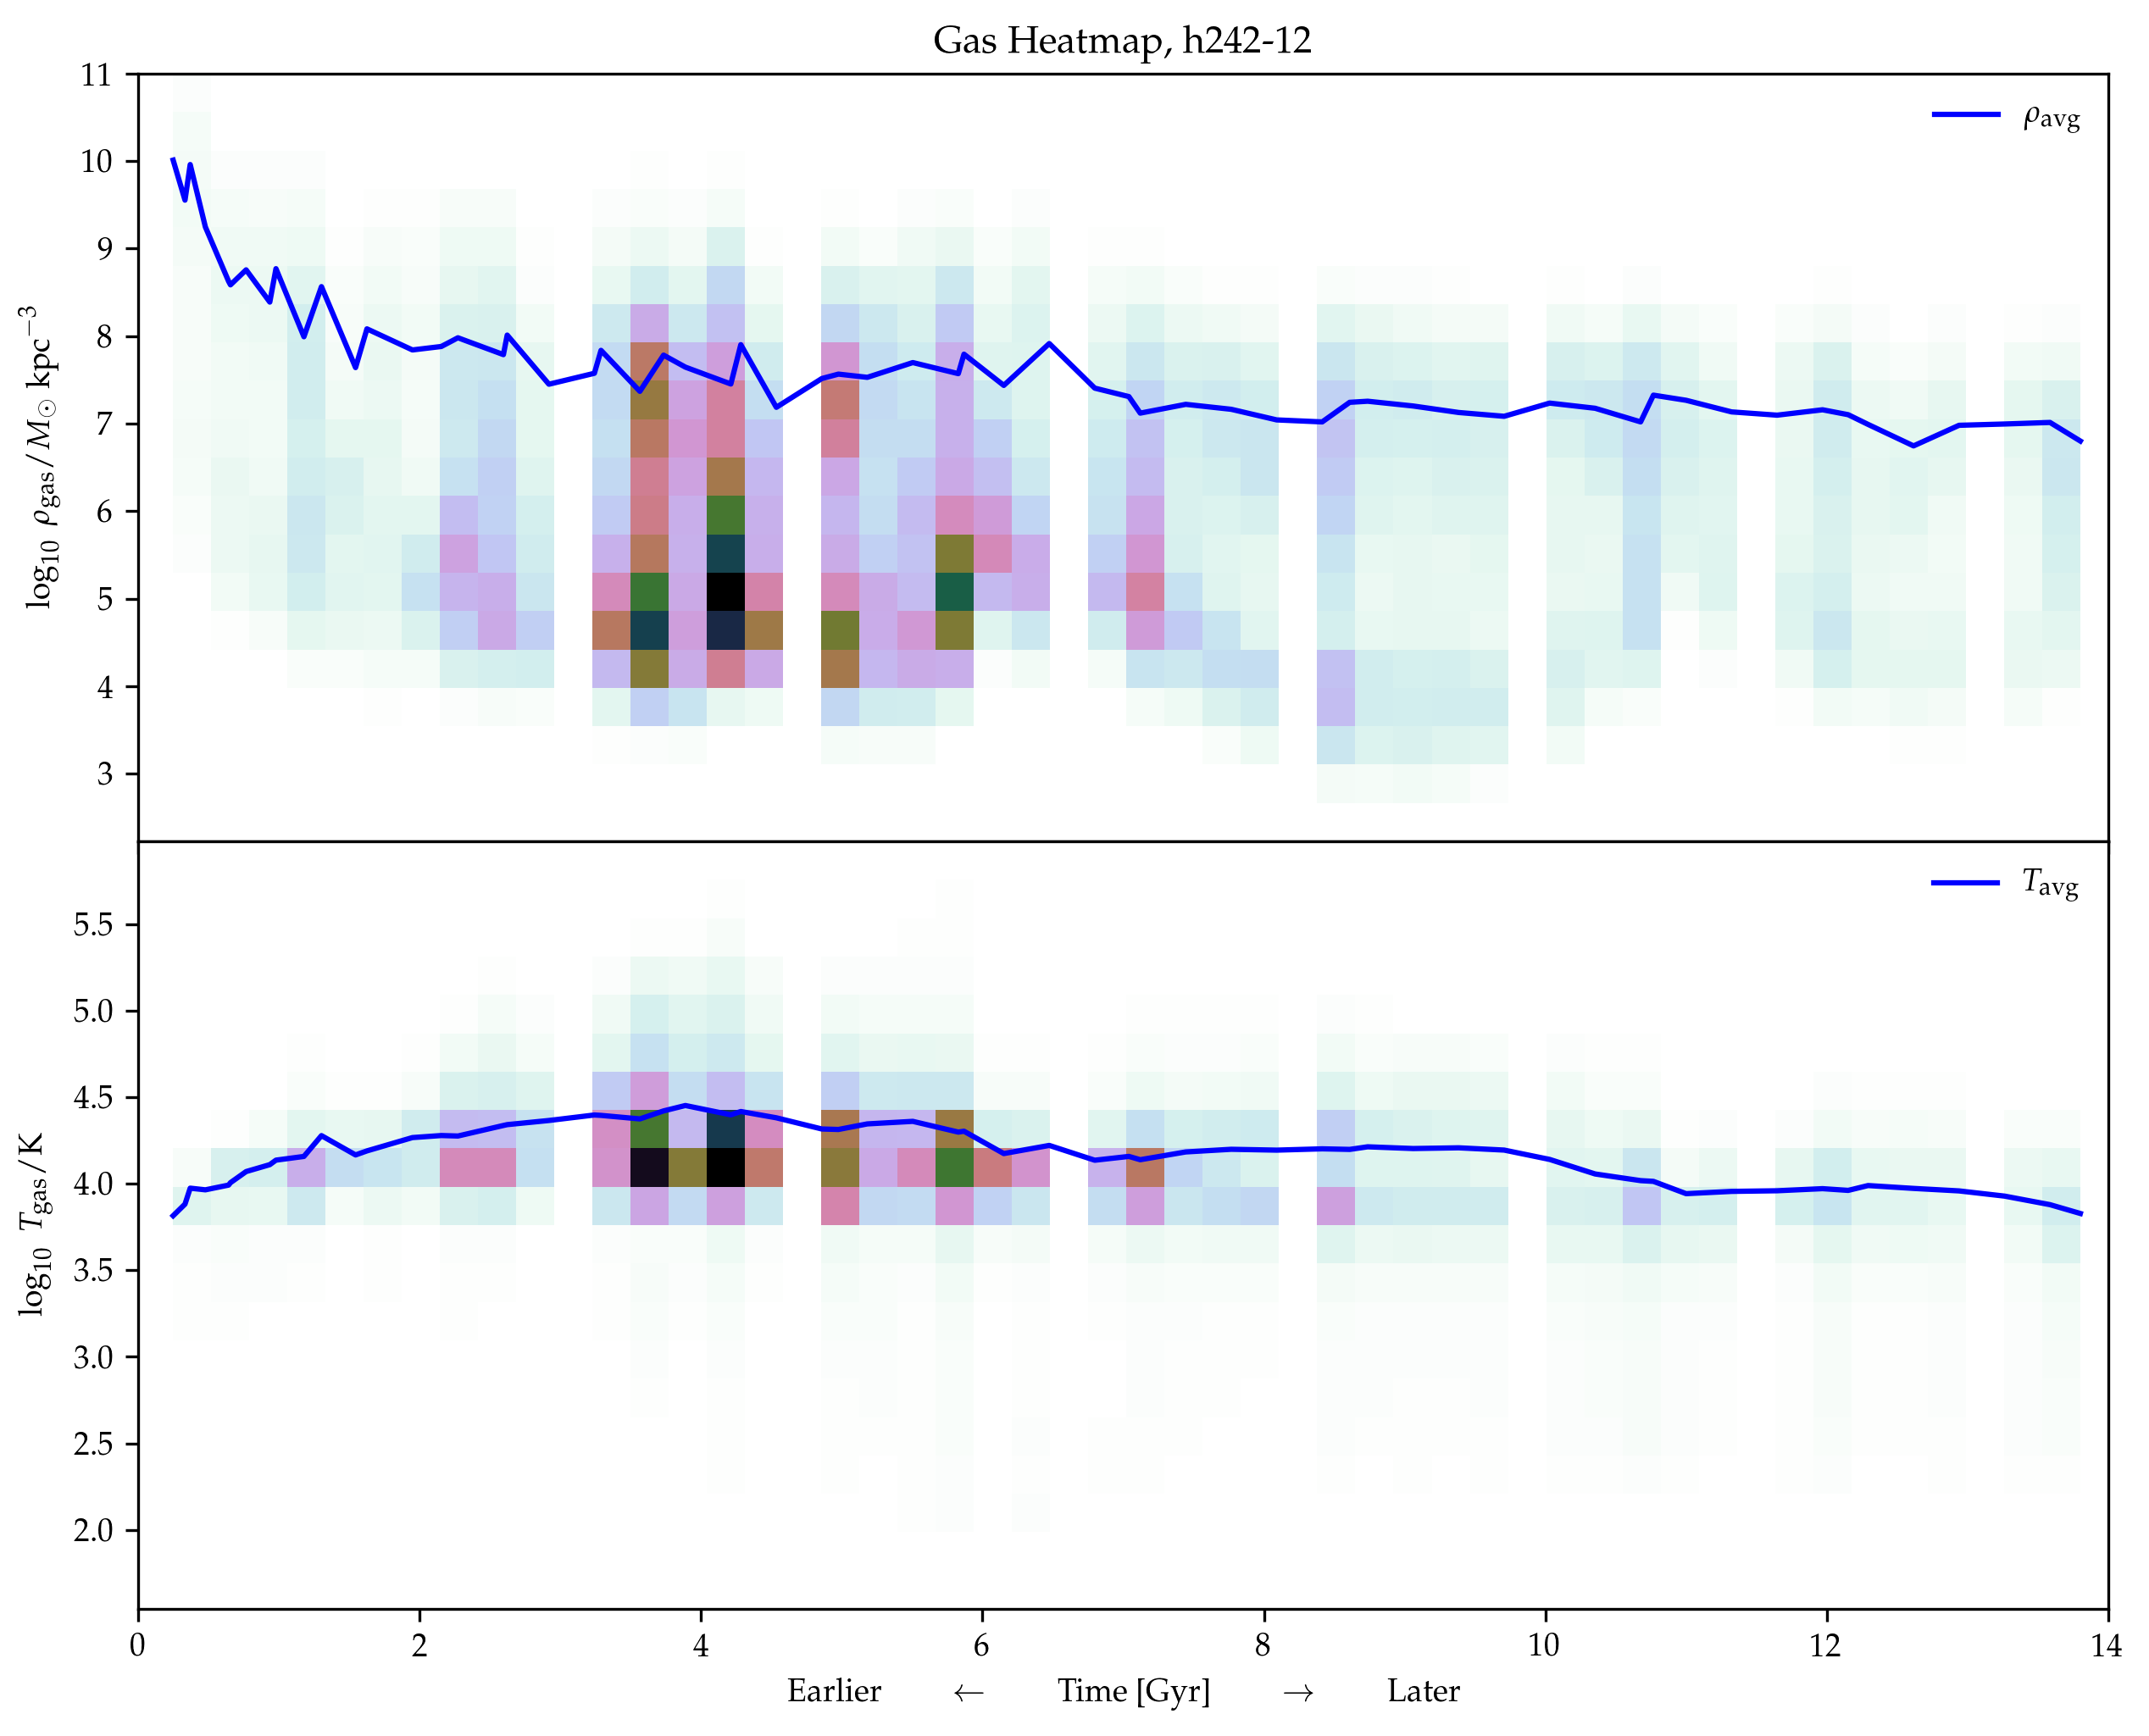

5.3990193809279425


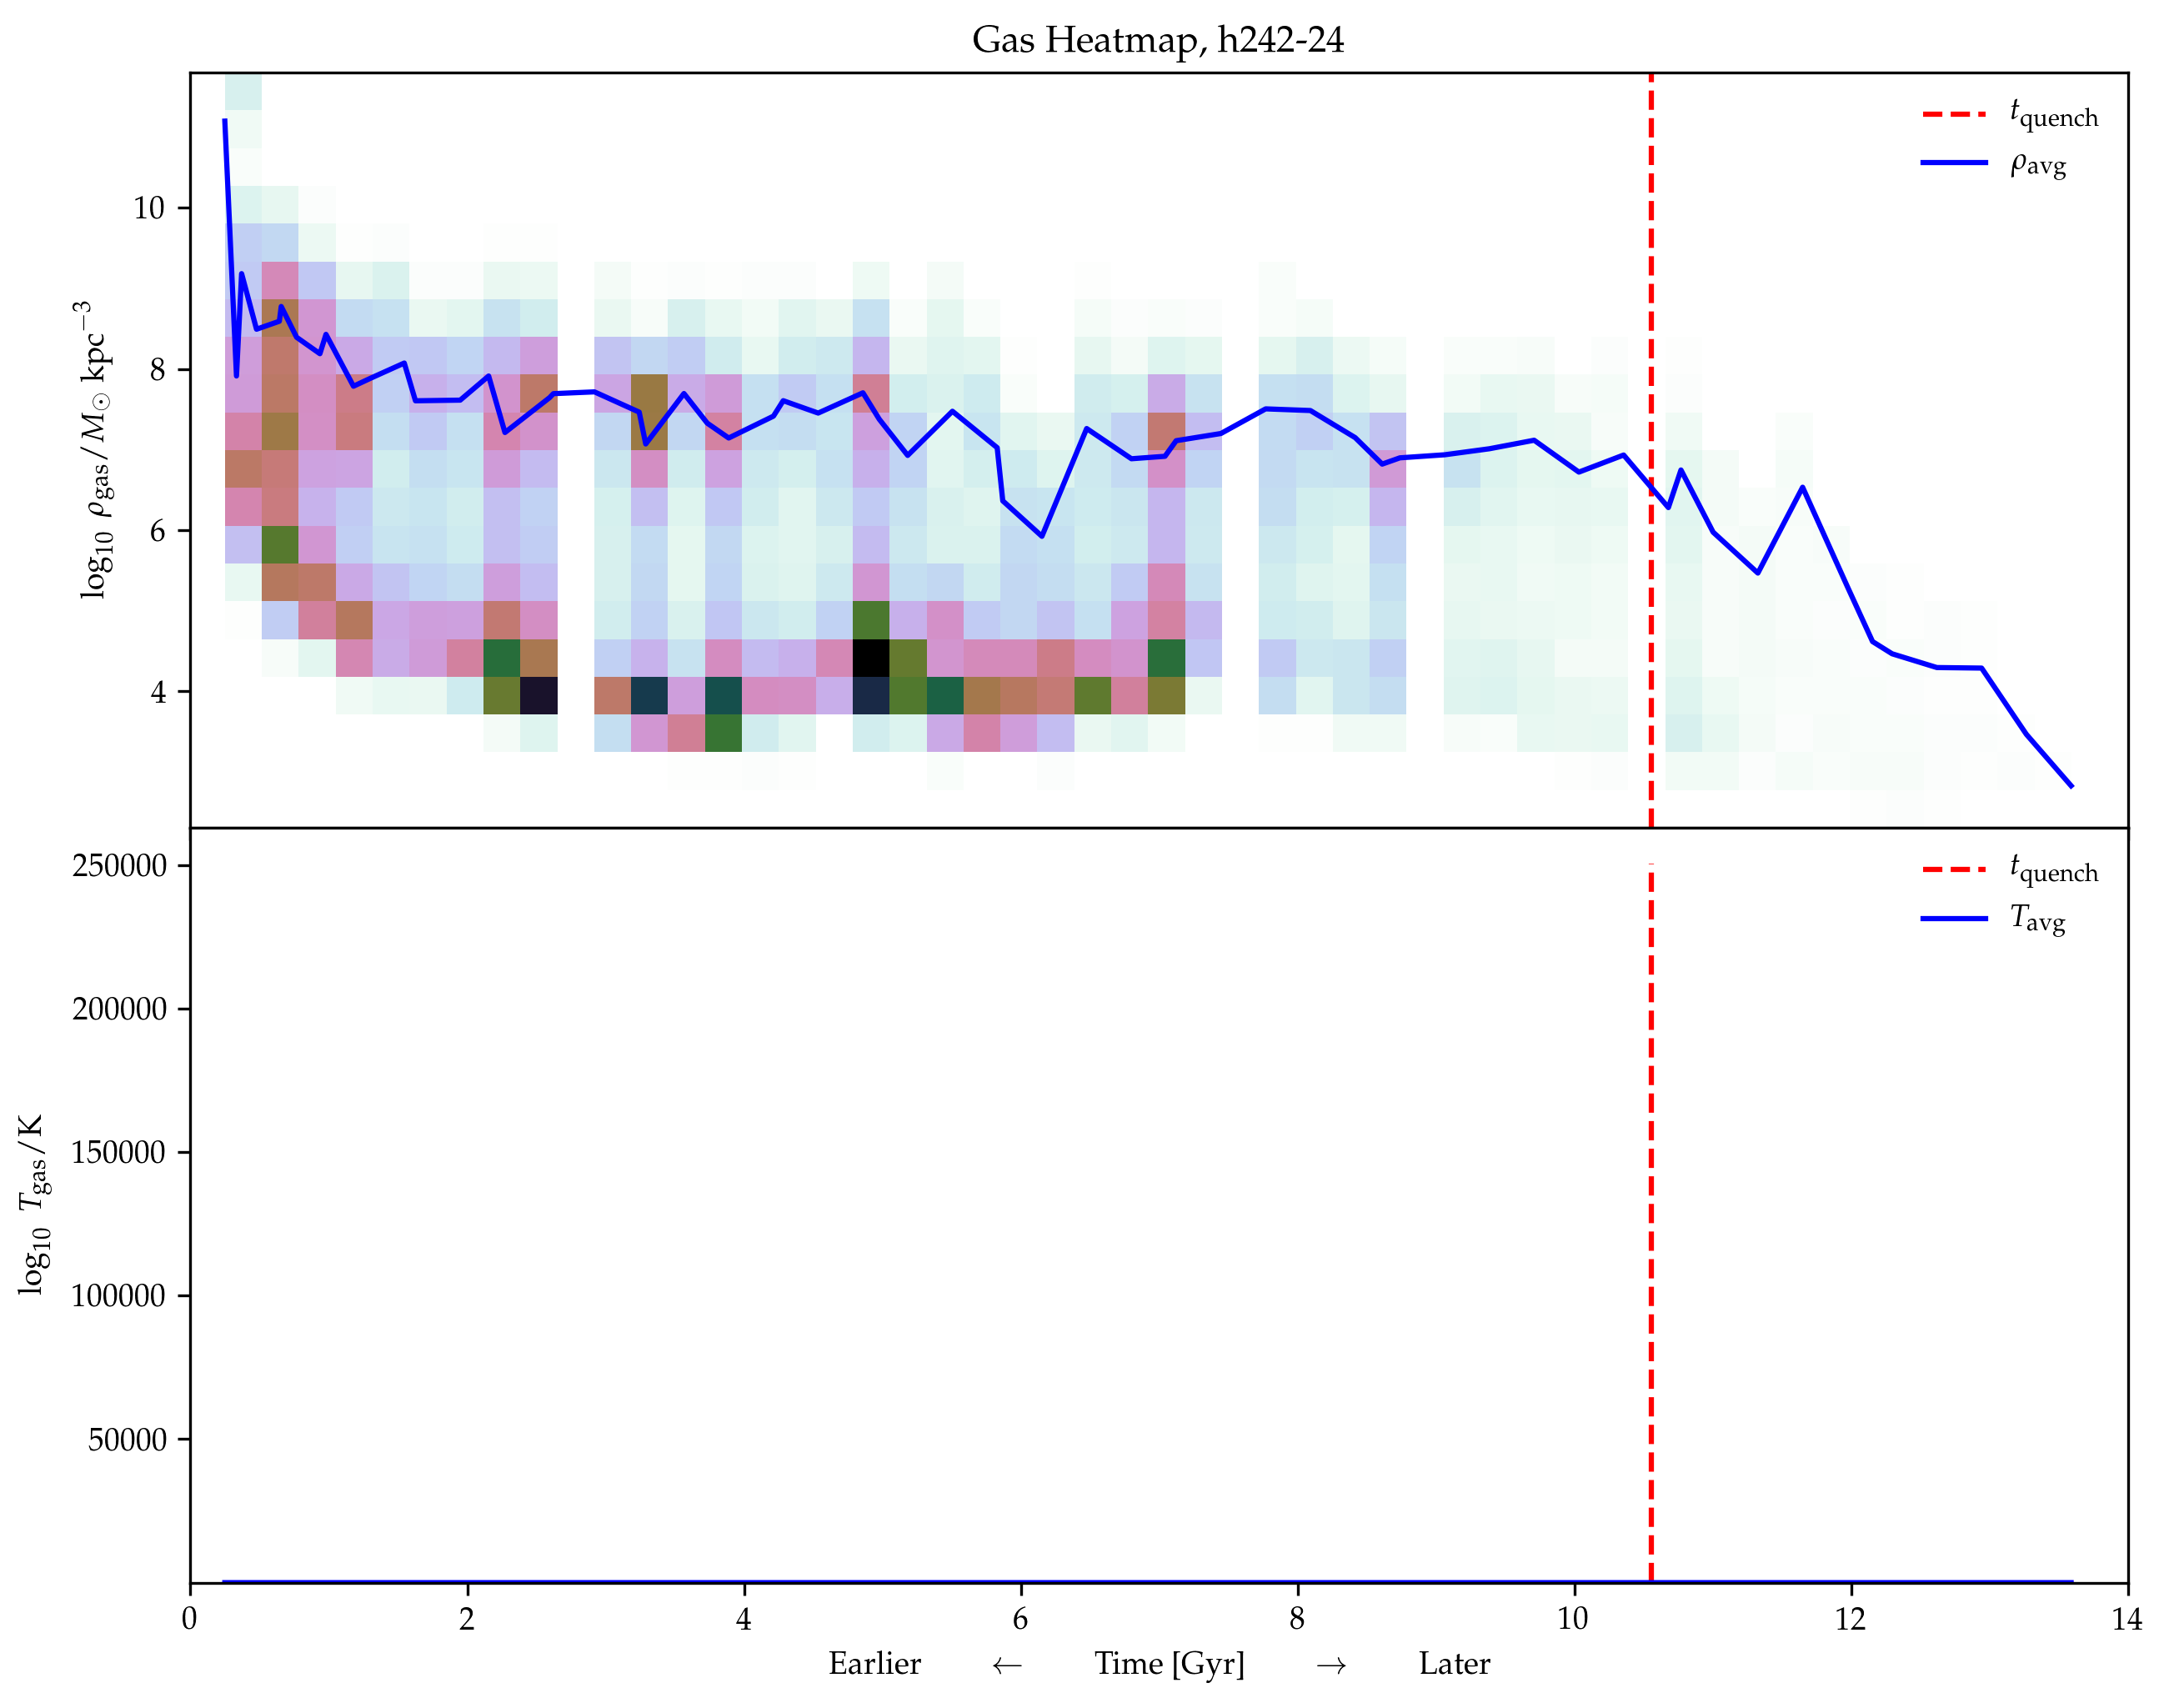

5.133218158480861


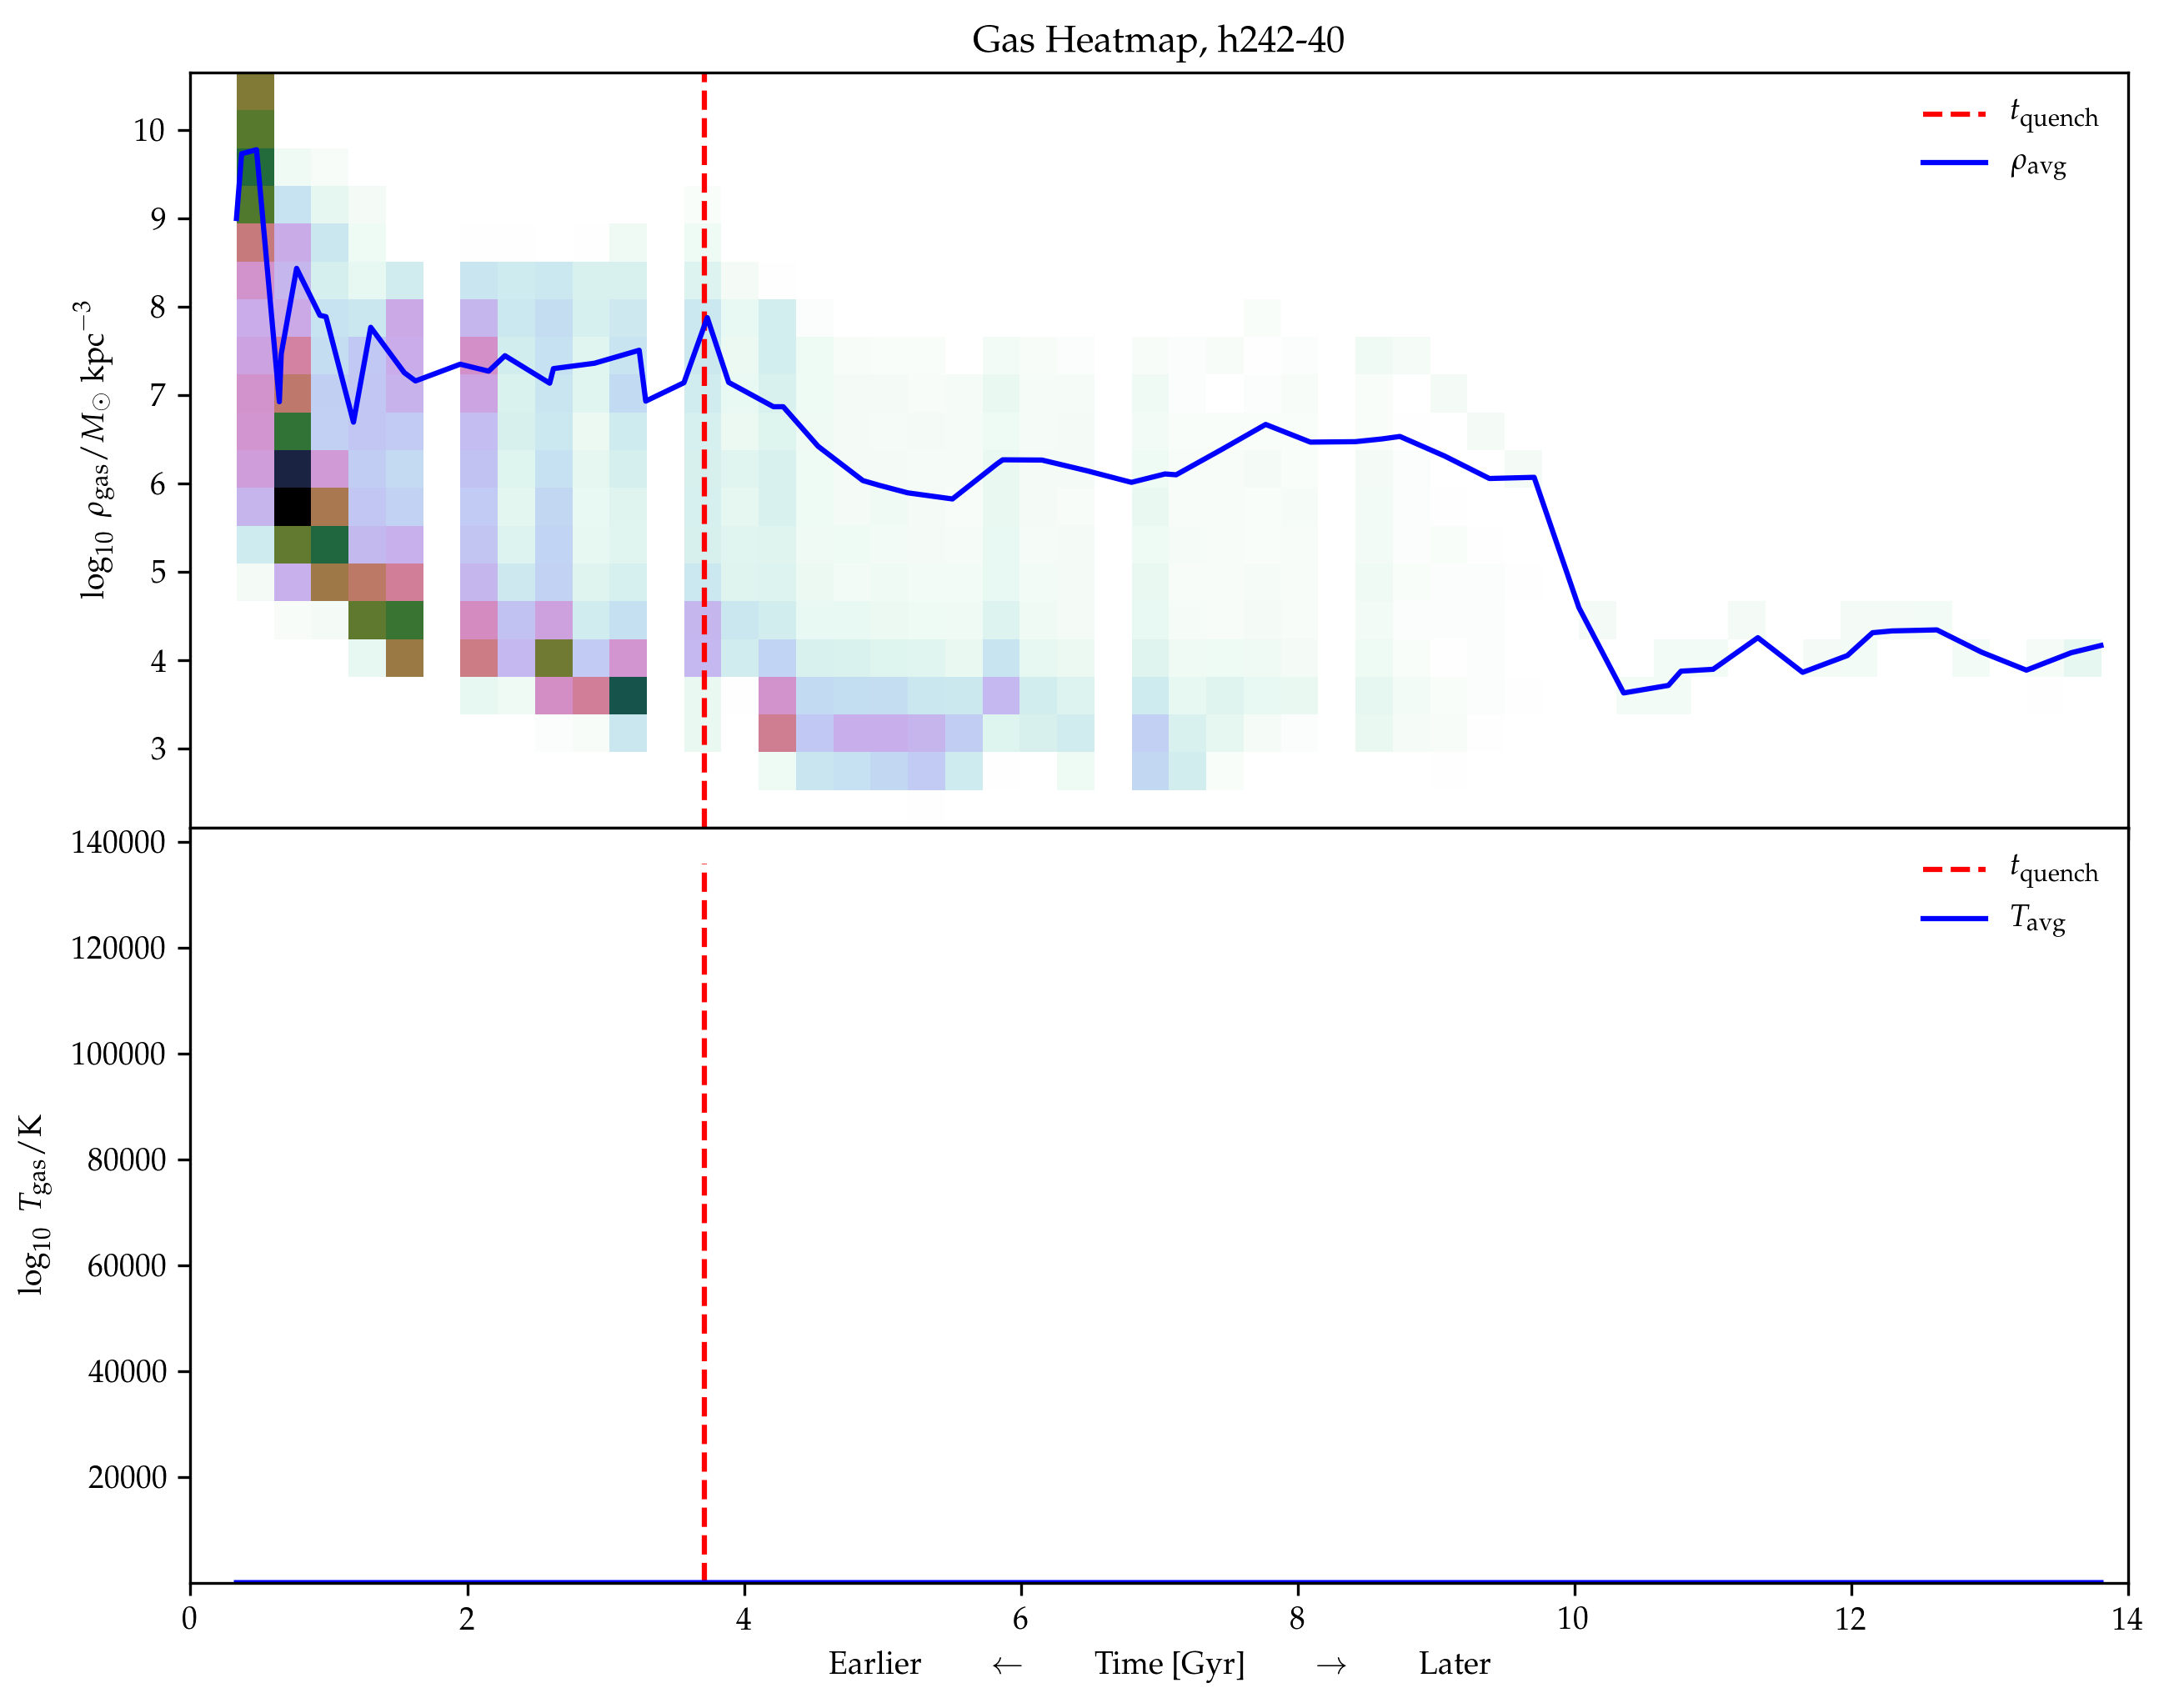

5.246174054337634


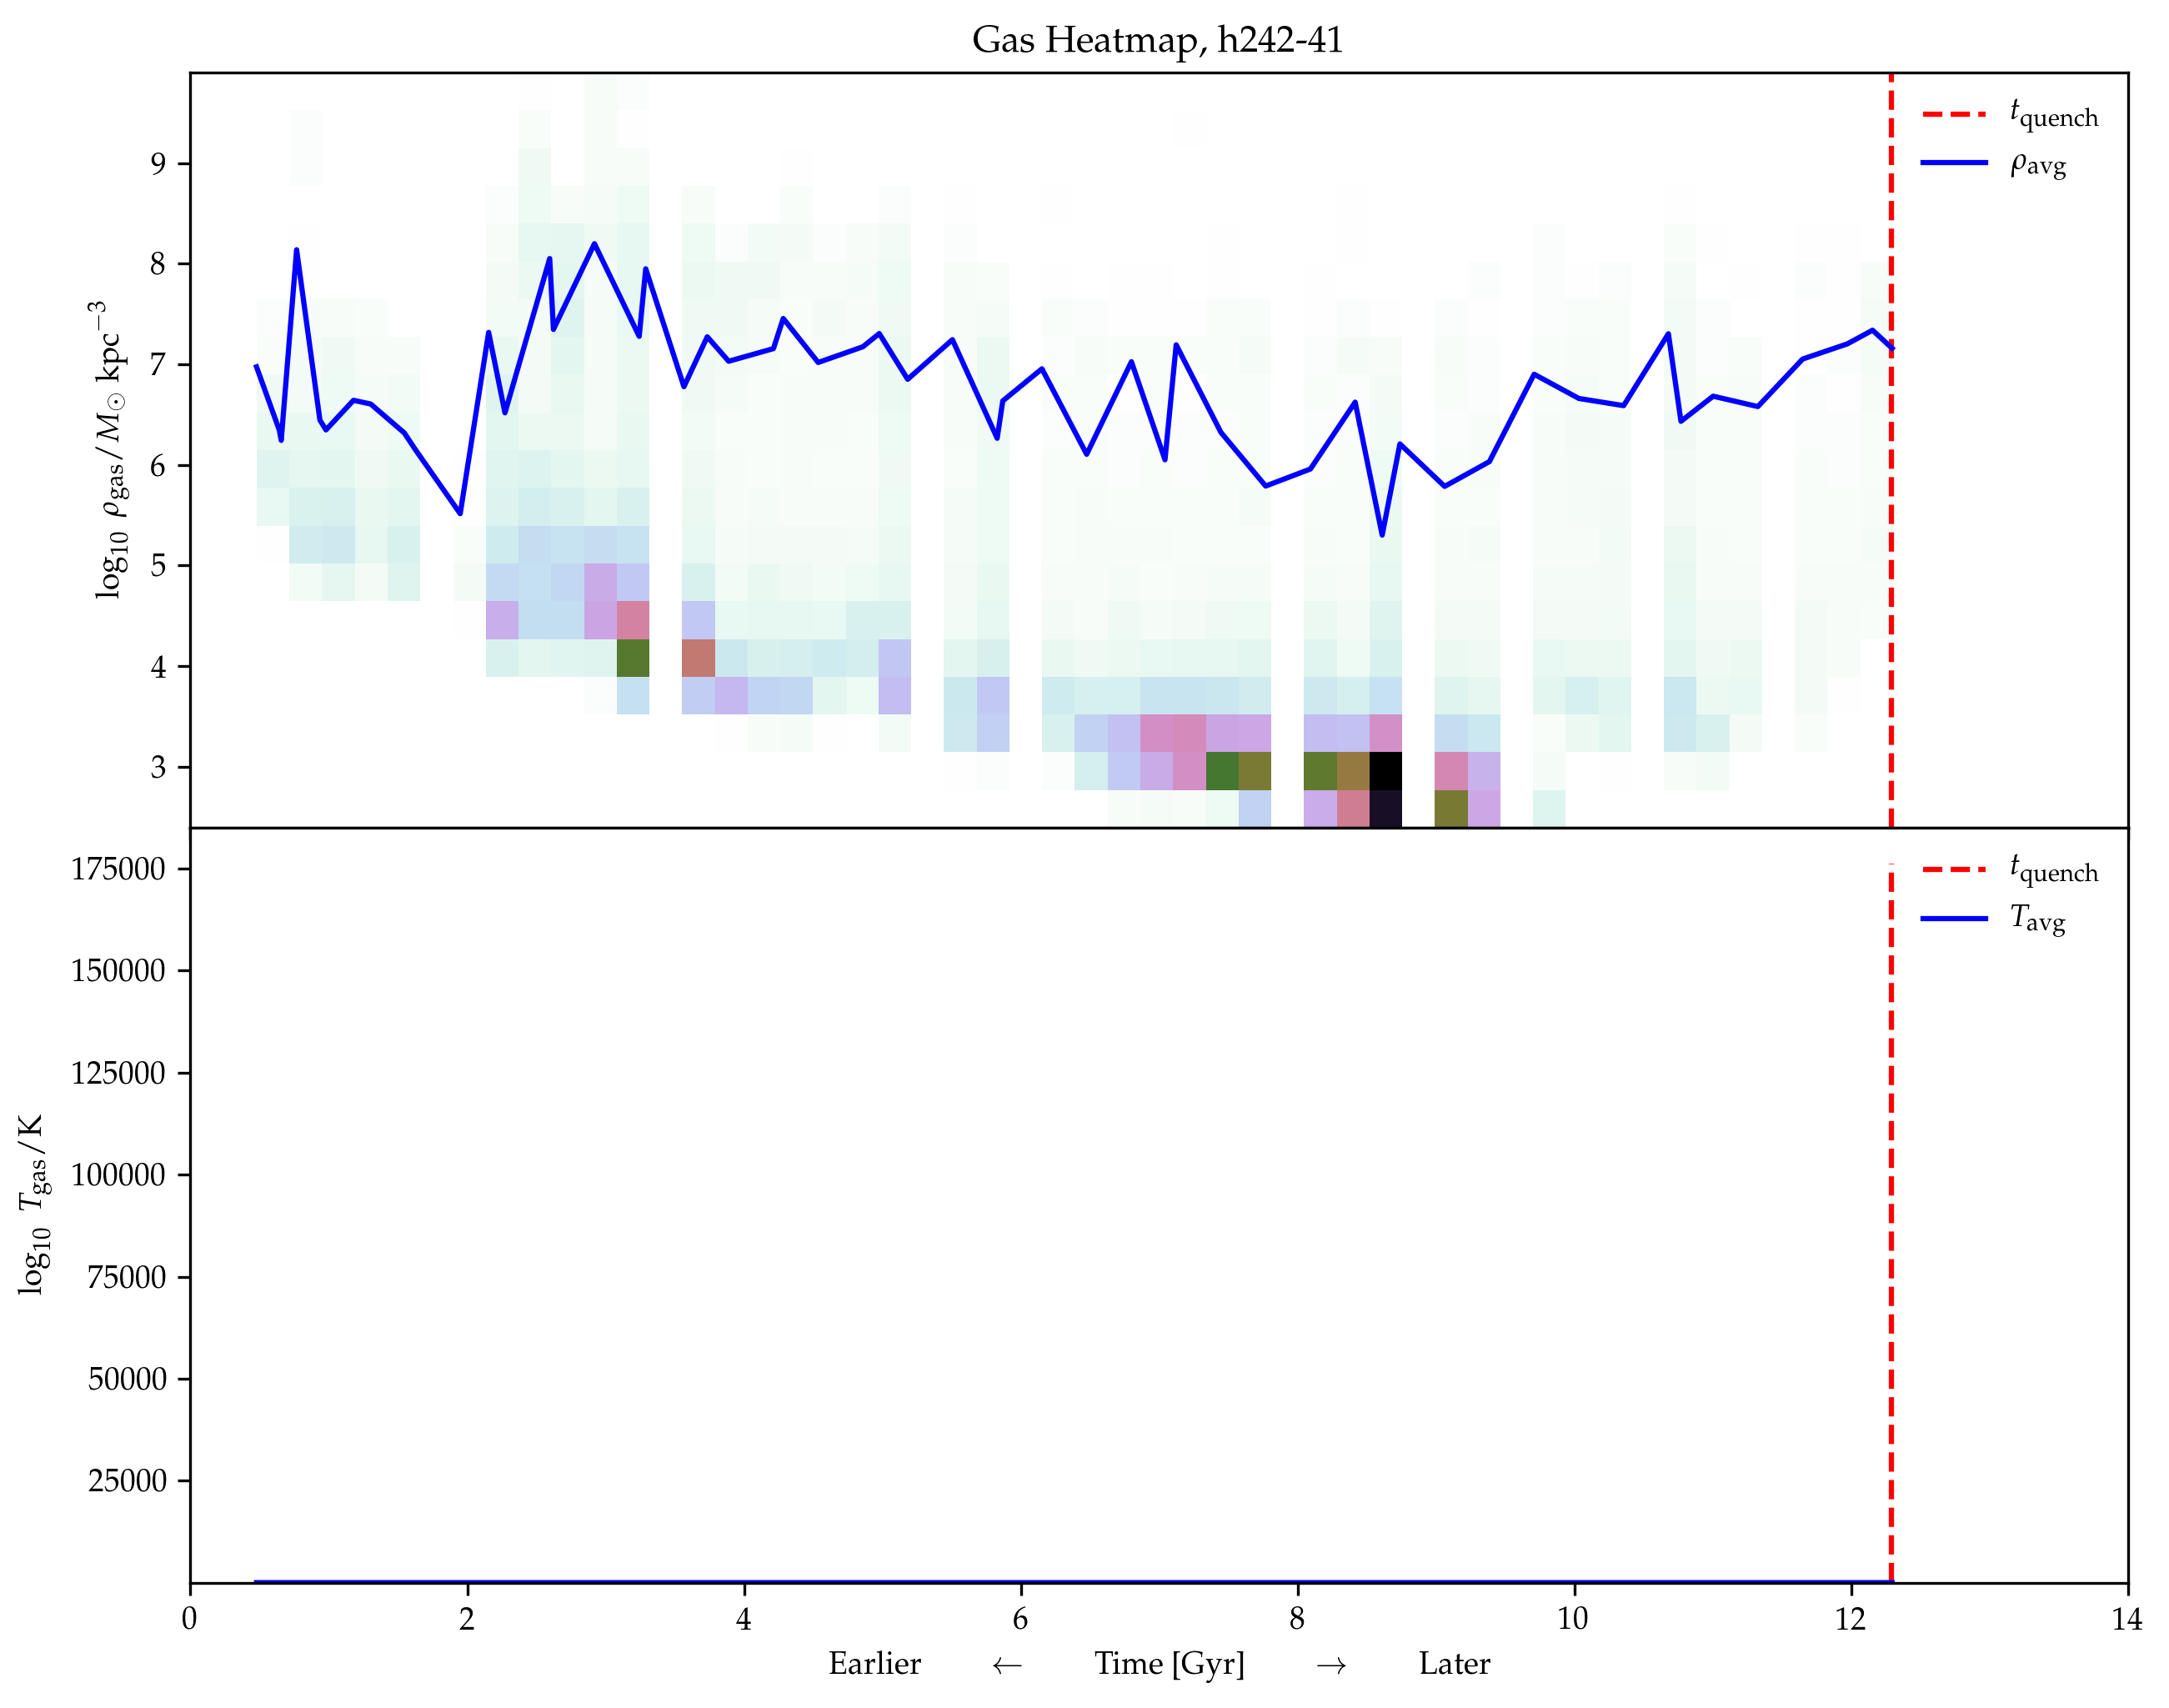

4.92344236635611


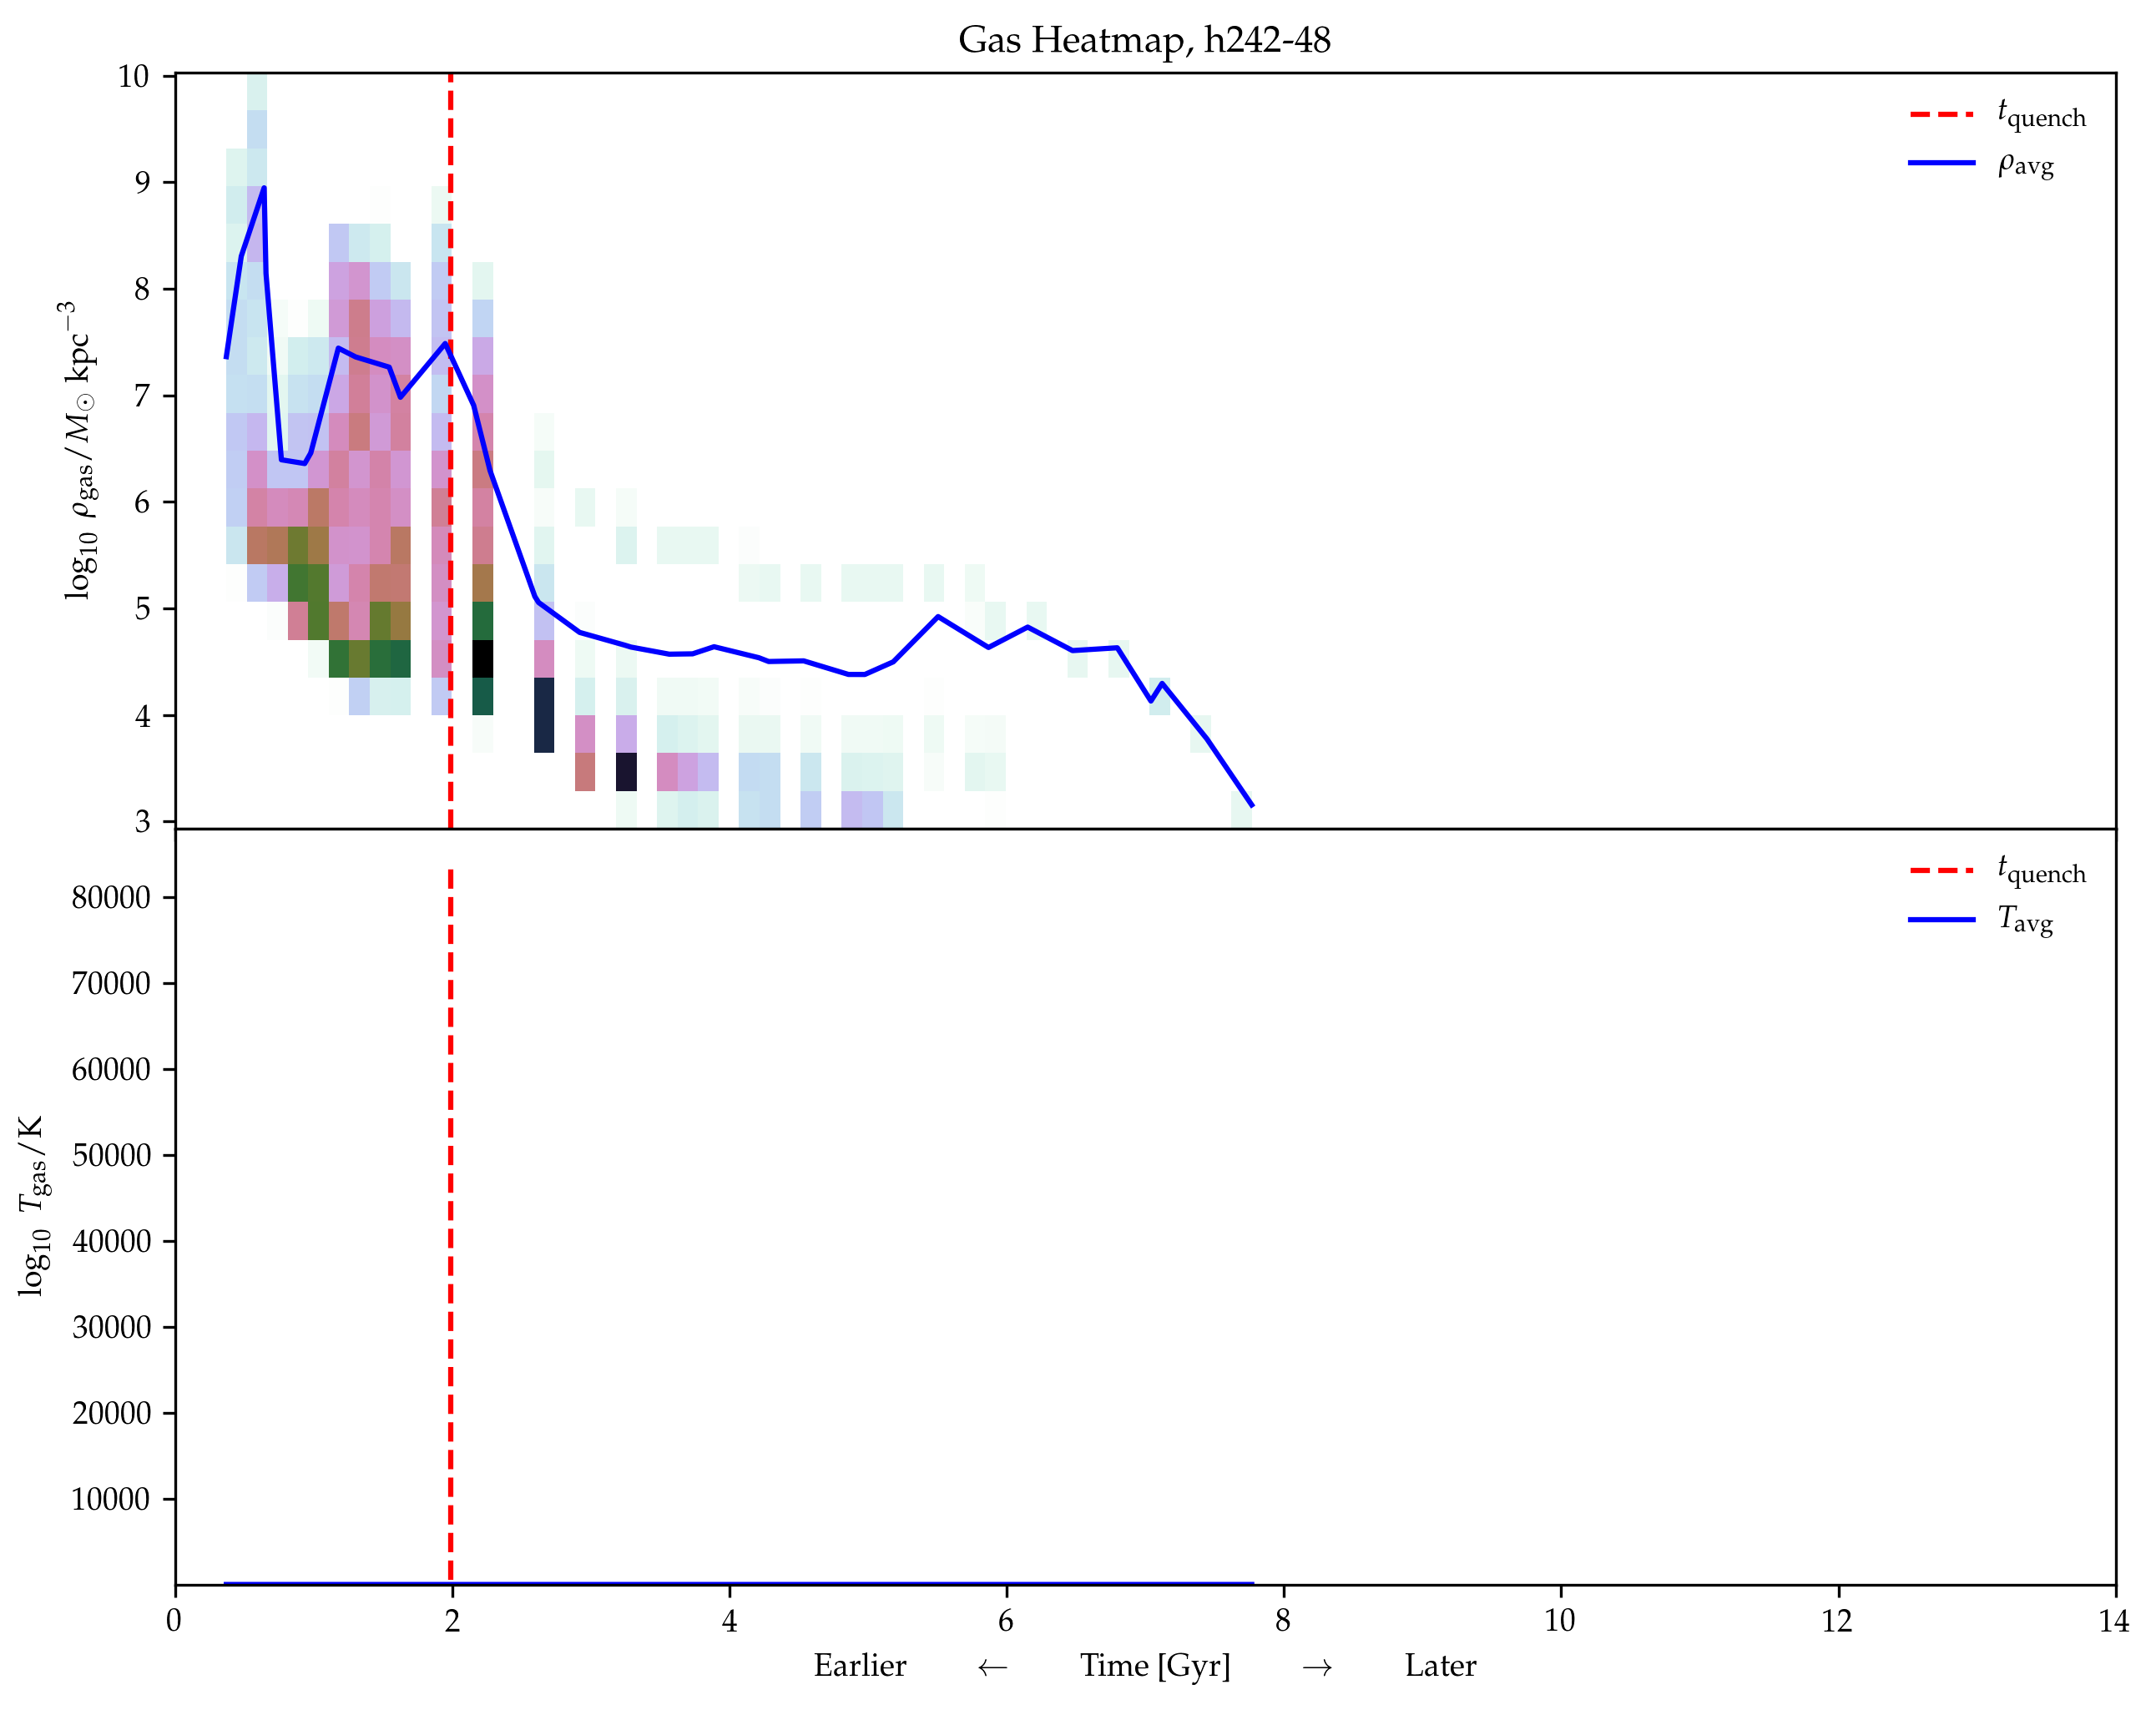

4.797642494721438


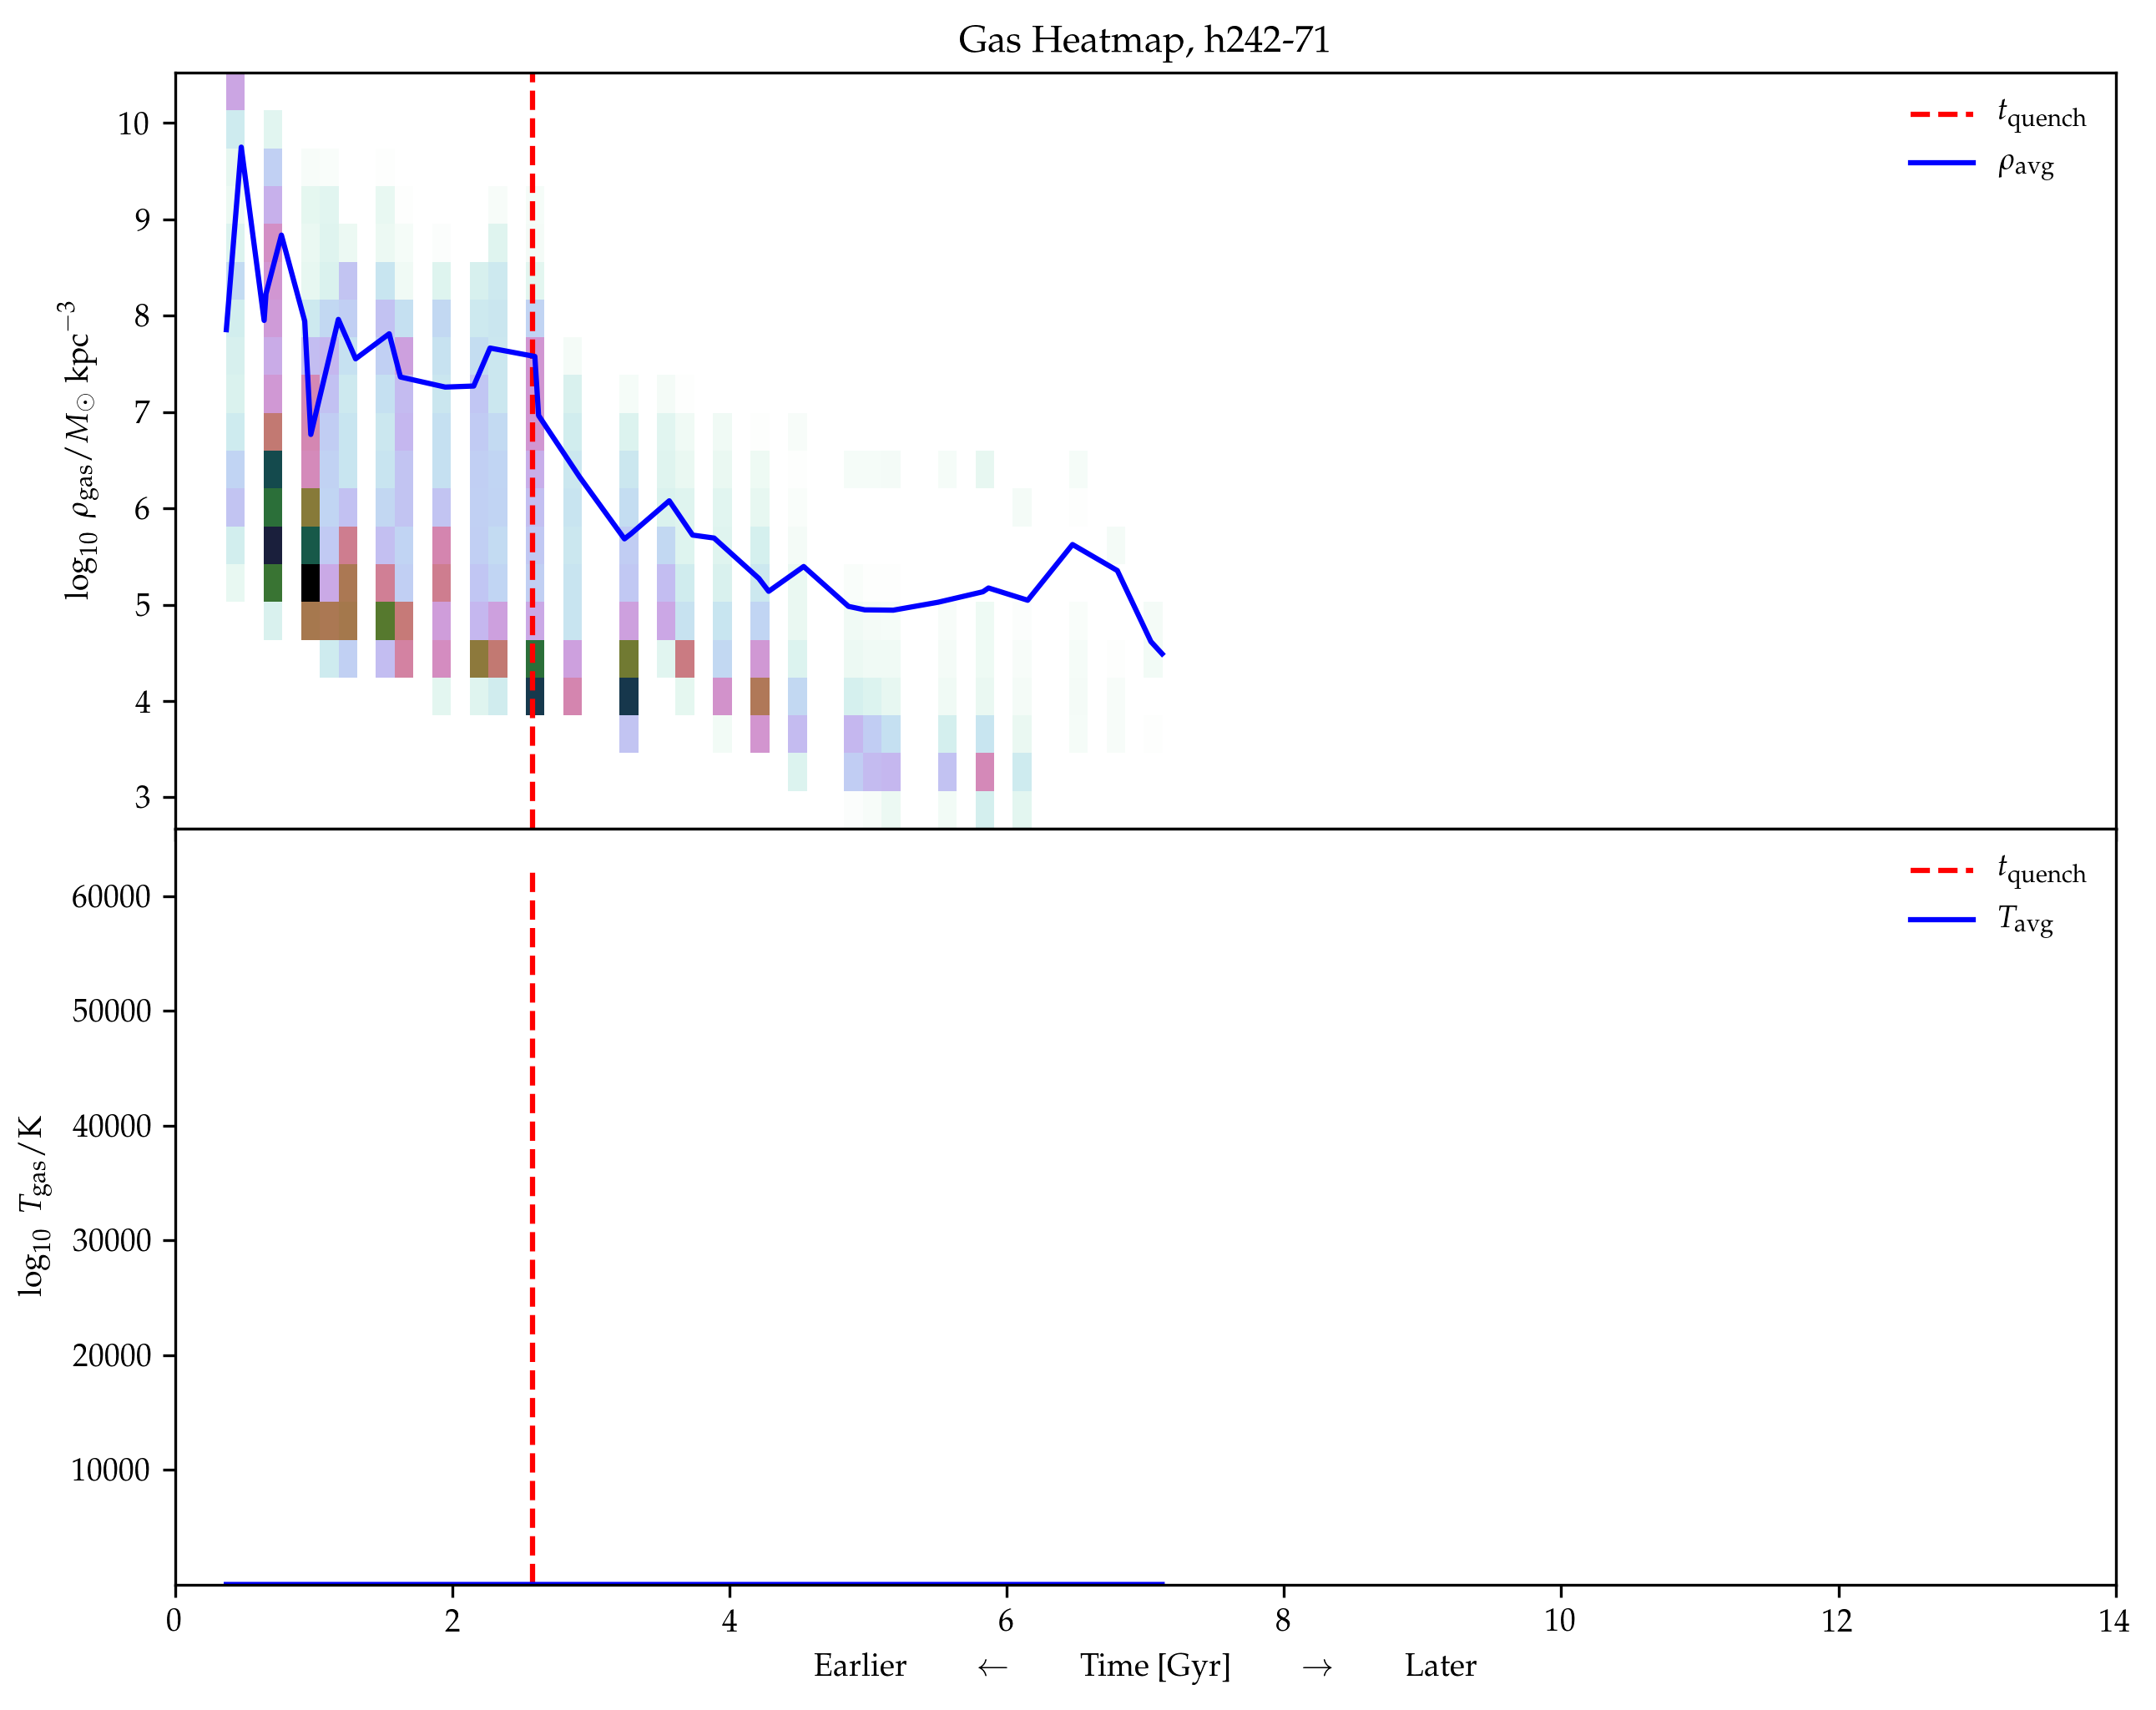

In [301]:
sim = 'h242'
data = read_timesteps(sim)
print(list(np.unique(data.z0haloid)))

for haloid in [10, 12, 24, 40, 41, 48, 71]:
    d = data[data.z0haloid==haloid]
    
    # determine t_quench
    timescales = read_timescales()
    timescales = timescales[(timescales.sim == sim) & (timescales.haloid==haloid)]
    tquench = timescales.tquench.tolist()[0]
    tquench = 13.800797497330507 - tquench
    
    # get distributions of gas density
    times, rhos, masses, weights = np.array([]), np.array([]), np.array([]), np.array([])
    for time, rho, mass in zip(d.time, d.gas_rho, d.gas_mass):
        if len(rho) != 0:
            rhos = np.append(rhos, rho)
            masses = np.append(masses, mass)
            weights = np.append(weights, mass/np.sum(mass))
            times = np.append(times, [time]*len(rho))

    
    rho_mean = [np.log10(np.mean(rho)) for rho in d.gas_rho] 
    
    rhos_heatmap, xedges, yedges = np.histogram2d(times, np.log10(rhos), bins=(50,20))
    rhos_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # get distributions of gas temperature
    times, temps, masses, weights = np.array([]), np.array([]), np.array([]), np.array([])
    for time, temp, mass in zip(d.time, d.gas_temp, d.gas_mass):
        if len(temp) != 0:
            masses = np.append(masses, mass)
            temps = np.append(temps, temp)
            weights = np.append(weights, mass/np.sum(mass))
            times = np.append(times, [time]*len(temp))
    
    temp_mean = [np.log10(np.mean(temp)) for temp in d.gas_temp]

    
    
    temps_heatmap, xedges, yedges = np.histogram2d(times, np.log10(temps), bins=(50,20))
    temps_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig, ax = plt.subplots(2,1,dpi=300,figsize=(10,8),sharex=True)
    
    ax[0].set_title(f'Gas Heatmap, {sim}-{haloid}')
    if not np.isnan(tquench):
        ax[0].plot([tquench,tquench], [np.min(np.log10(temps)), np.max(np.log10(temps))], 'r--', label='$t_{\mathrm{quench}}$')
    ax[0].imshow(rhos_heatmap.T, extent=rhos_extent, origin='lower', cmap='cubehelix_r', aspect='auto')
    ax[0].set_ylabel(r'$\log_{10}~\rho_{\mathrm{gas}} / M_{\odot}~\mathrm{kpc}^{-3}$')
    ax[0].set_xlim(0, 14)
    ax[0].plot(d.time, rho_mean, 'b-', label=r'$\rho_{\mathrm{avg}}$')
    ax[0].legend(frameon=False)
    
    if not np.isnan(tquench):
        ax[1].plot([tquench,tquench], [np.min(temps),np.max(temps)], 'r--', label='$t_{\mathrm{quench}}$')
    ax[1].imshow(temps_heatmap.T, extent=temps_extent, origin='lower', cmap='cubehelix_r', aspect='auto')
    ax[1].set_xlabel(r'Earlier $\qquad\leftarrow\qquad$ Time [Gyr] $\qquad\rightarrow\qquad$ Later')
    ax[1].set_ylabel(r'$\log_{10}~T_{\mathrm{gas}} / \mathrm{K}$')
    ax[1].set_xlim(0,14)
    ax[1].plot(d.time, temp_mean, 'b-', label=r'$T_{\mathrm{avg}}$')
    ax[1].legend(frameon=False)
    
    plt.subplots_adjust(hspace=0.)
    plt.show()

# Attempt at Weighting the Distributions by Mass

[10.0, 12.0, 24.0, 30.0, 34.0, 40.0, 41.0, 44.0, 48.0, 49.0, 71.0, 78.0, 80.0, 86.0, 165.0, 223.0, 439.0]


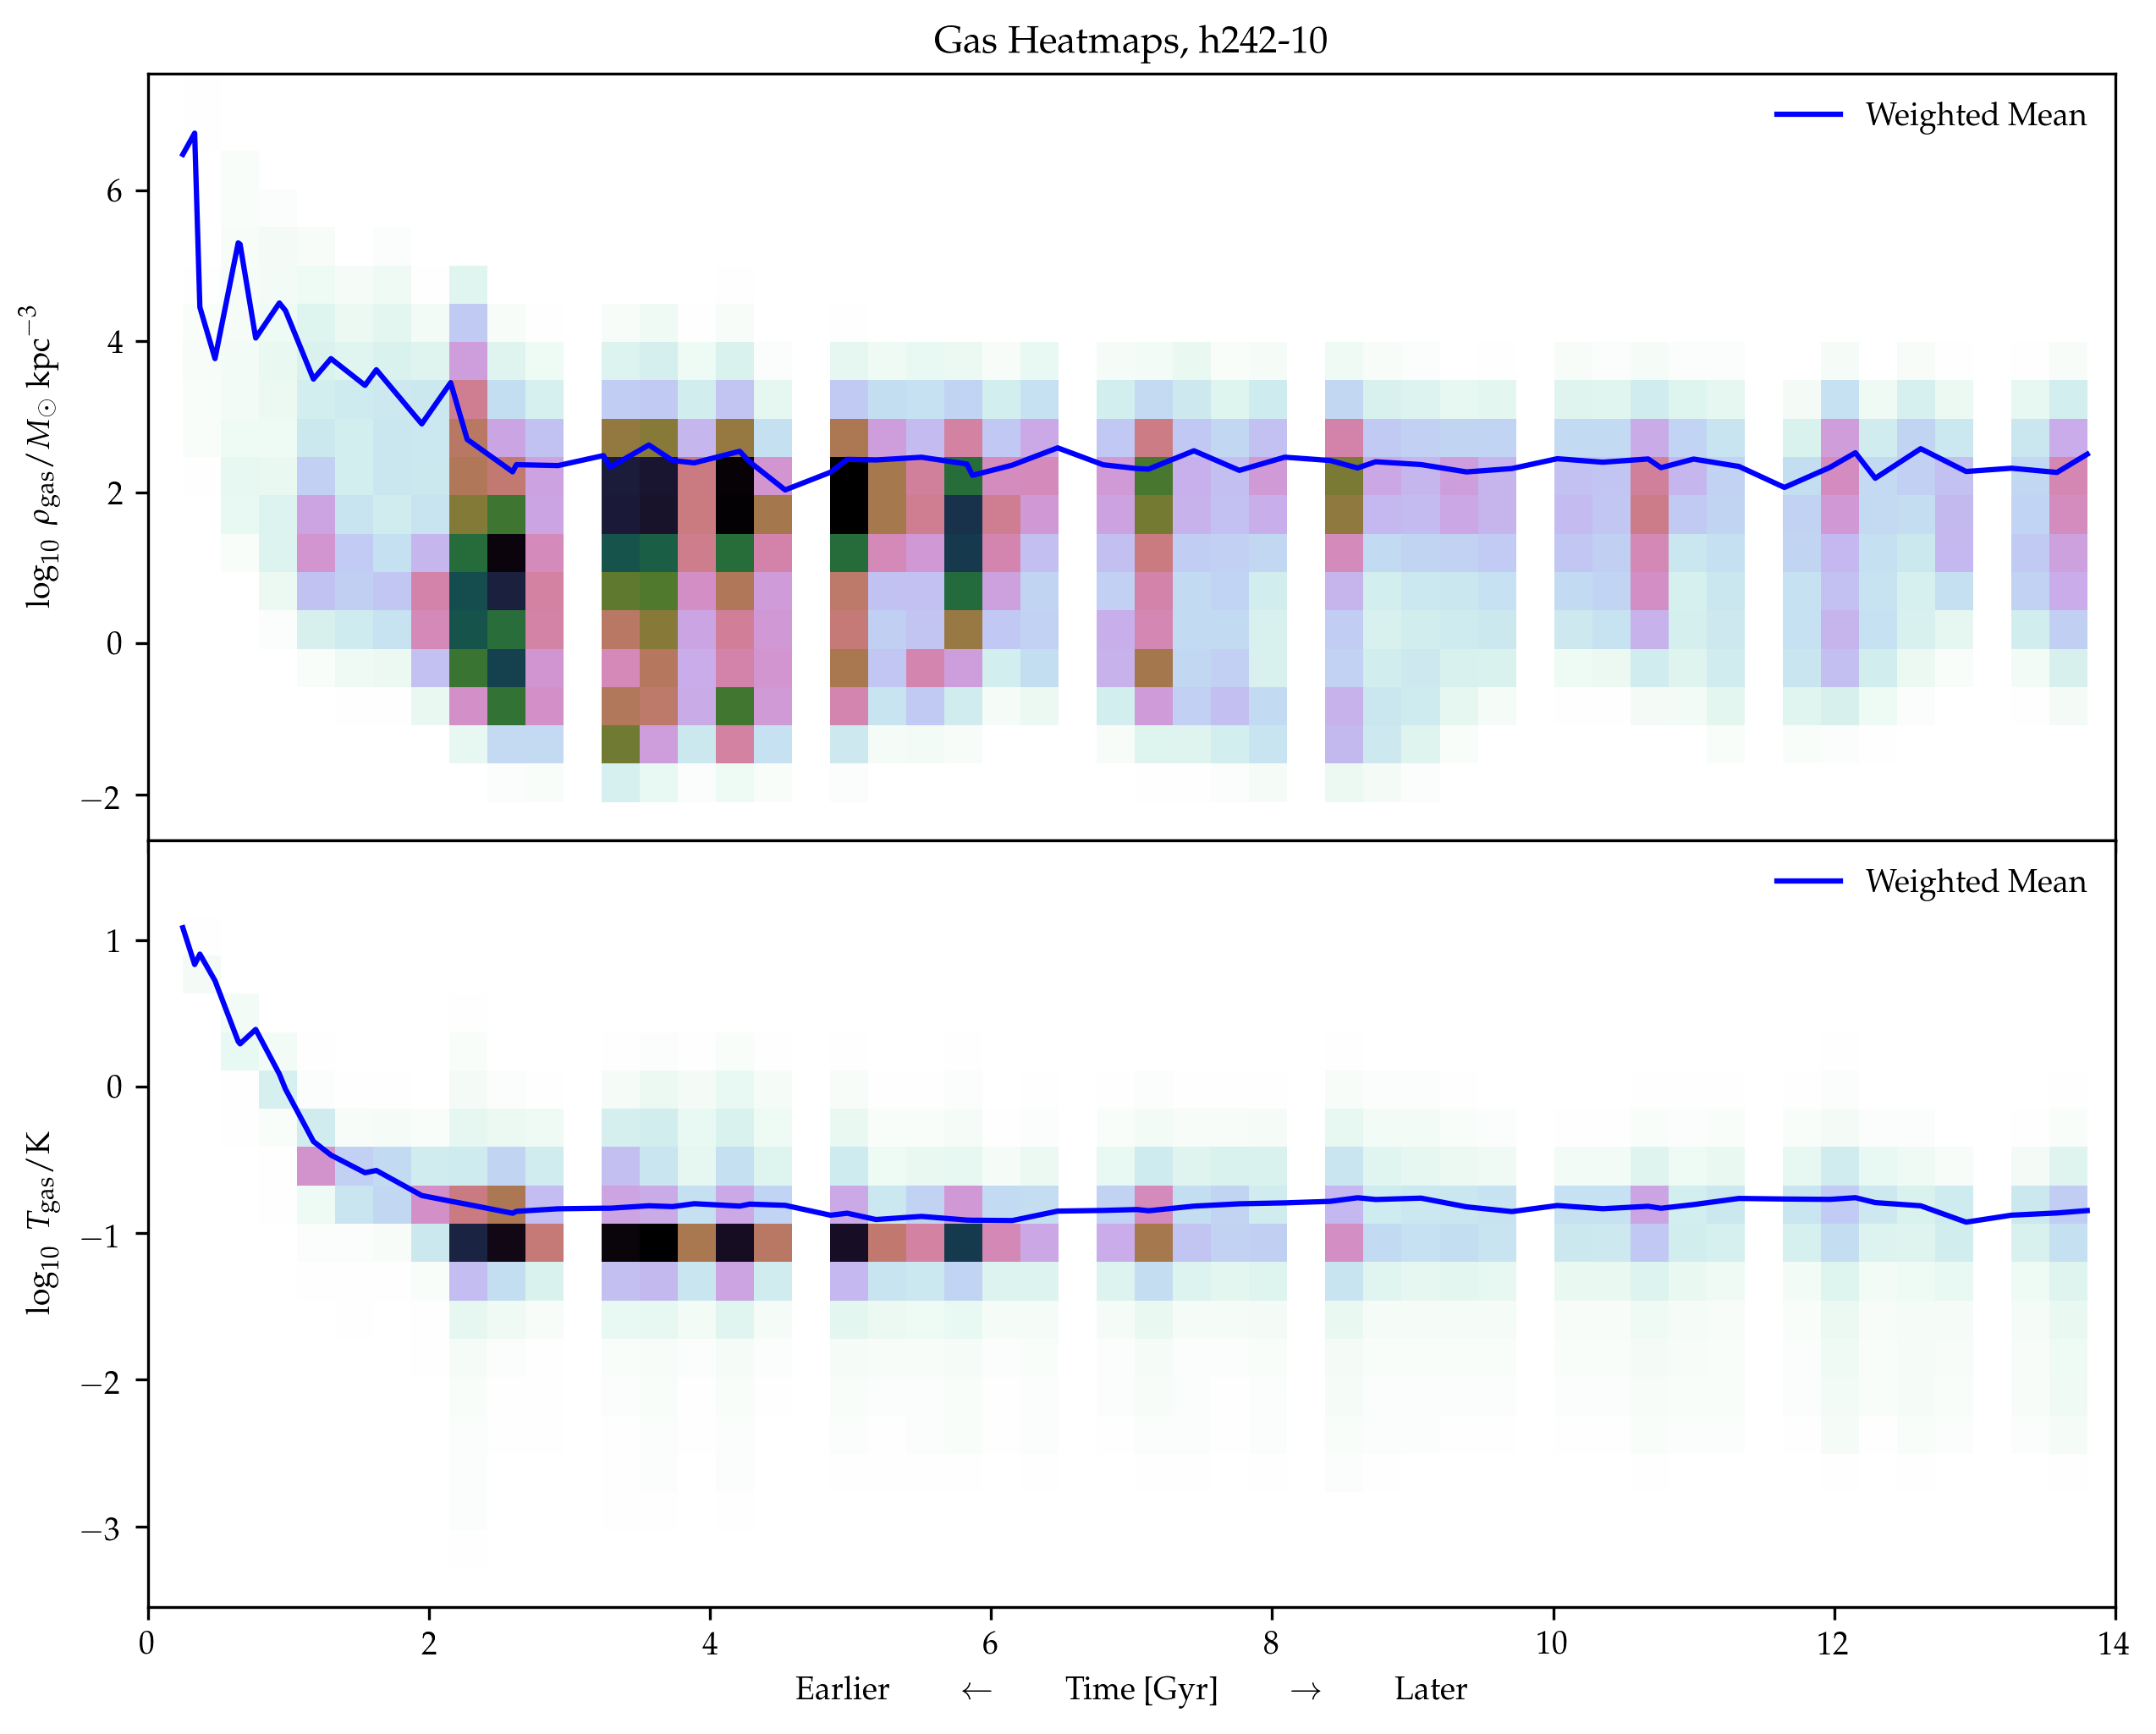

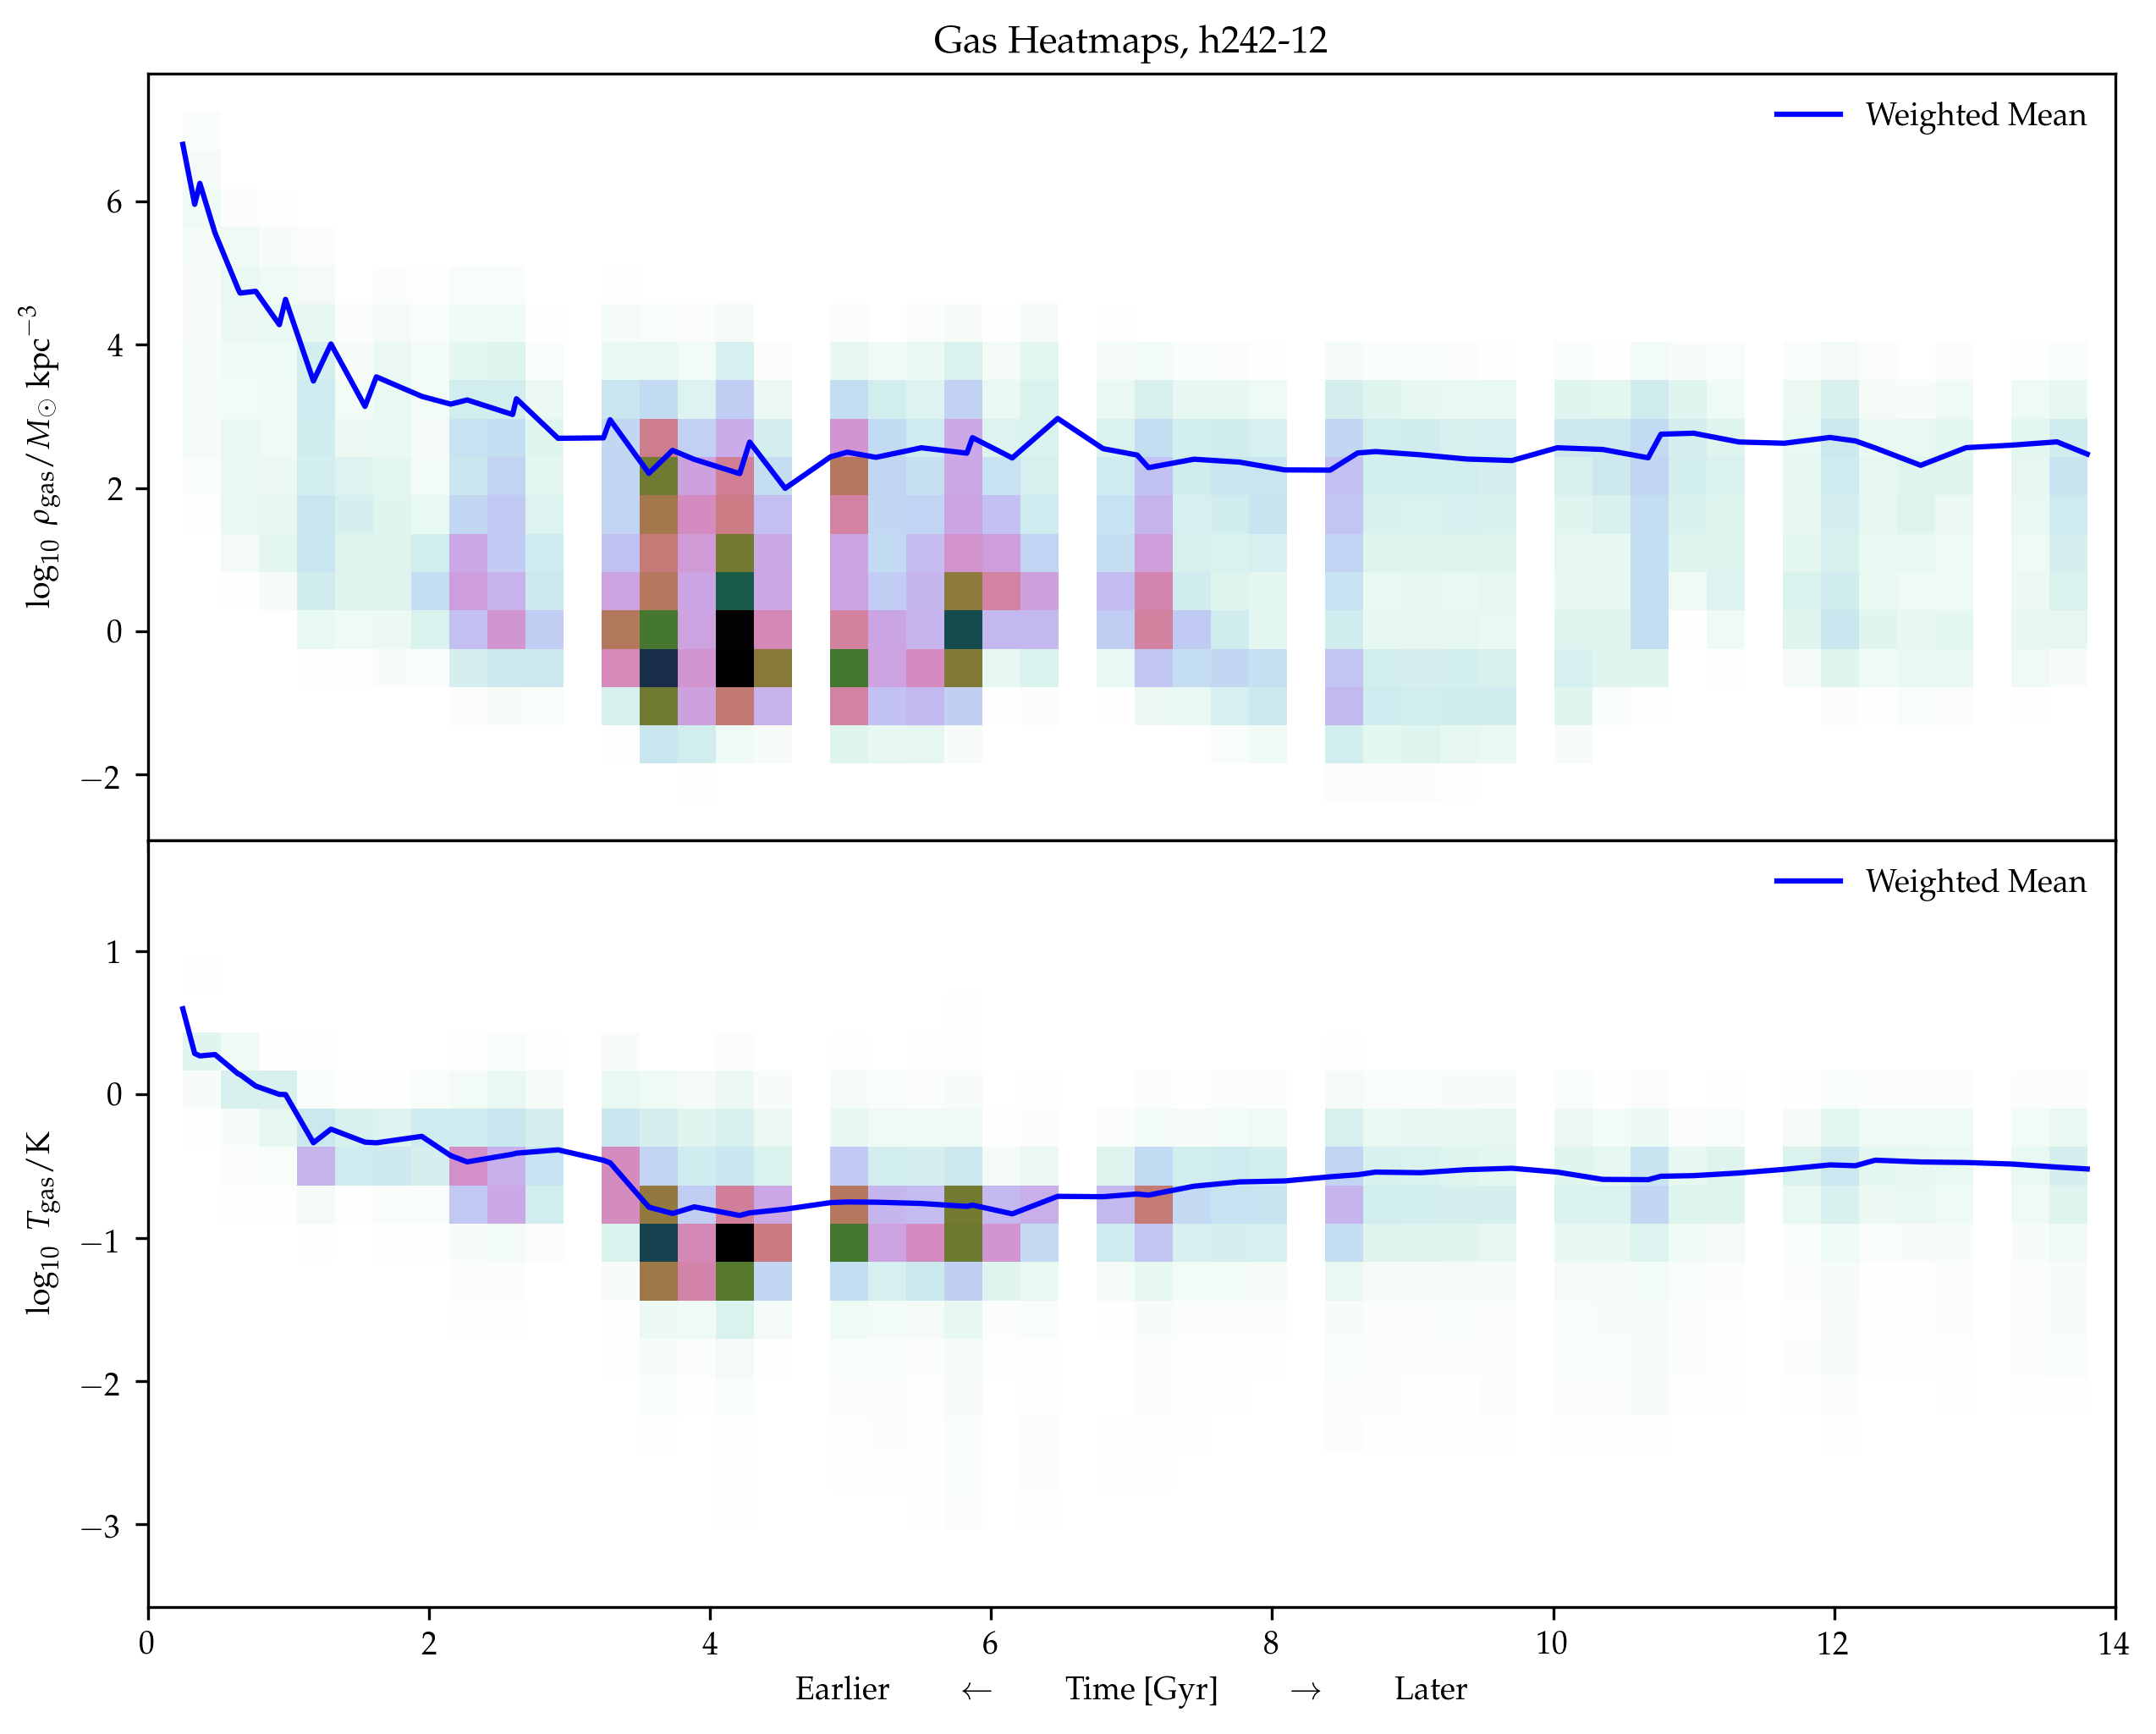

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


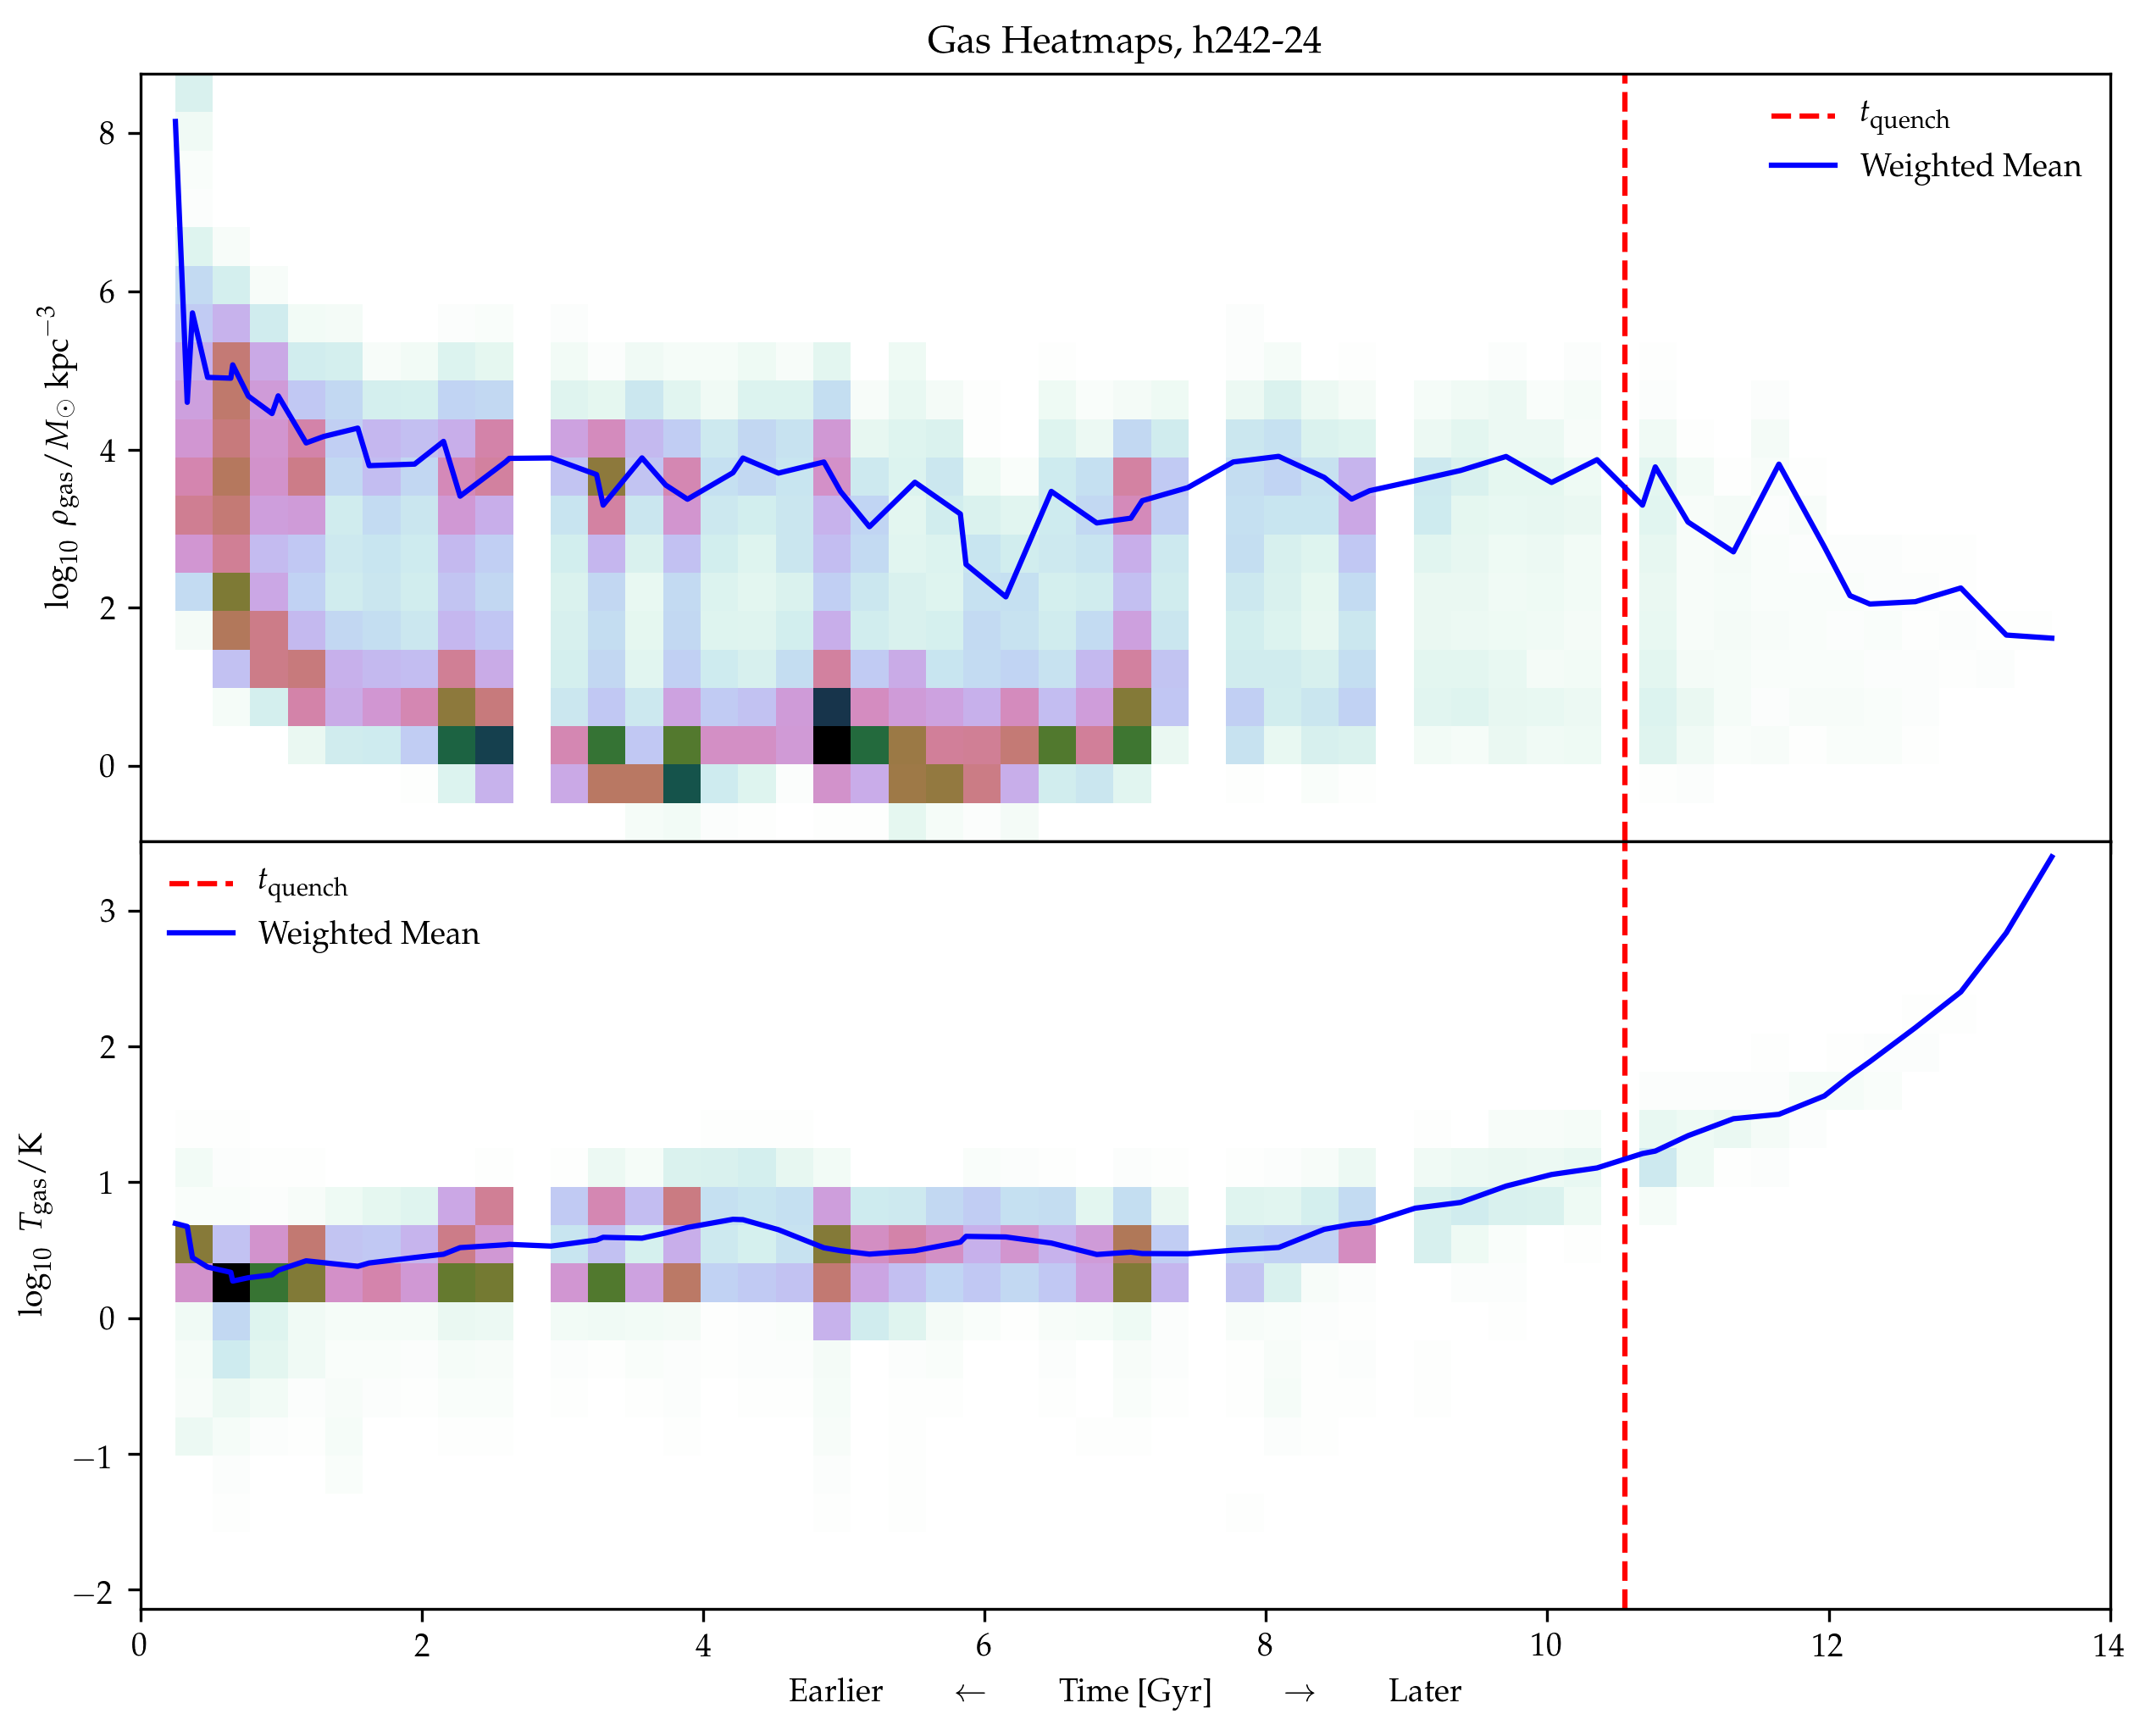

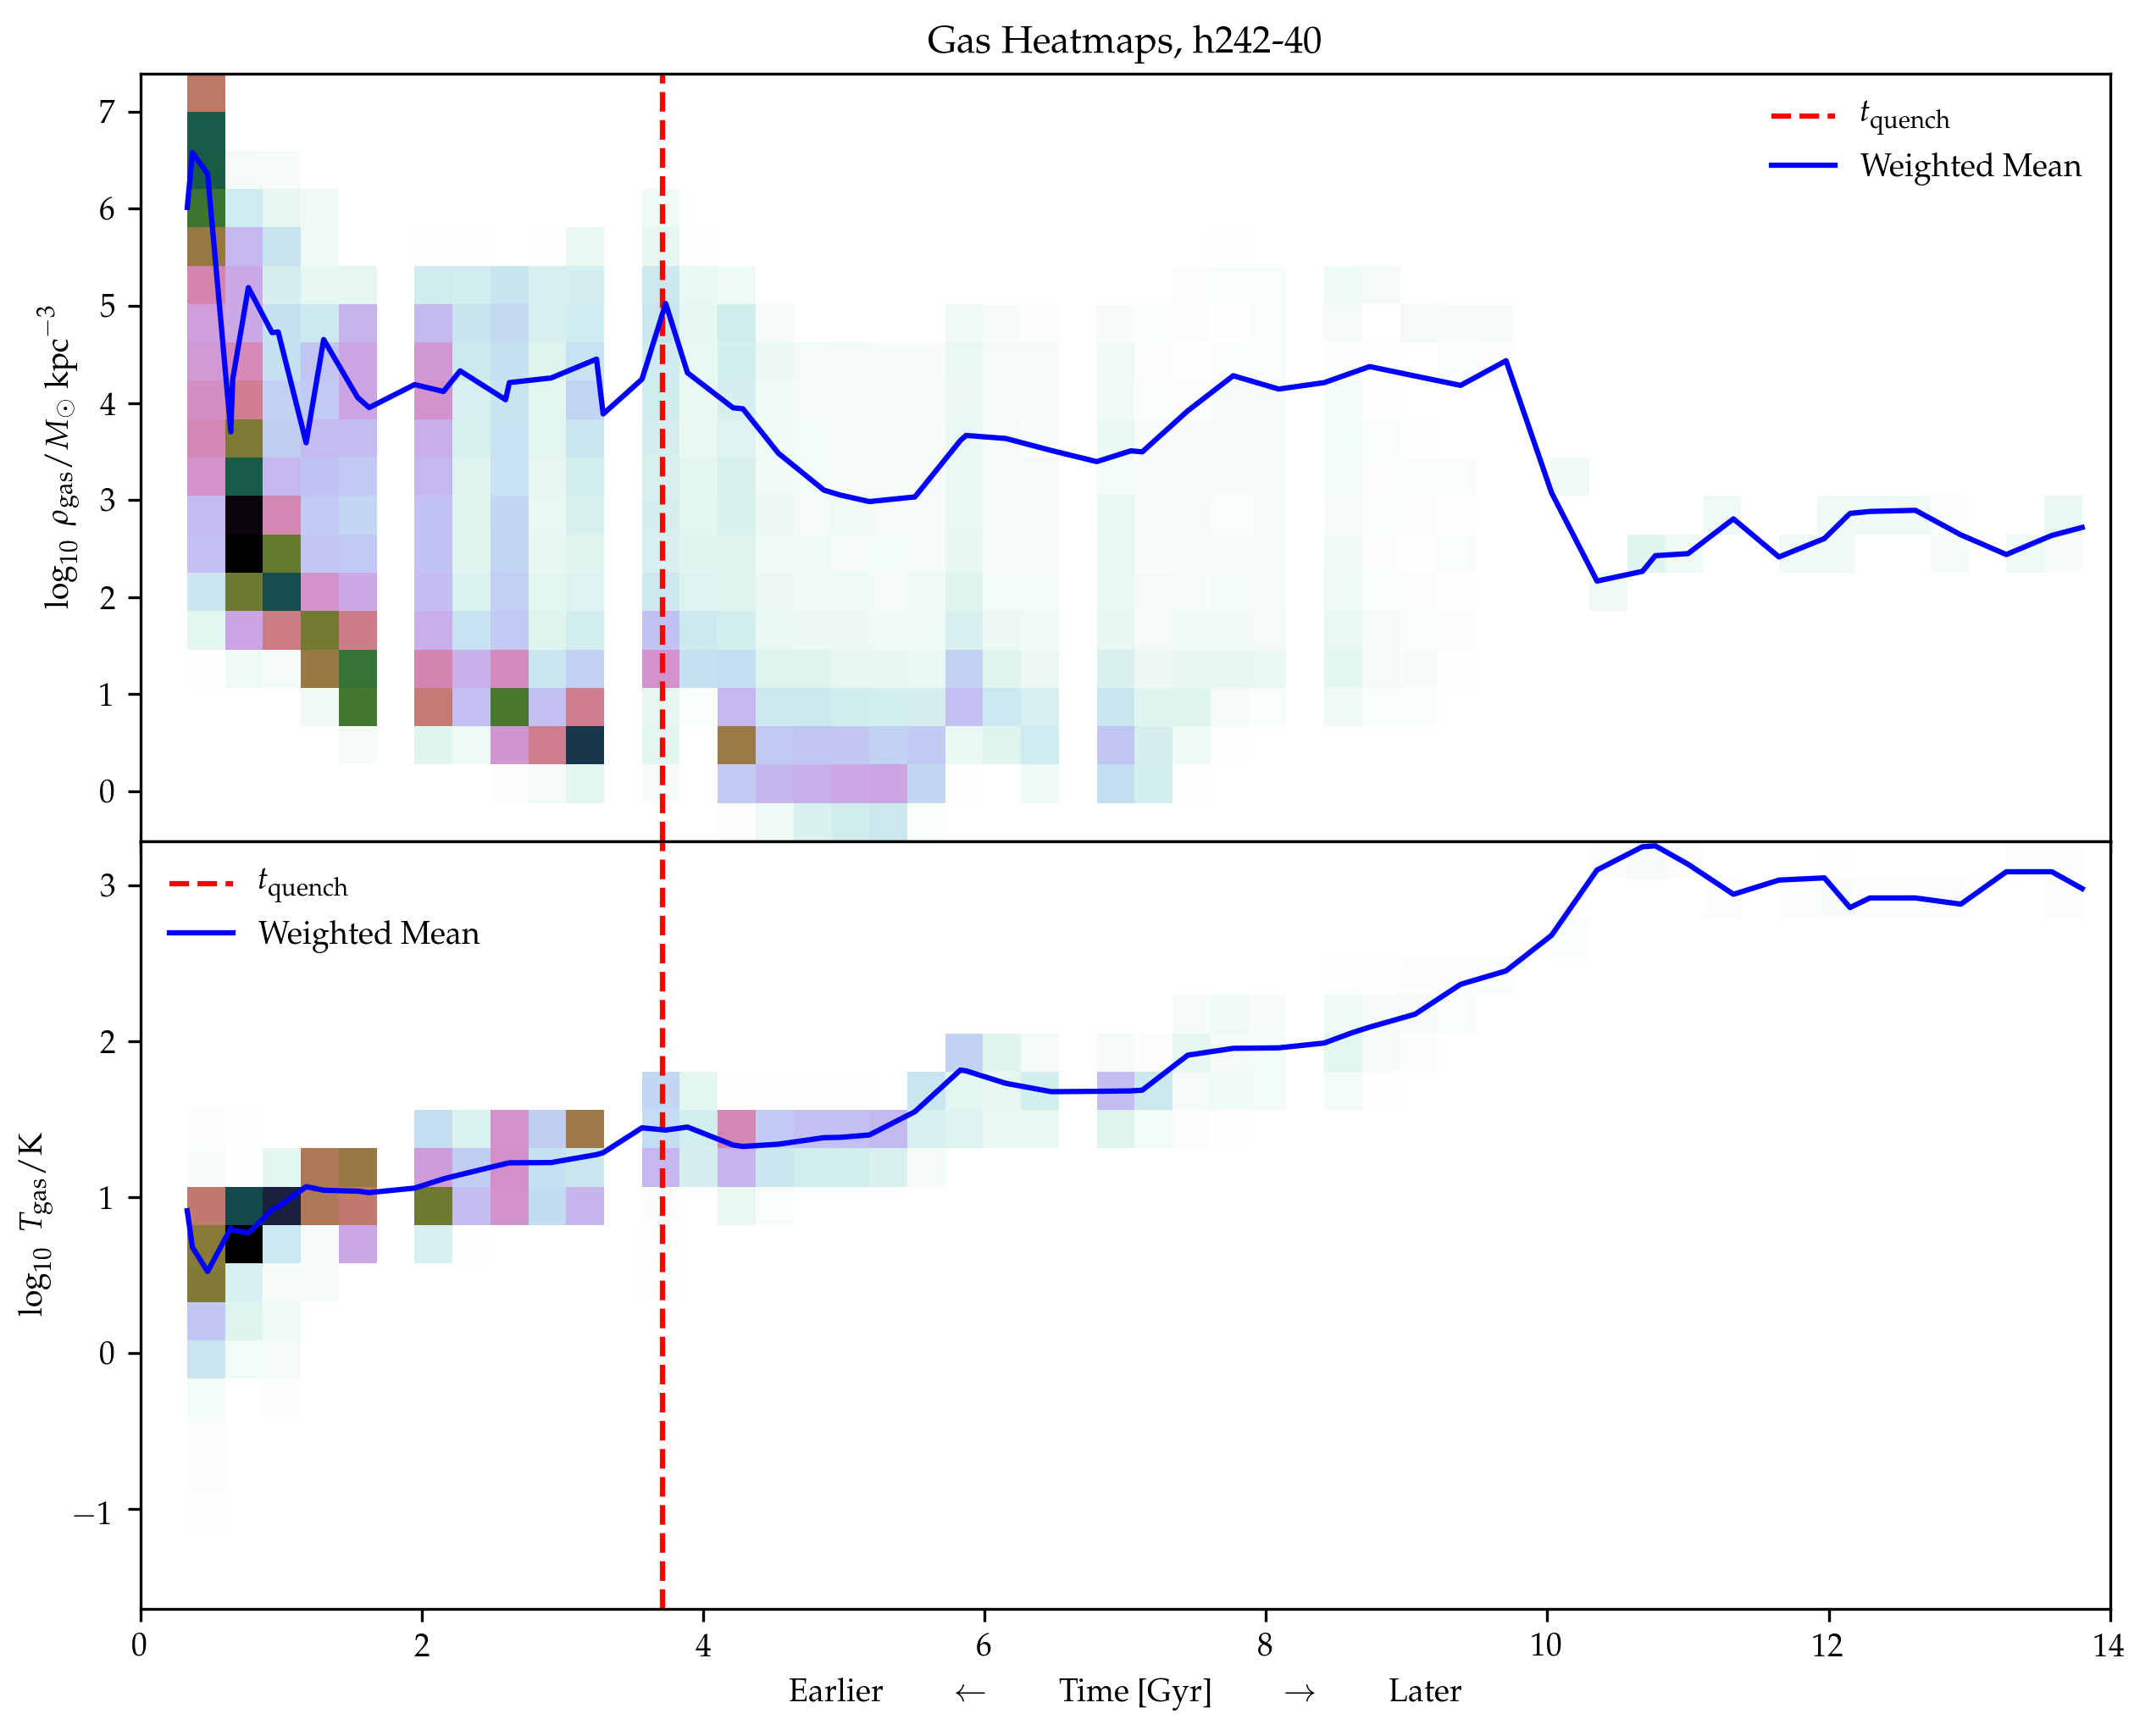

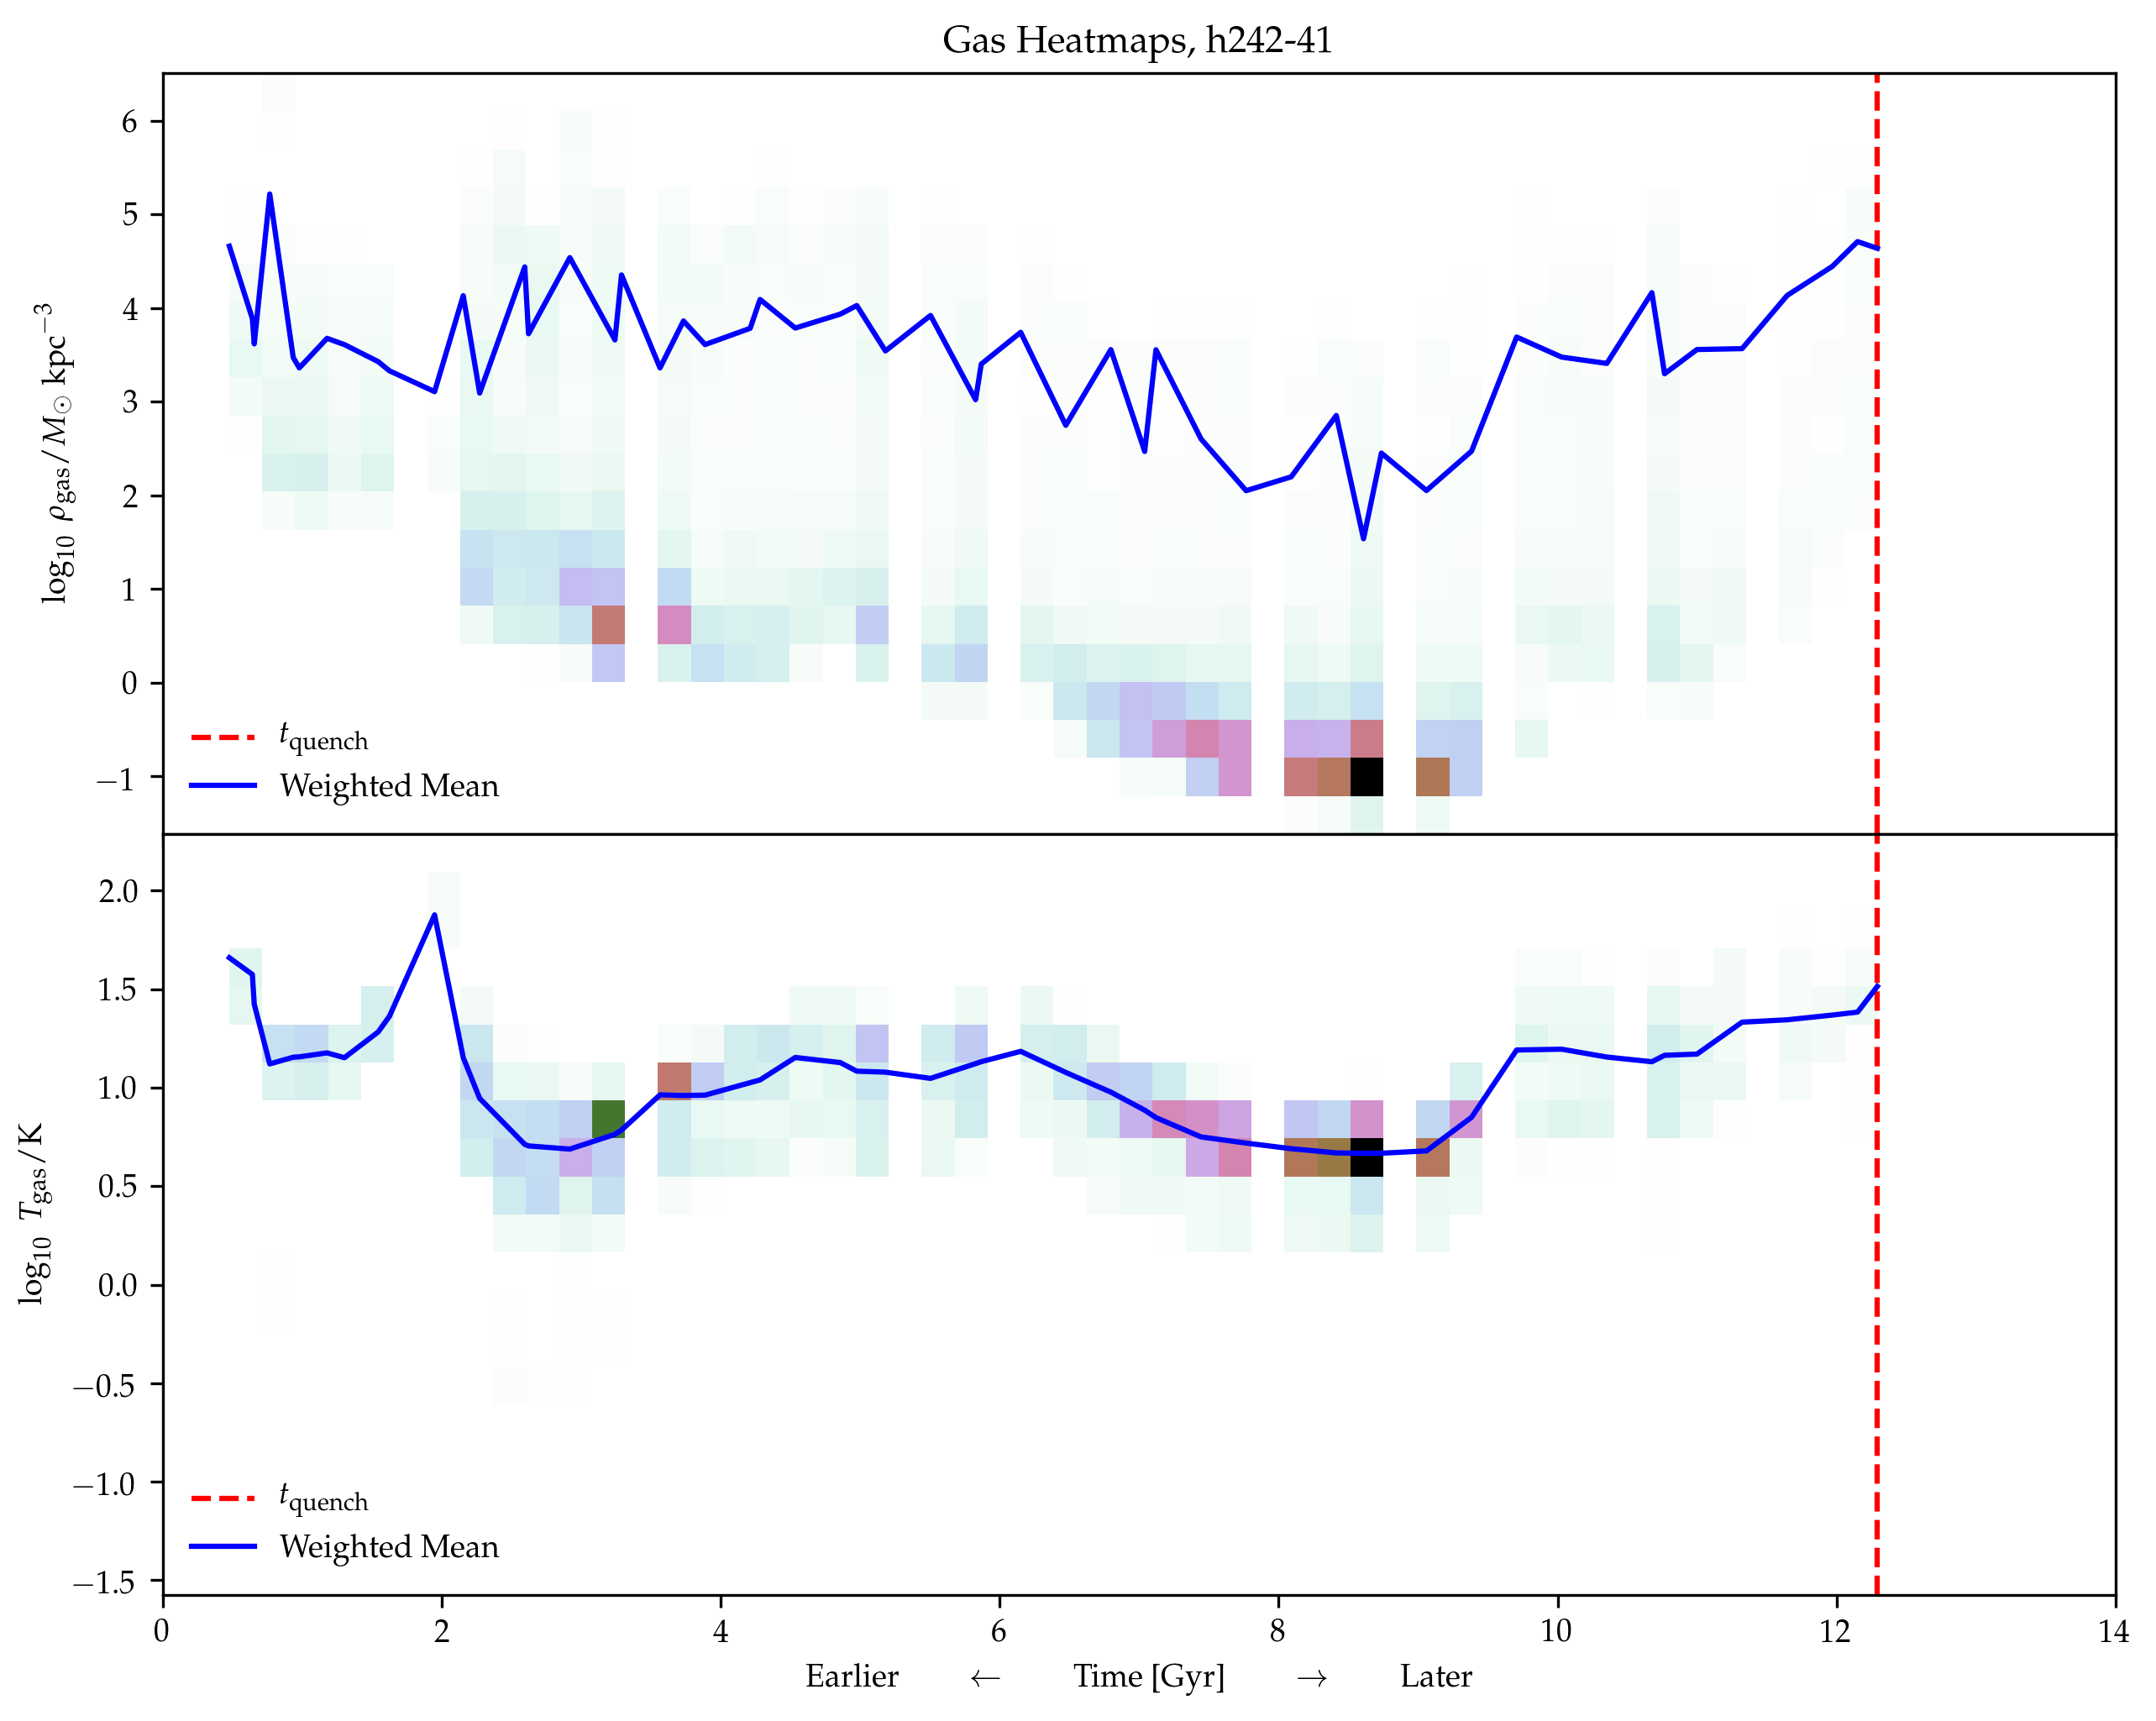

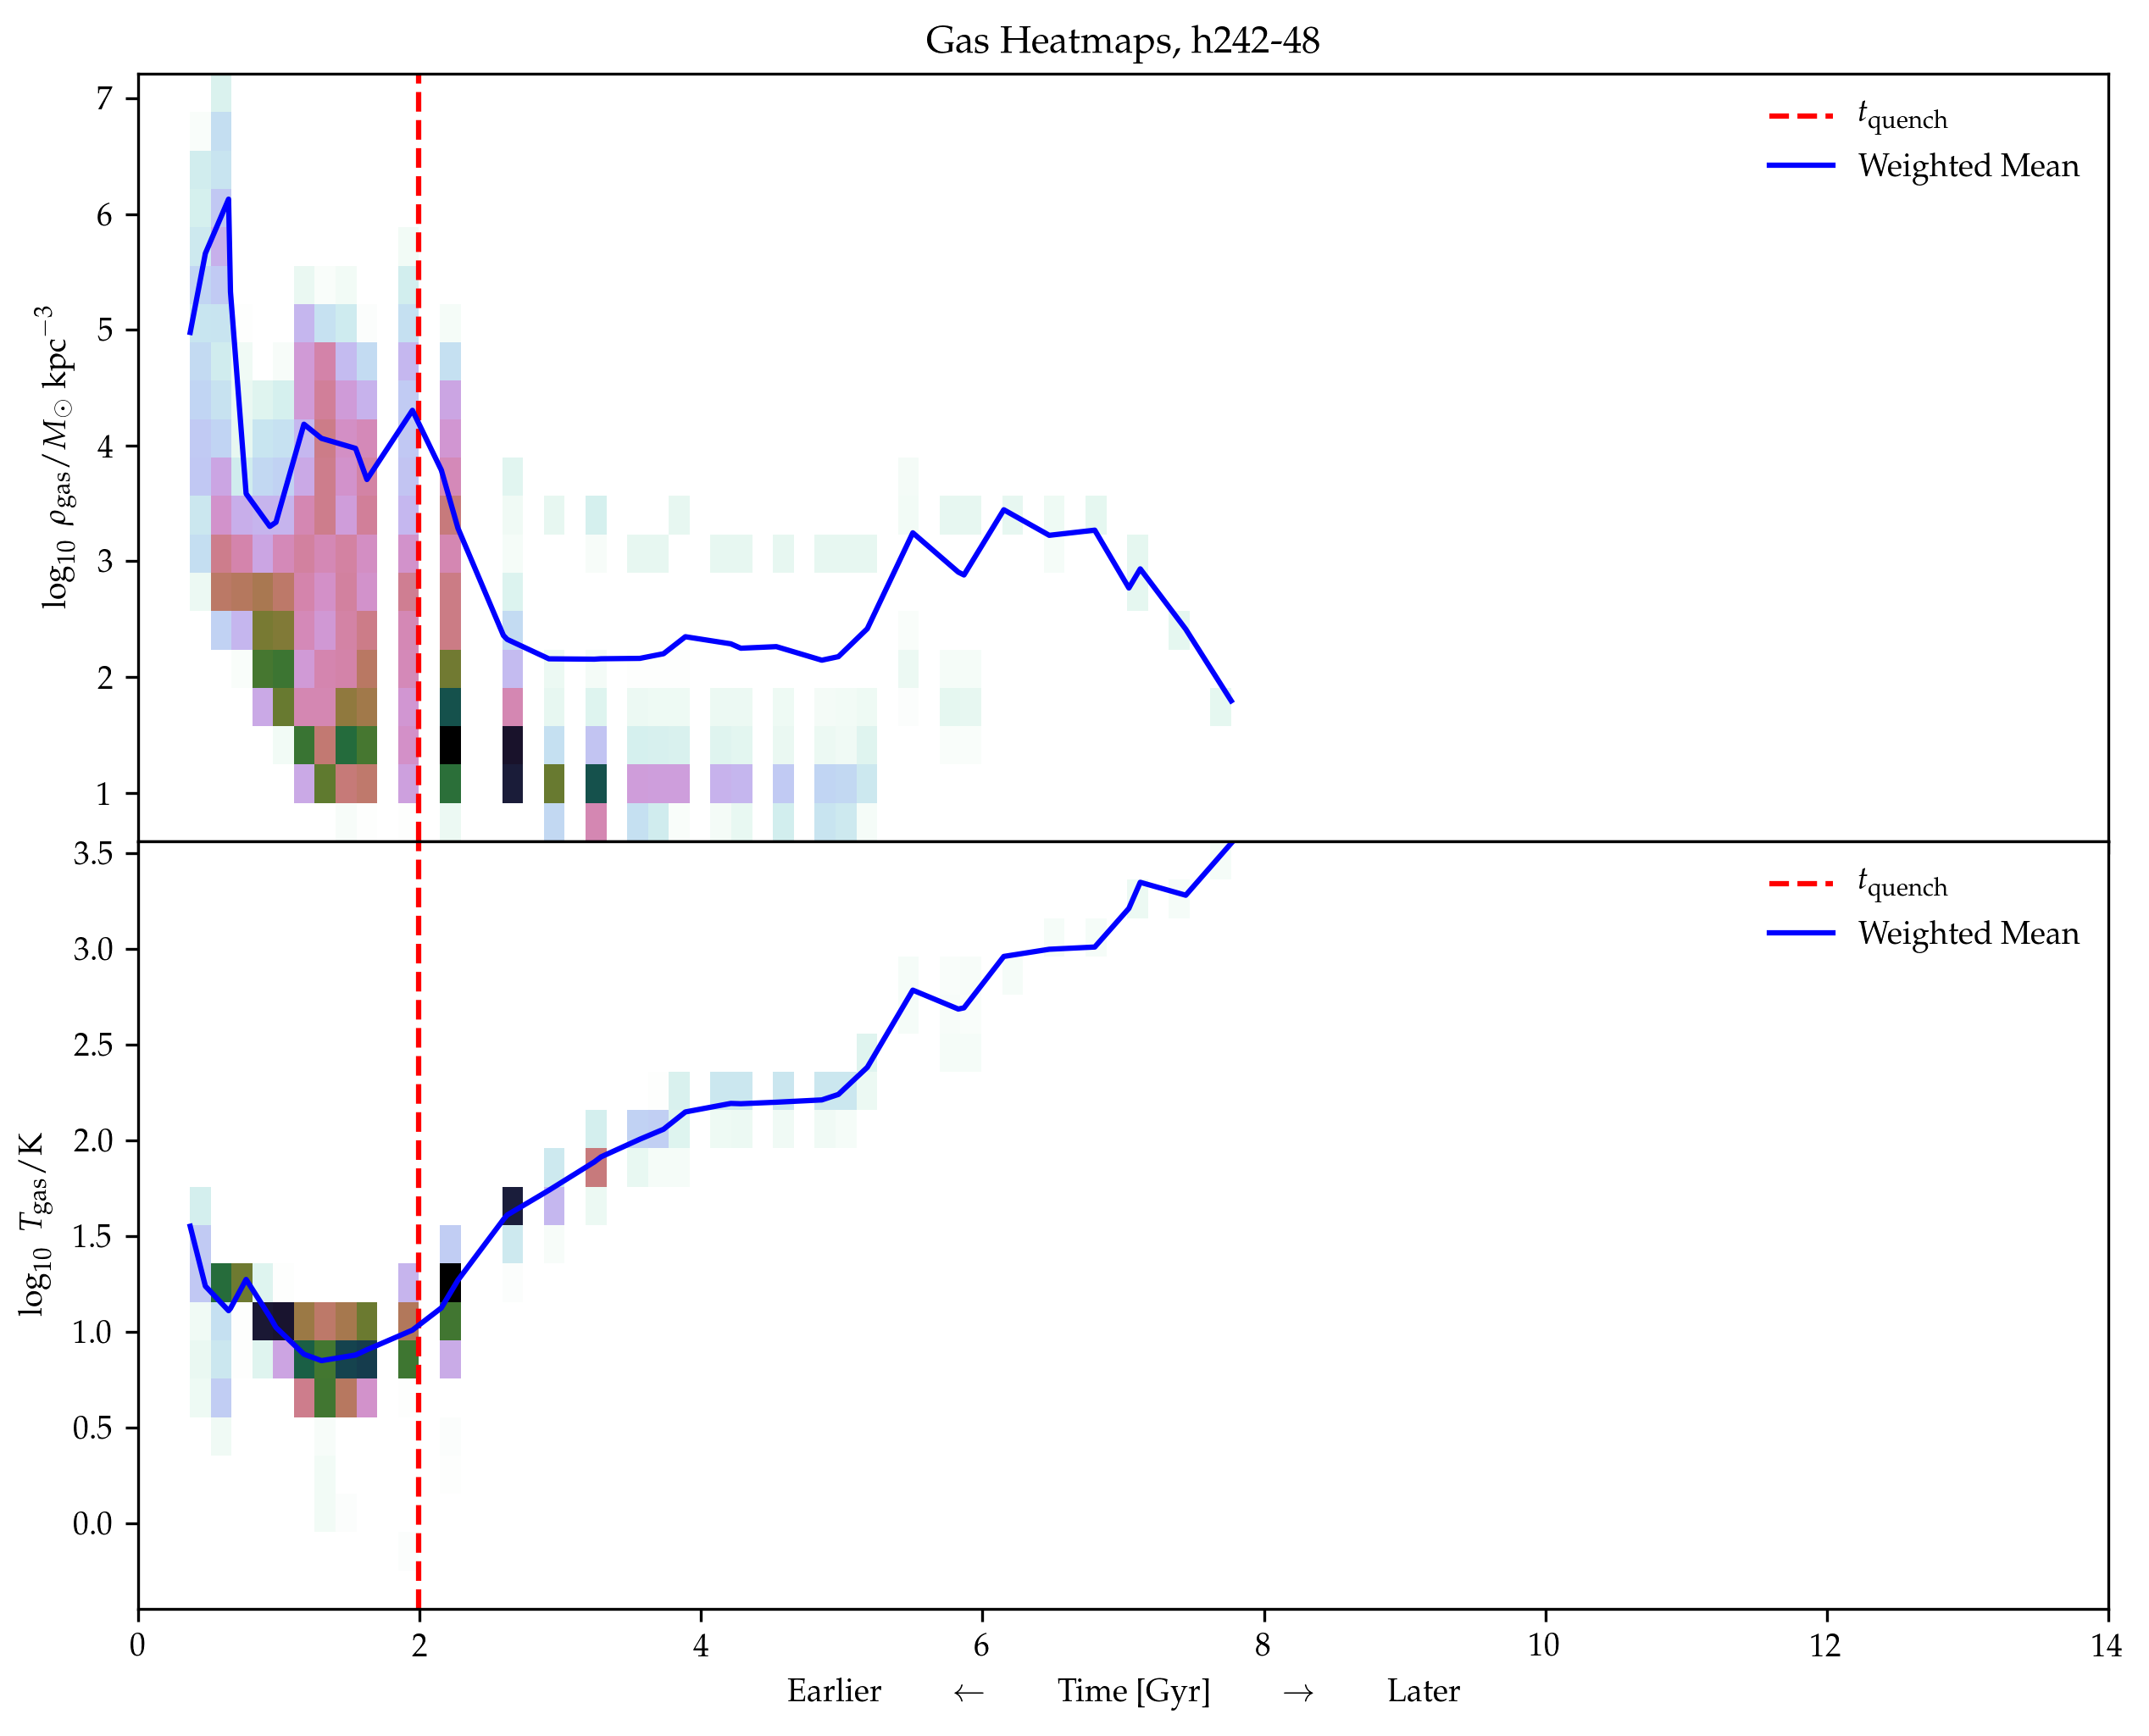

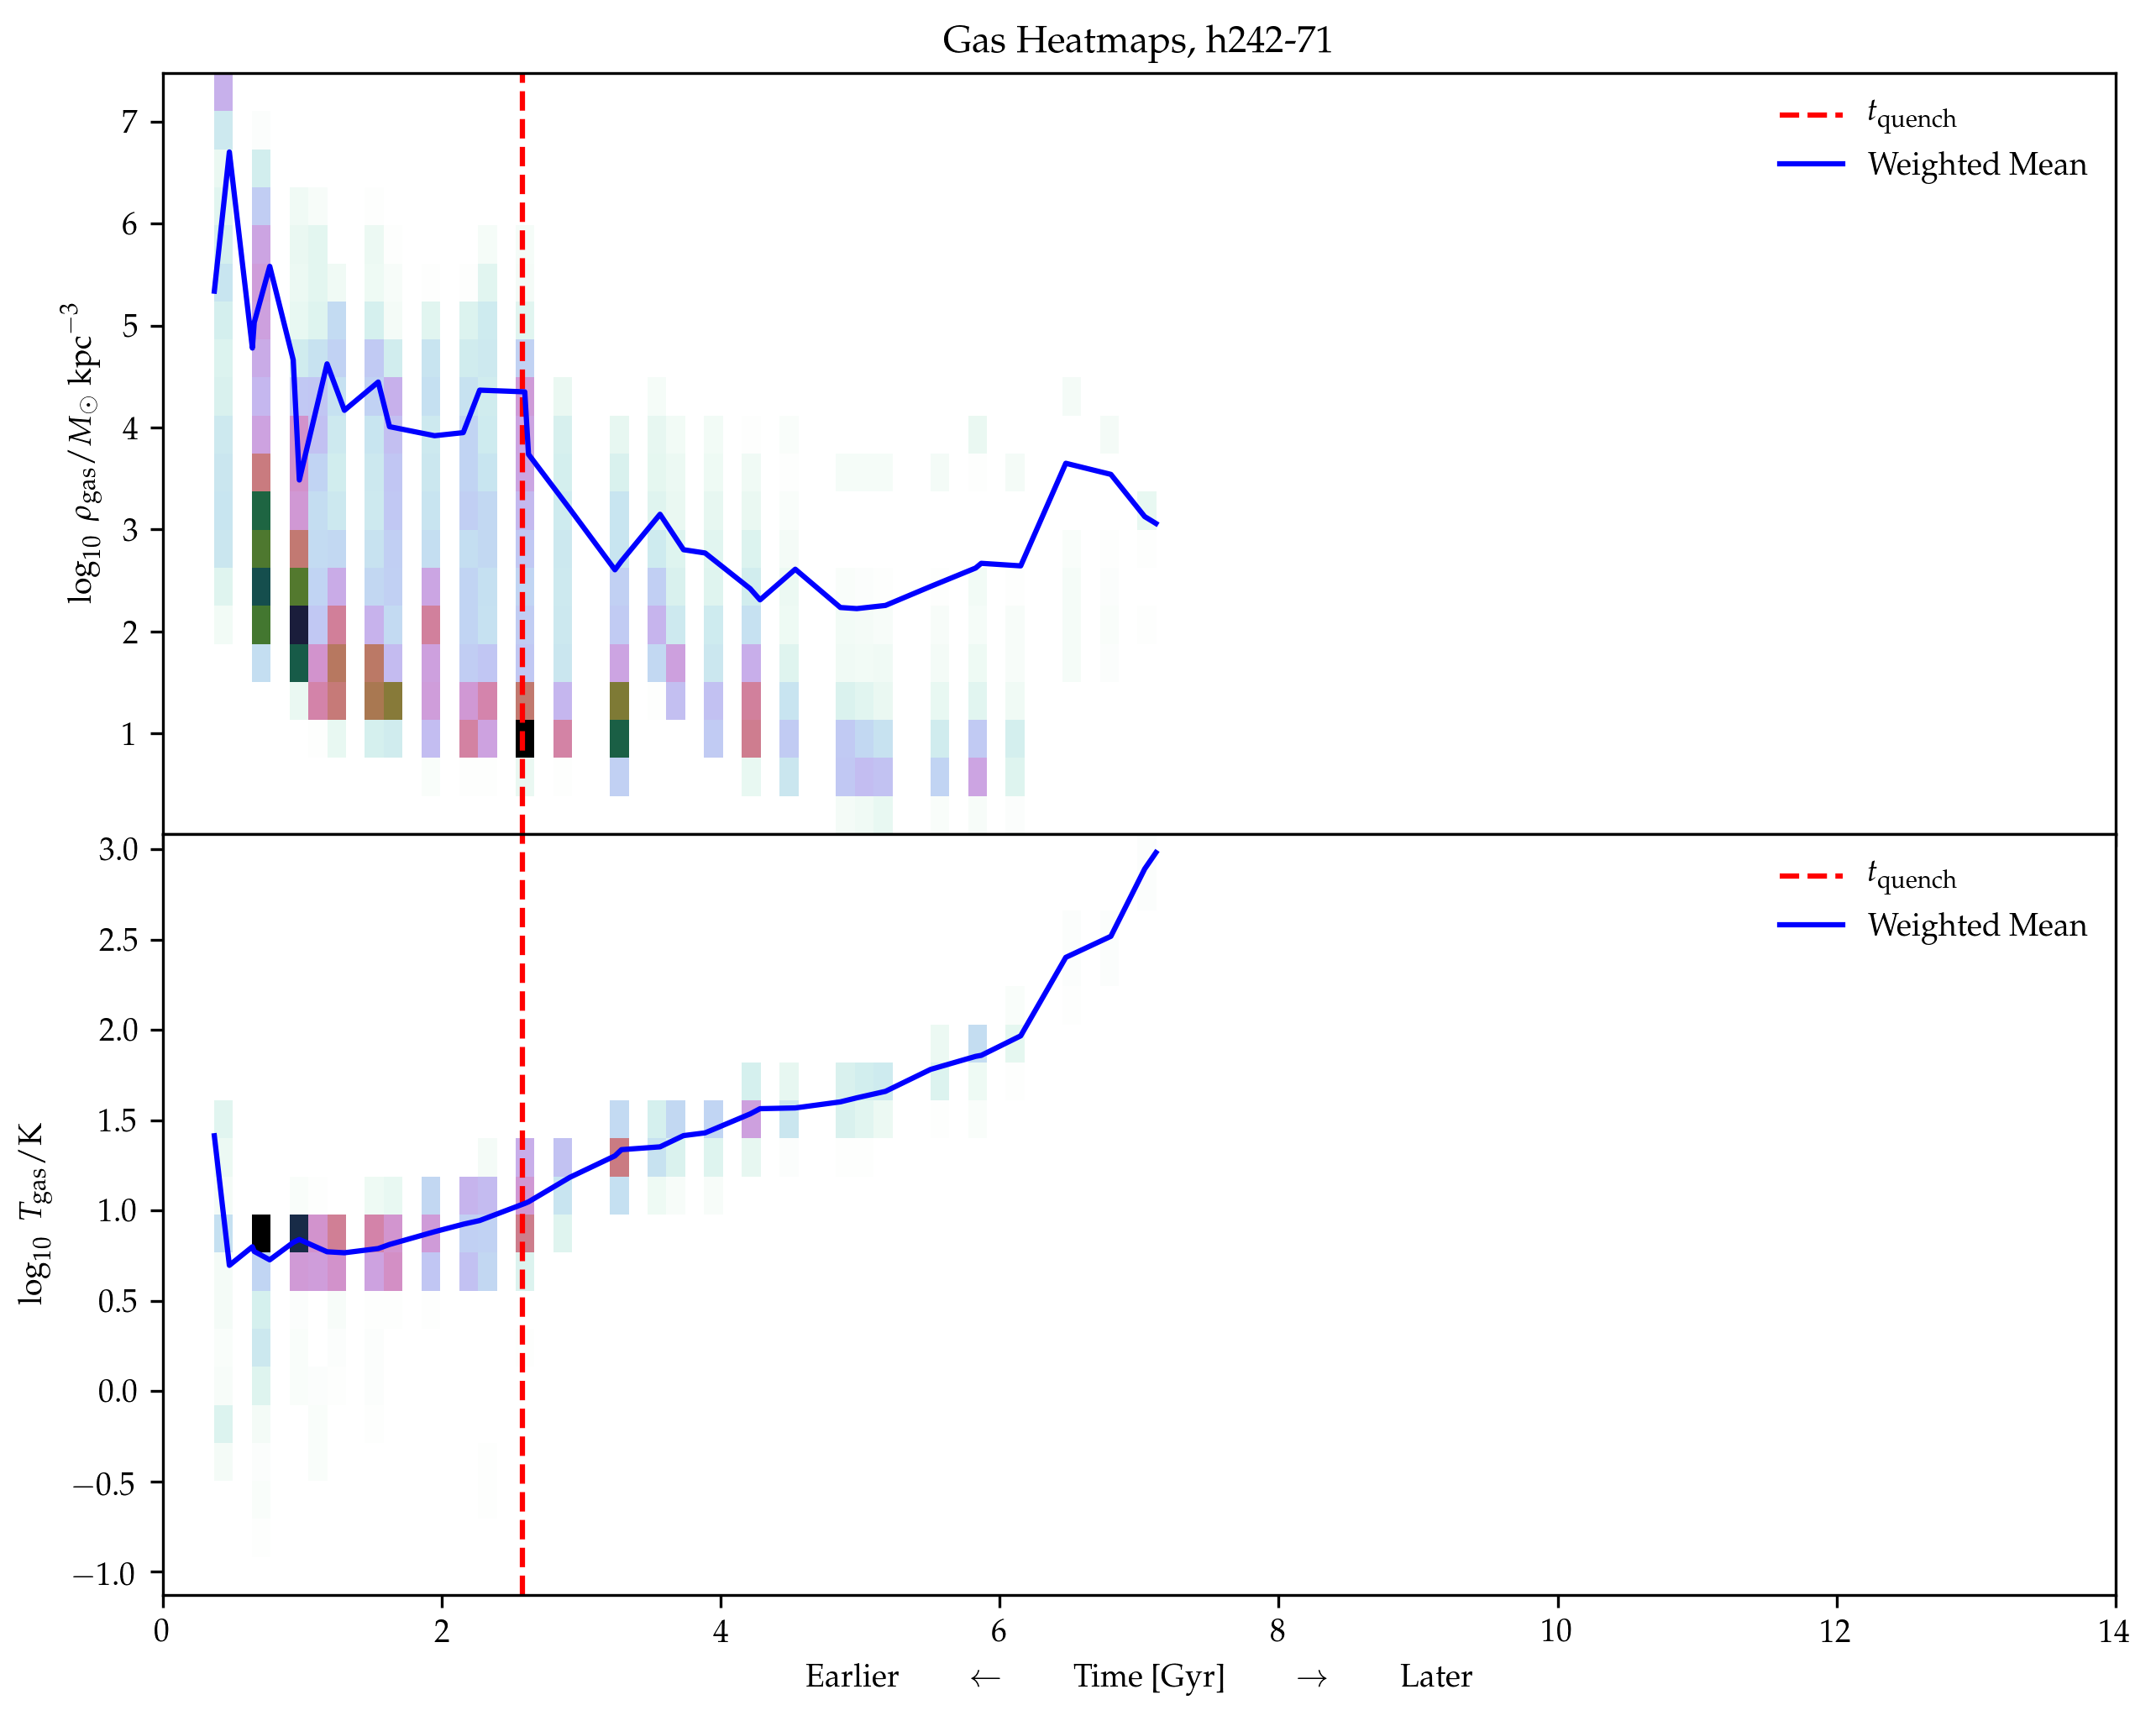

In [309]:
sim = 'h242'
data = read_timesteps(sim)
print(list(np.unique(data.z0haloid)))

for haloid in [10, 12, 24, 40, 41, 48, 71]:
    d = data[data.z0haloid==haloid]
    
    # determine t_quench
    timescales = read_timescales()
    timescales = timescales[(timescales.sim == sim) & (timescales.haloid==haloid)]
    tquench = timescales.tquench.tolist()[0]
    tquench = 13.800797497330507 - tquench
    
    # get distributions of gas density
    times, rhos, masses, weights = np.array([]), np.array([]), np.array([]), np.array([])
    for time, rho, mass in zip(d.time, d.gas_rho, d.gas_mass):
        if len(rho) != 0:
            rhos = np.append(rhos, rho)
            masses = np.append(masses, mass)
            weights = np.append(weights, mass/np.sum(mass))
            times = np.append(times, [time]*len(rho))

    
    rho_mean = [np.log10(np.mean(rho*mass/np.sum(mass))) for rho, mass in zip(d.gas_rho, d.gas_mass)] 
    rho_mean_unw = [np.log10(np.mean(rho)) for rho in d.gas_rho]
    
    rhos_heatmap, xedges, yedges = np.histogram2d(times, np.log10(rhos*weights), bins=(50,20))
    rhos_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # get distributions of gas temperature
    times, temps, masses, weights = np.array([]), np.array([]), np.array([]), np.array([])
    for time, temp, mass in zip(d.time, d.gas_temp, d.gas_mass):
        if len(temp) != 0:
            masses = np.append(masses, mass)
            temps = np.append(temps, temp)
            weights = np.append(weights, mass/np.sum(mass))
            times = np.append(times, [time]*len(temp))

    temp_mean = [np.log10(np.mean(temp*mass/np.sum(mass))) for temp, mass in zip(d.gas_temp, d.gas_mass)]
    temp_mean_unw = [np.log10(np.mean(temp)) for temp in d.gas_temp]

    temps_heatmap, xedges, yedges = np.histogram2d(times, np.log10(temps*weights), bins=(50,20))
    temps_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig, ax = plt.subplots(2,1,dpi=300,figsize=(10,8),sharex=True)
    
    ax[0].set_title(f'Gas Heatmaps, {sim}-{haloid}')
    if not np.isnan(tquench):
        ax[0].plot([tquench,tquench], [np.min(np.log10(rhos*weights)), np.max(np.log10(rhos*weights))], 'r--', label='$t_{\mathrm{quench}}$')
    ax[0].imshow(rhos_heatmap.T, extent=rhos_extent, origin='lower', cmap='cubehelix_r', aspect='auto')
    ax[0].set_ylabel(r'$\log_{10}~\rho_{\mathrm{gas}} / M_{\odot}~\mathrm{kpc}^{-3}$')
    ax[0].set_xlim(0, 14)
    ax[0].plot(d.time, rho_mean, 'b-', label='Weighted Mean')
#     ax[0].plot(d.time, rho_mean_unw, 'b--', linewidth=0.5, label='Unweighted Mean')
    ax[0].legend(frameon=False)
    
    if not np.isnan(tquench):
        ax[1].plot([tquench,tquench], [np.min(np.log10(temps*weights)),np.max(np.log10(temps*weights))], 'r--', label='$t_{\mathrm{quench}}$')
    ax[1].imshow(temps_heatmap.T, extent=temps_extent, origin='lower', cmap='cubehelix_r', aspect='auto')
    ax[1].set_xlabel(r'Earlier $\qquad\leftarrow\qquad$ Time [Gyr] $\qquad\rightarrow\qquad$ Later')
    ax[1].set_ylabel(r'$\log_{10}~T_{\mathrm{gas}} / \mathrm{K}$')
    ax[1].set_xlim(0,14)
    ax[1].plot(d.time, temp_mean, 'b-', label='Weighted Mean')
#     ax[1].plot(d.time, temp_mean_unw, 'b--', linewidth=0.5, label='Unweighted Mean')
    ax[1].legend(frameon=False)
    
    plt.subplots_adjust(hspace=0.)
    plt.show()

[10.0, 12.0, 24.0, 30.0, 34.0, 40.0, 41.0, 44.0, 48.0, 49.0, 71.0, 78.0, 80.0, 86.0, 165.0, 223.0, 439.0]
38


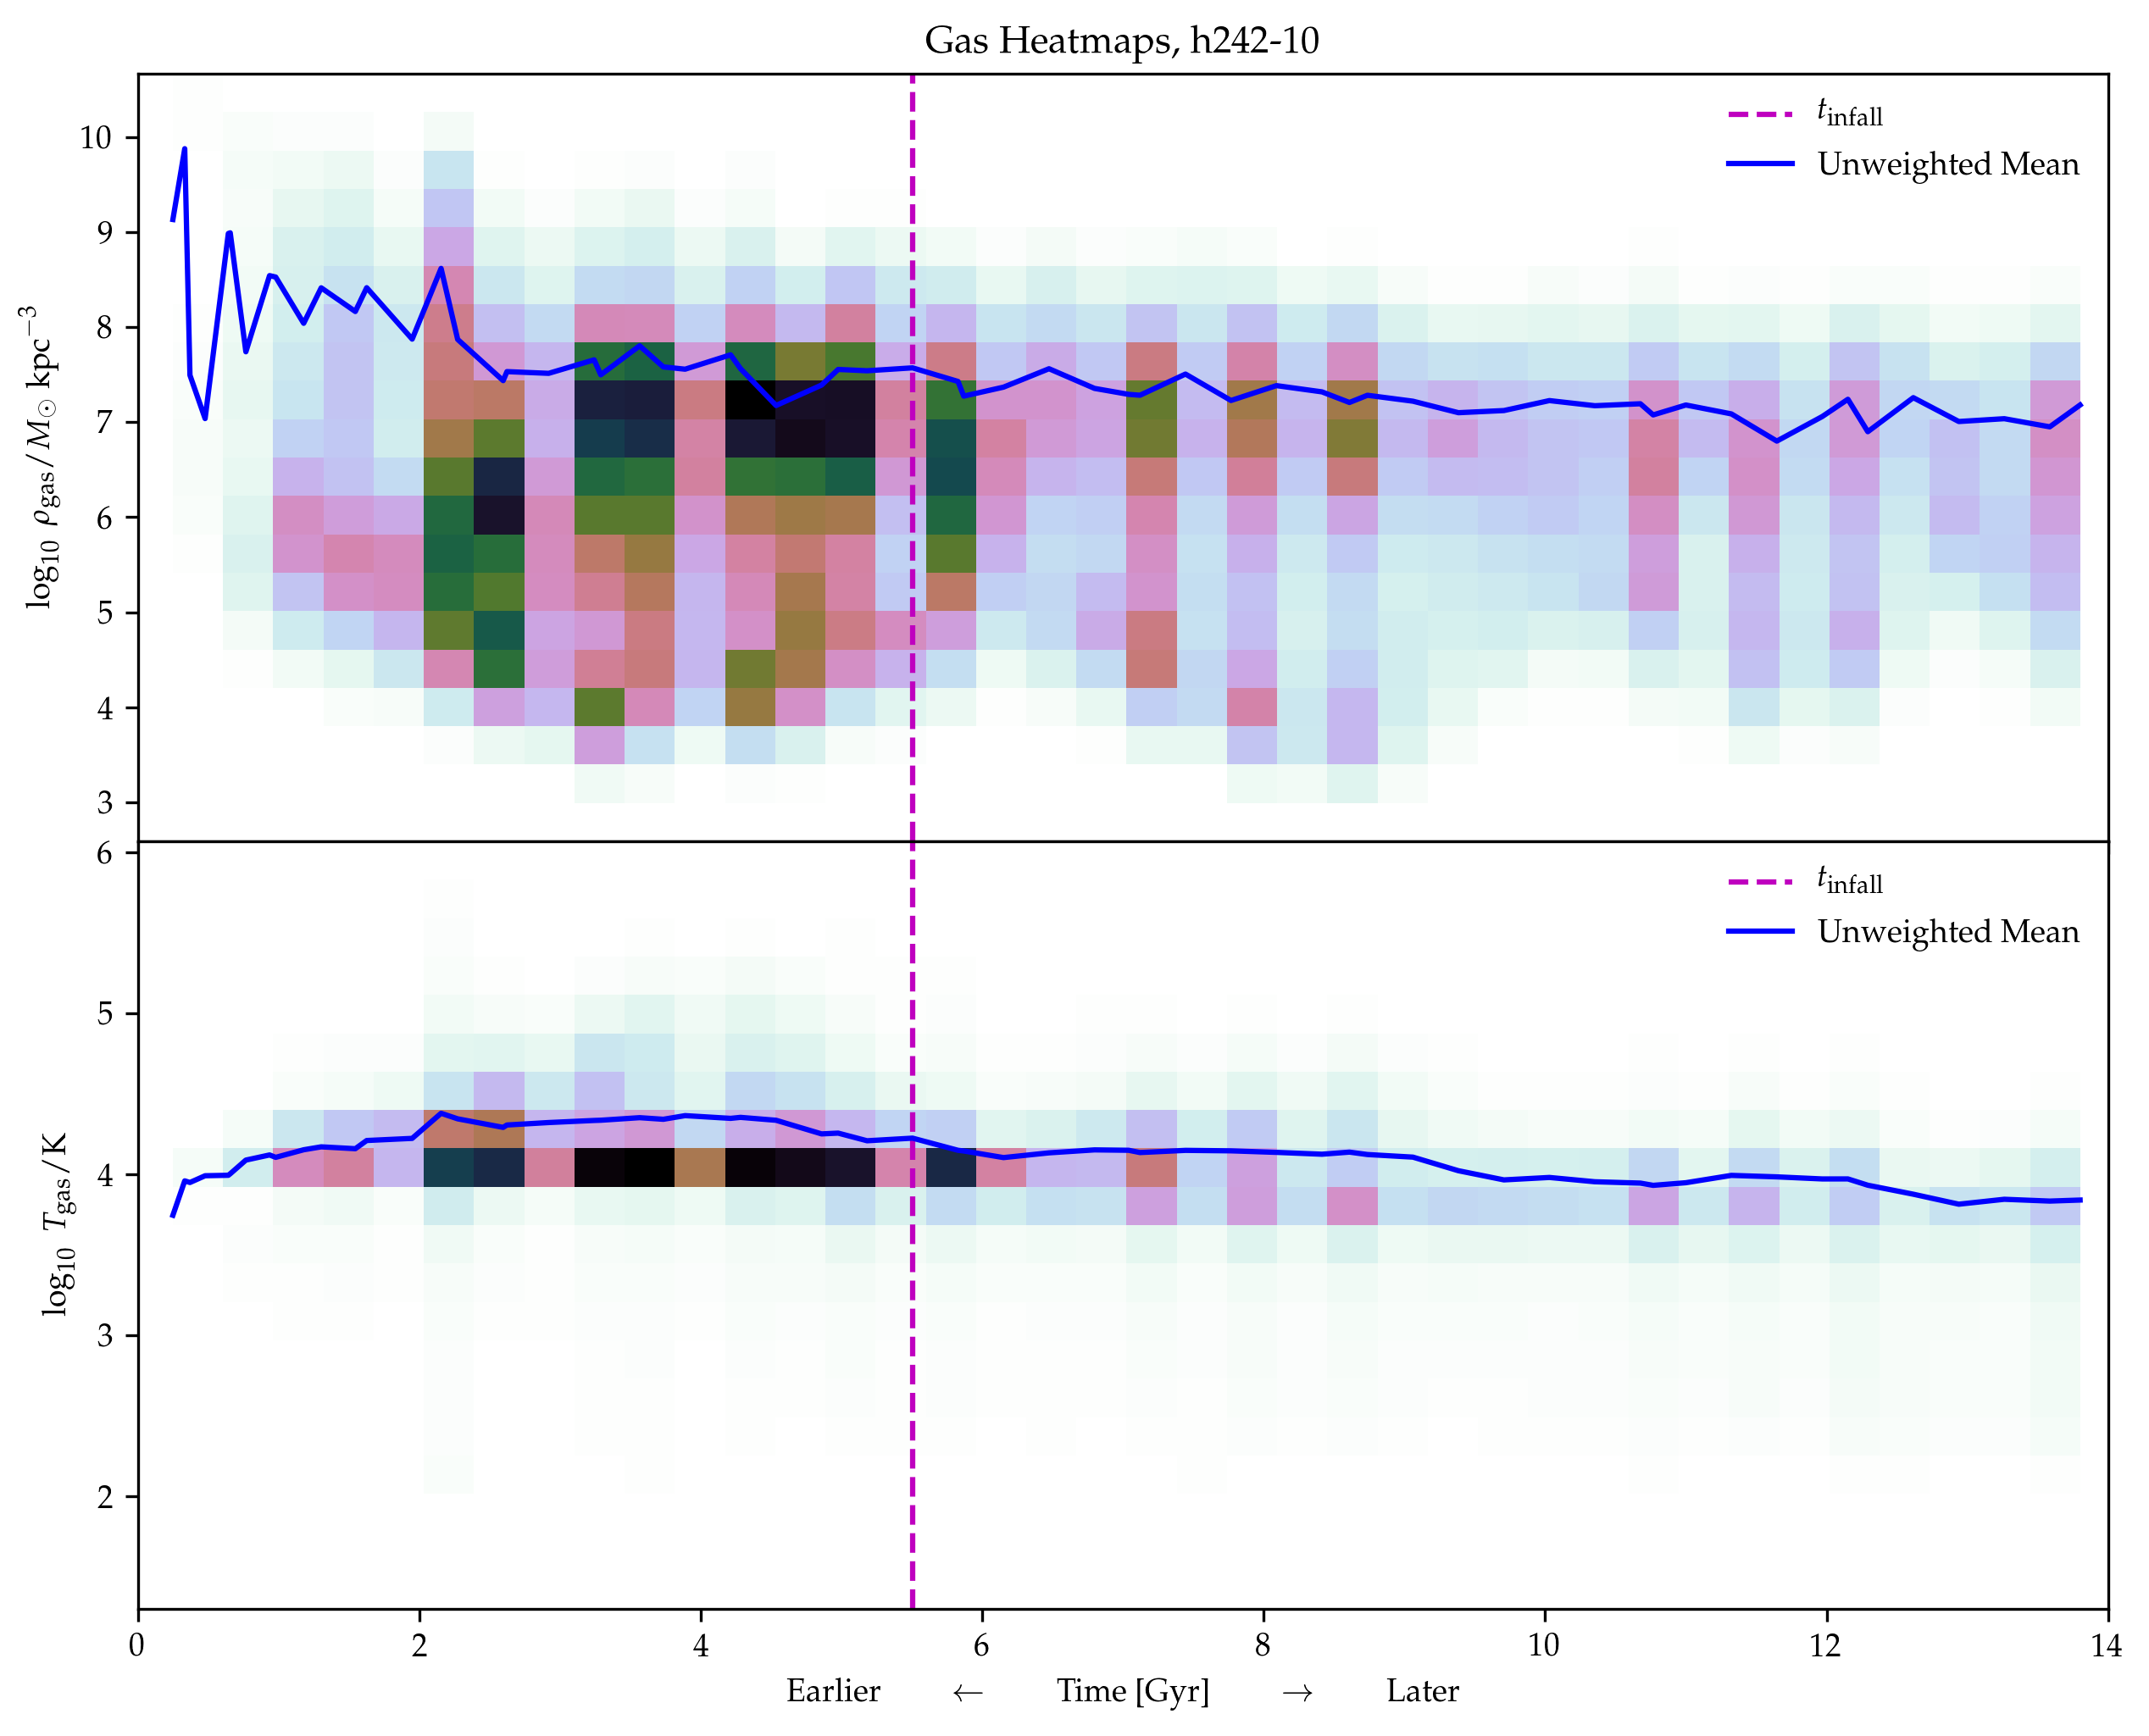

38


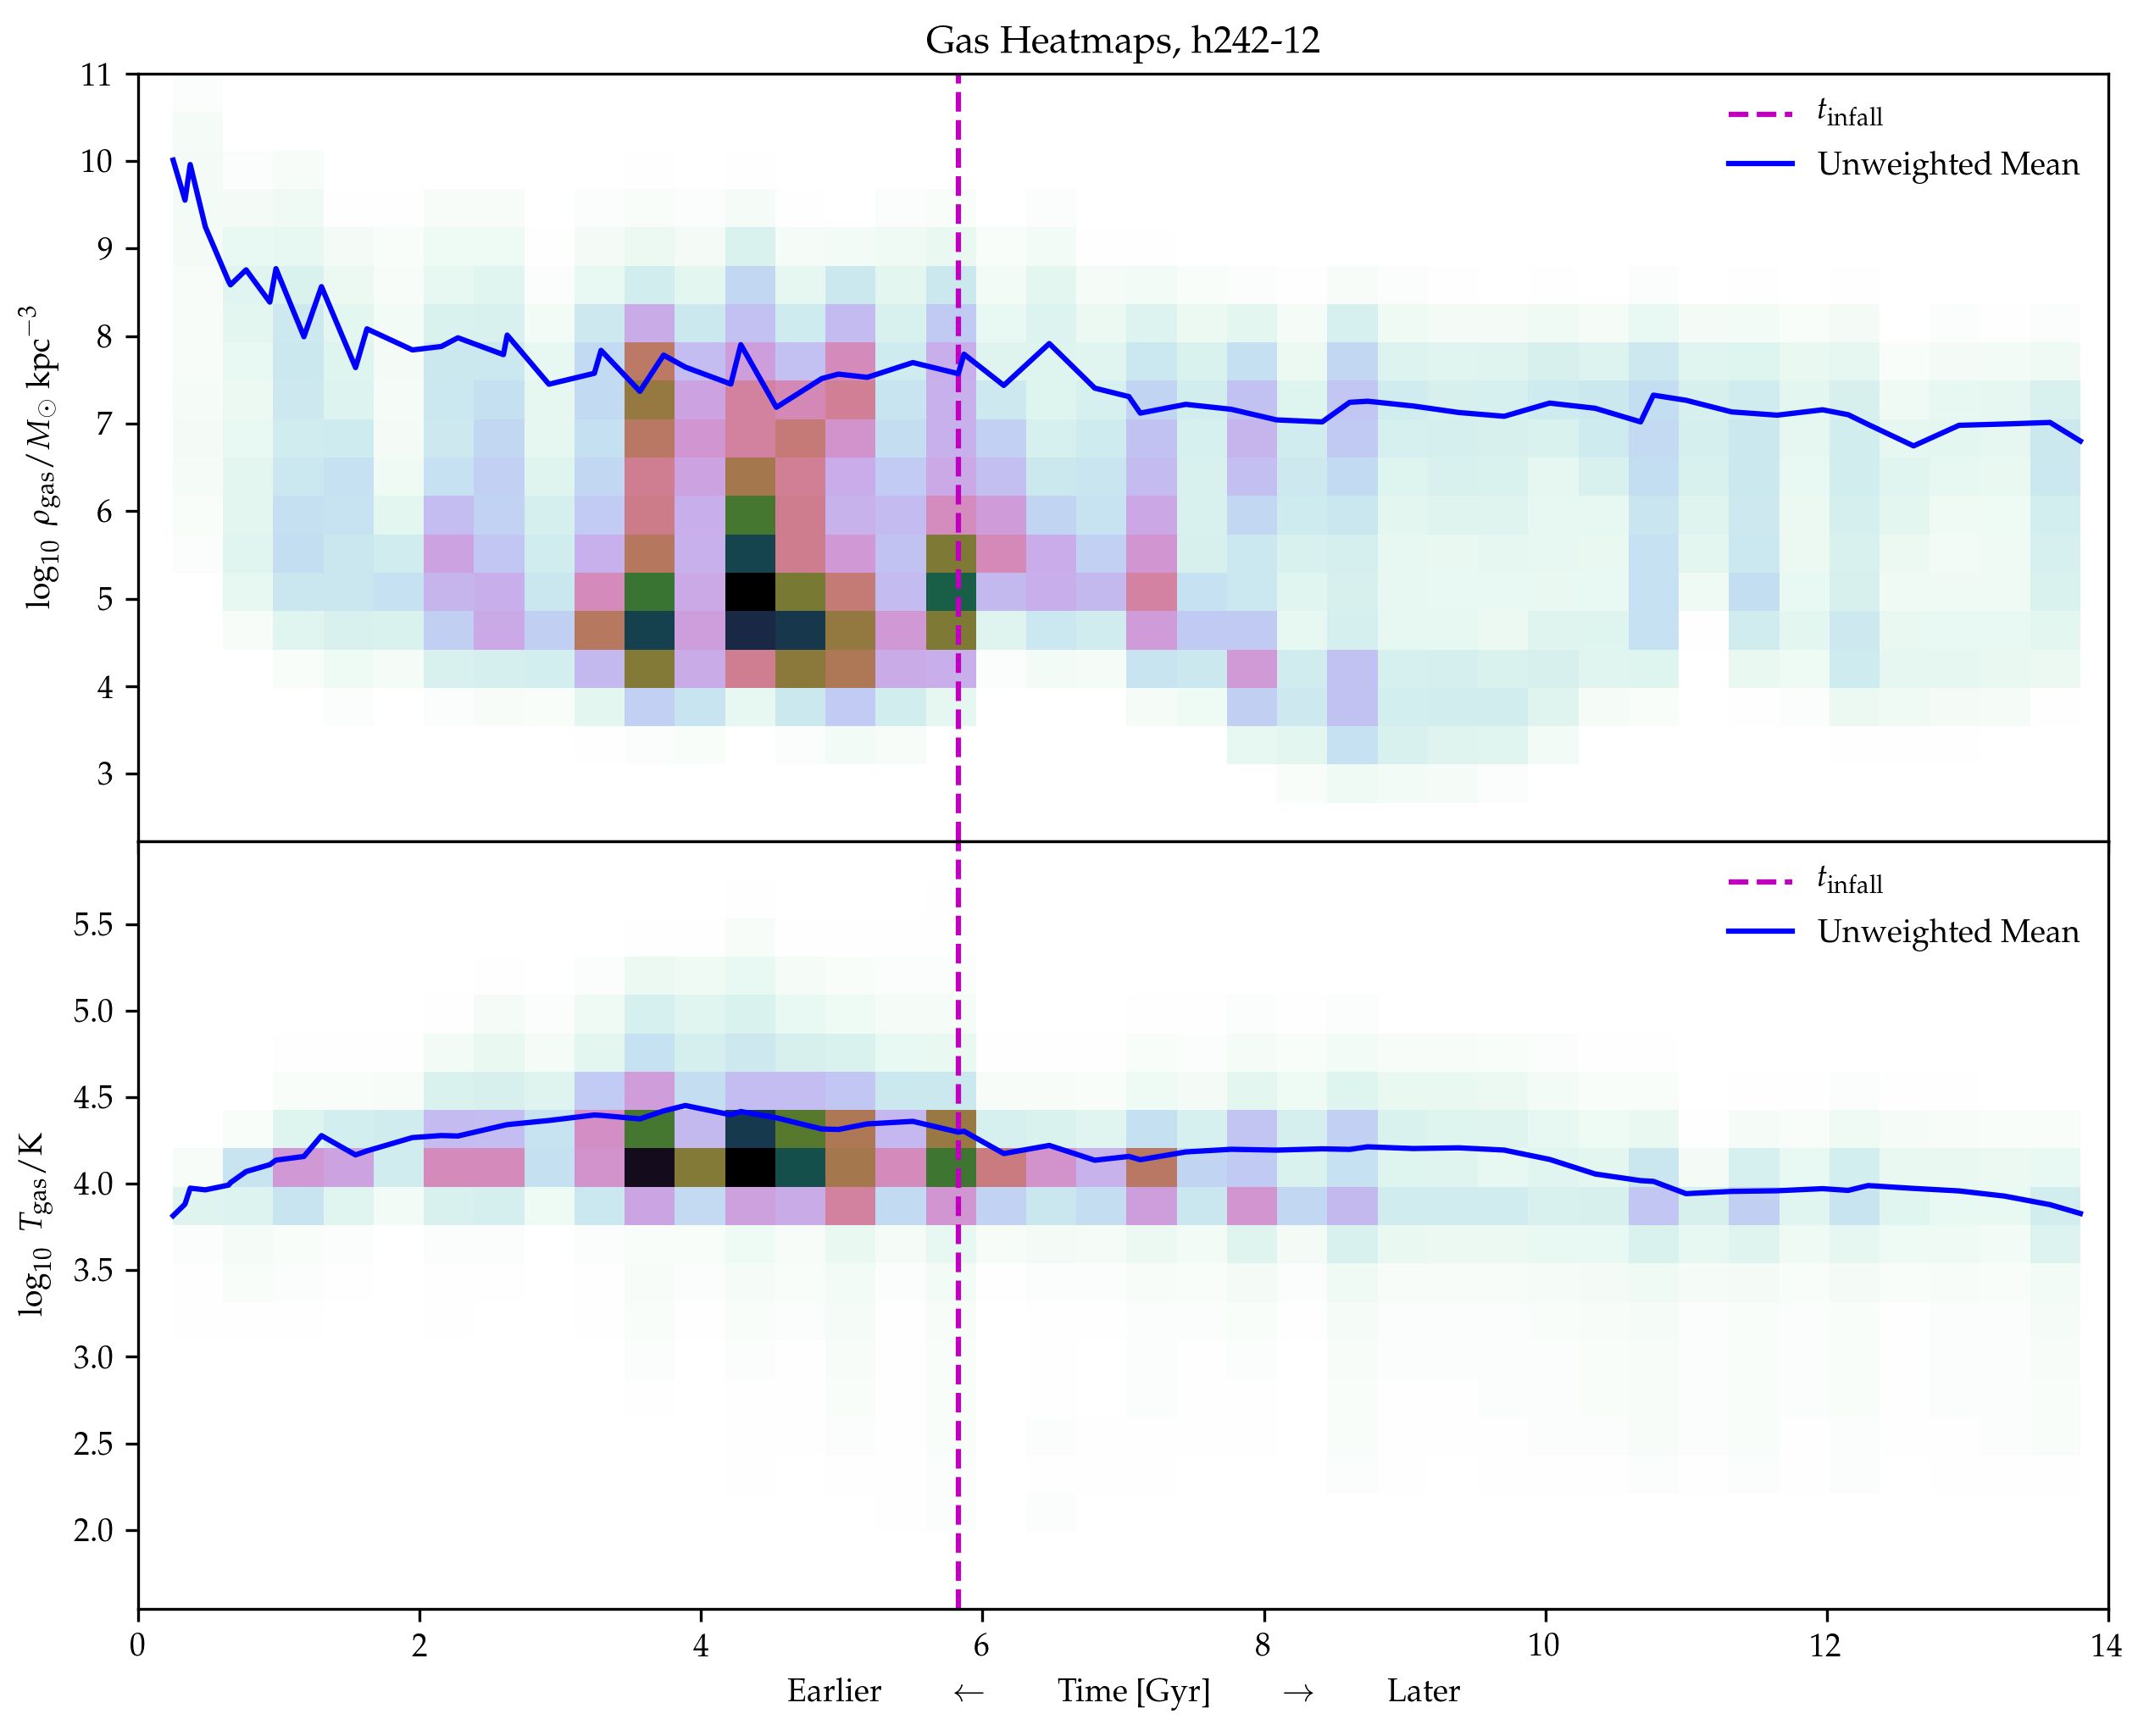

38


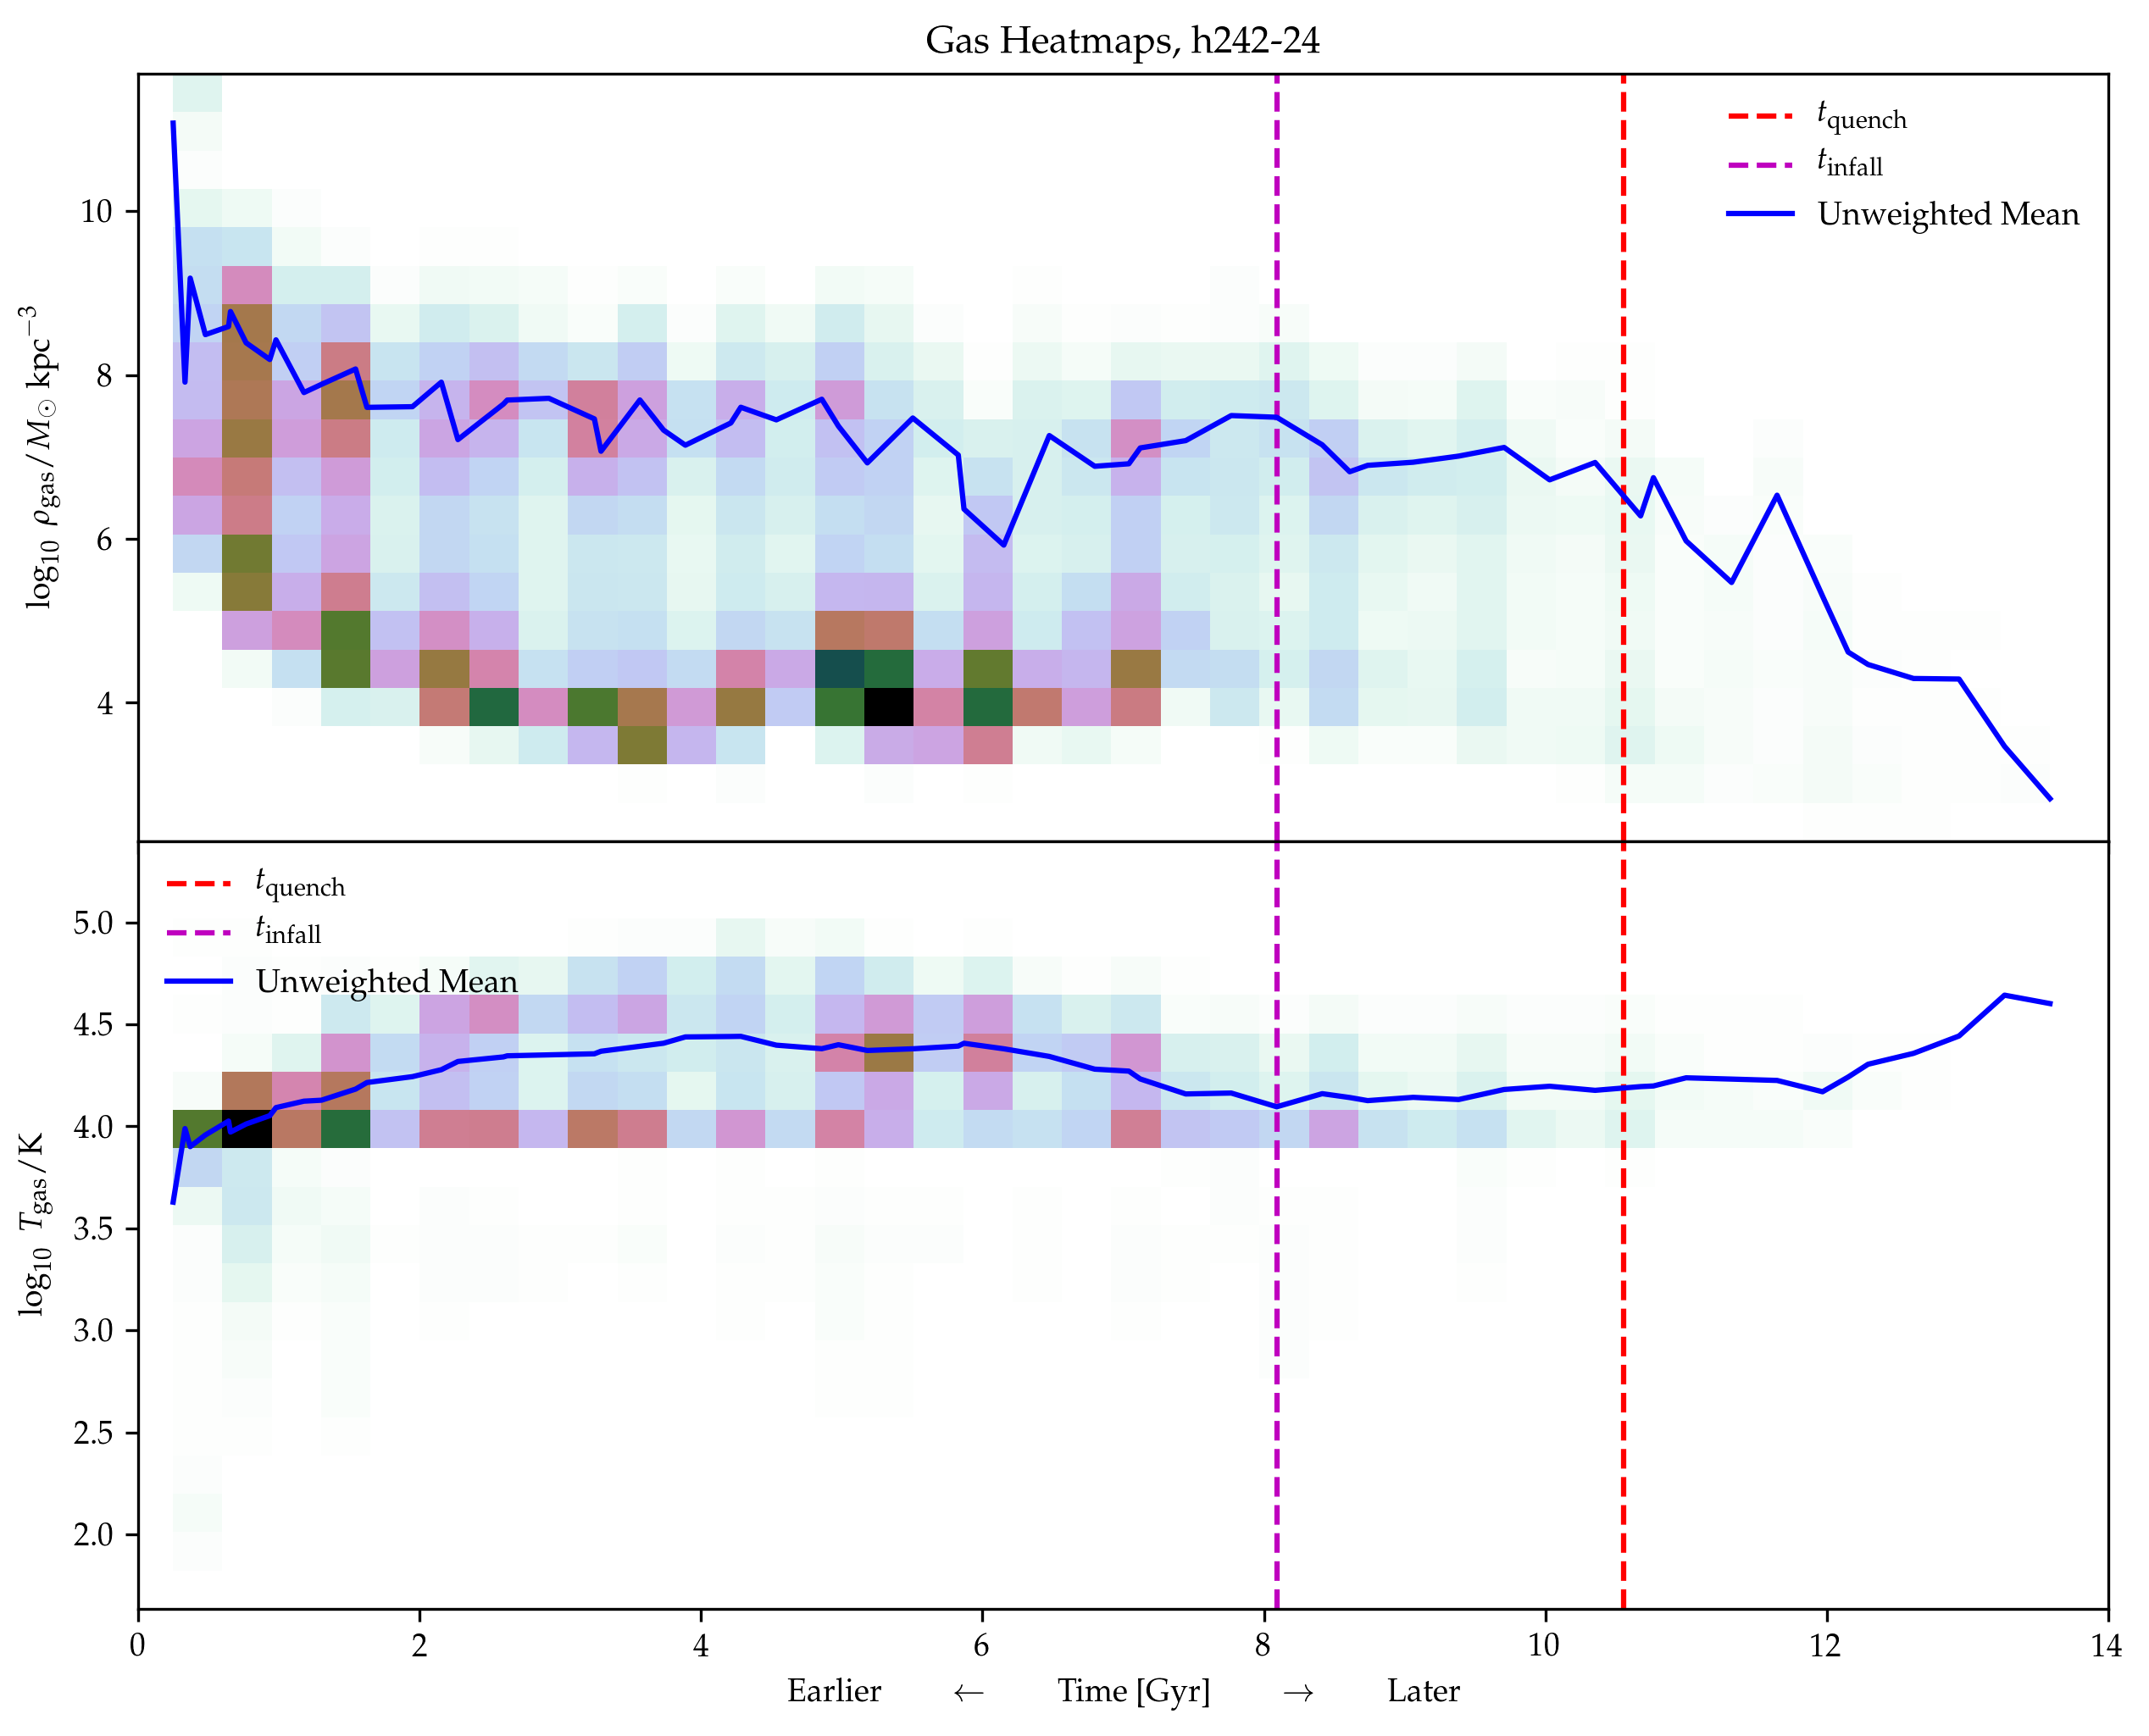

15


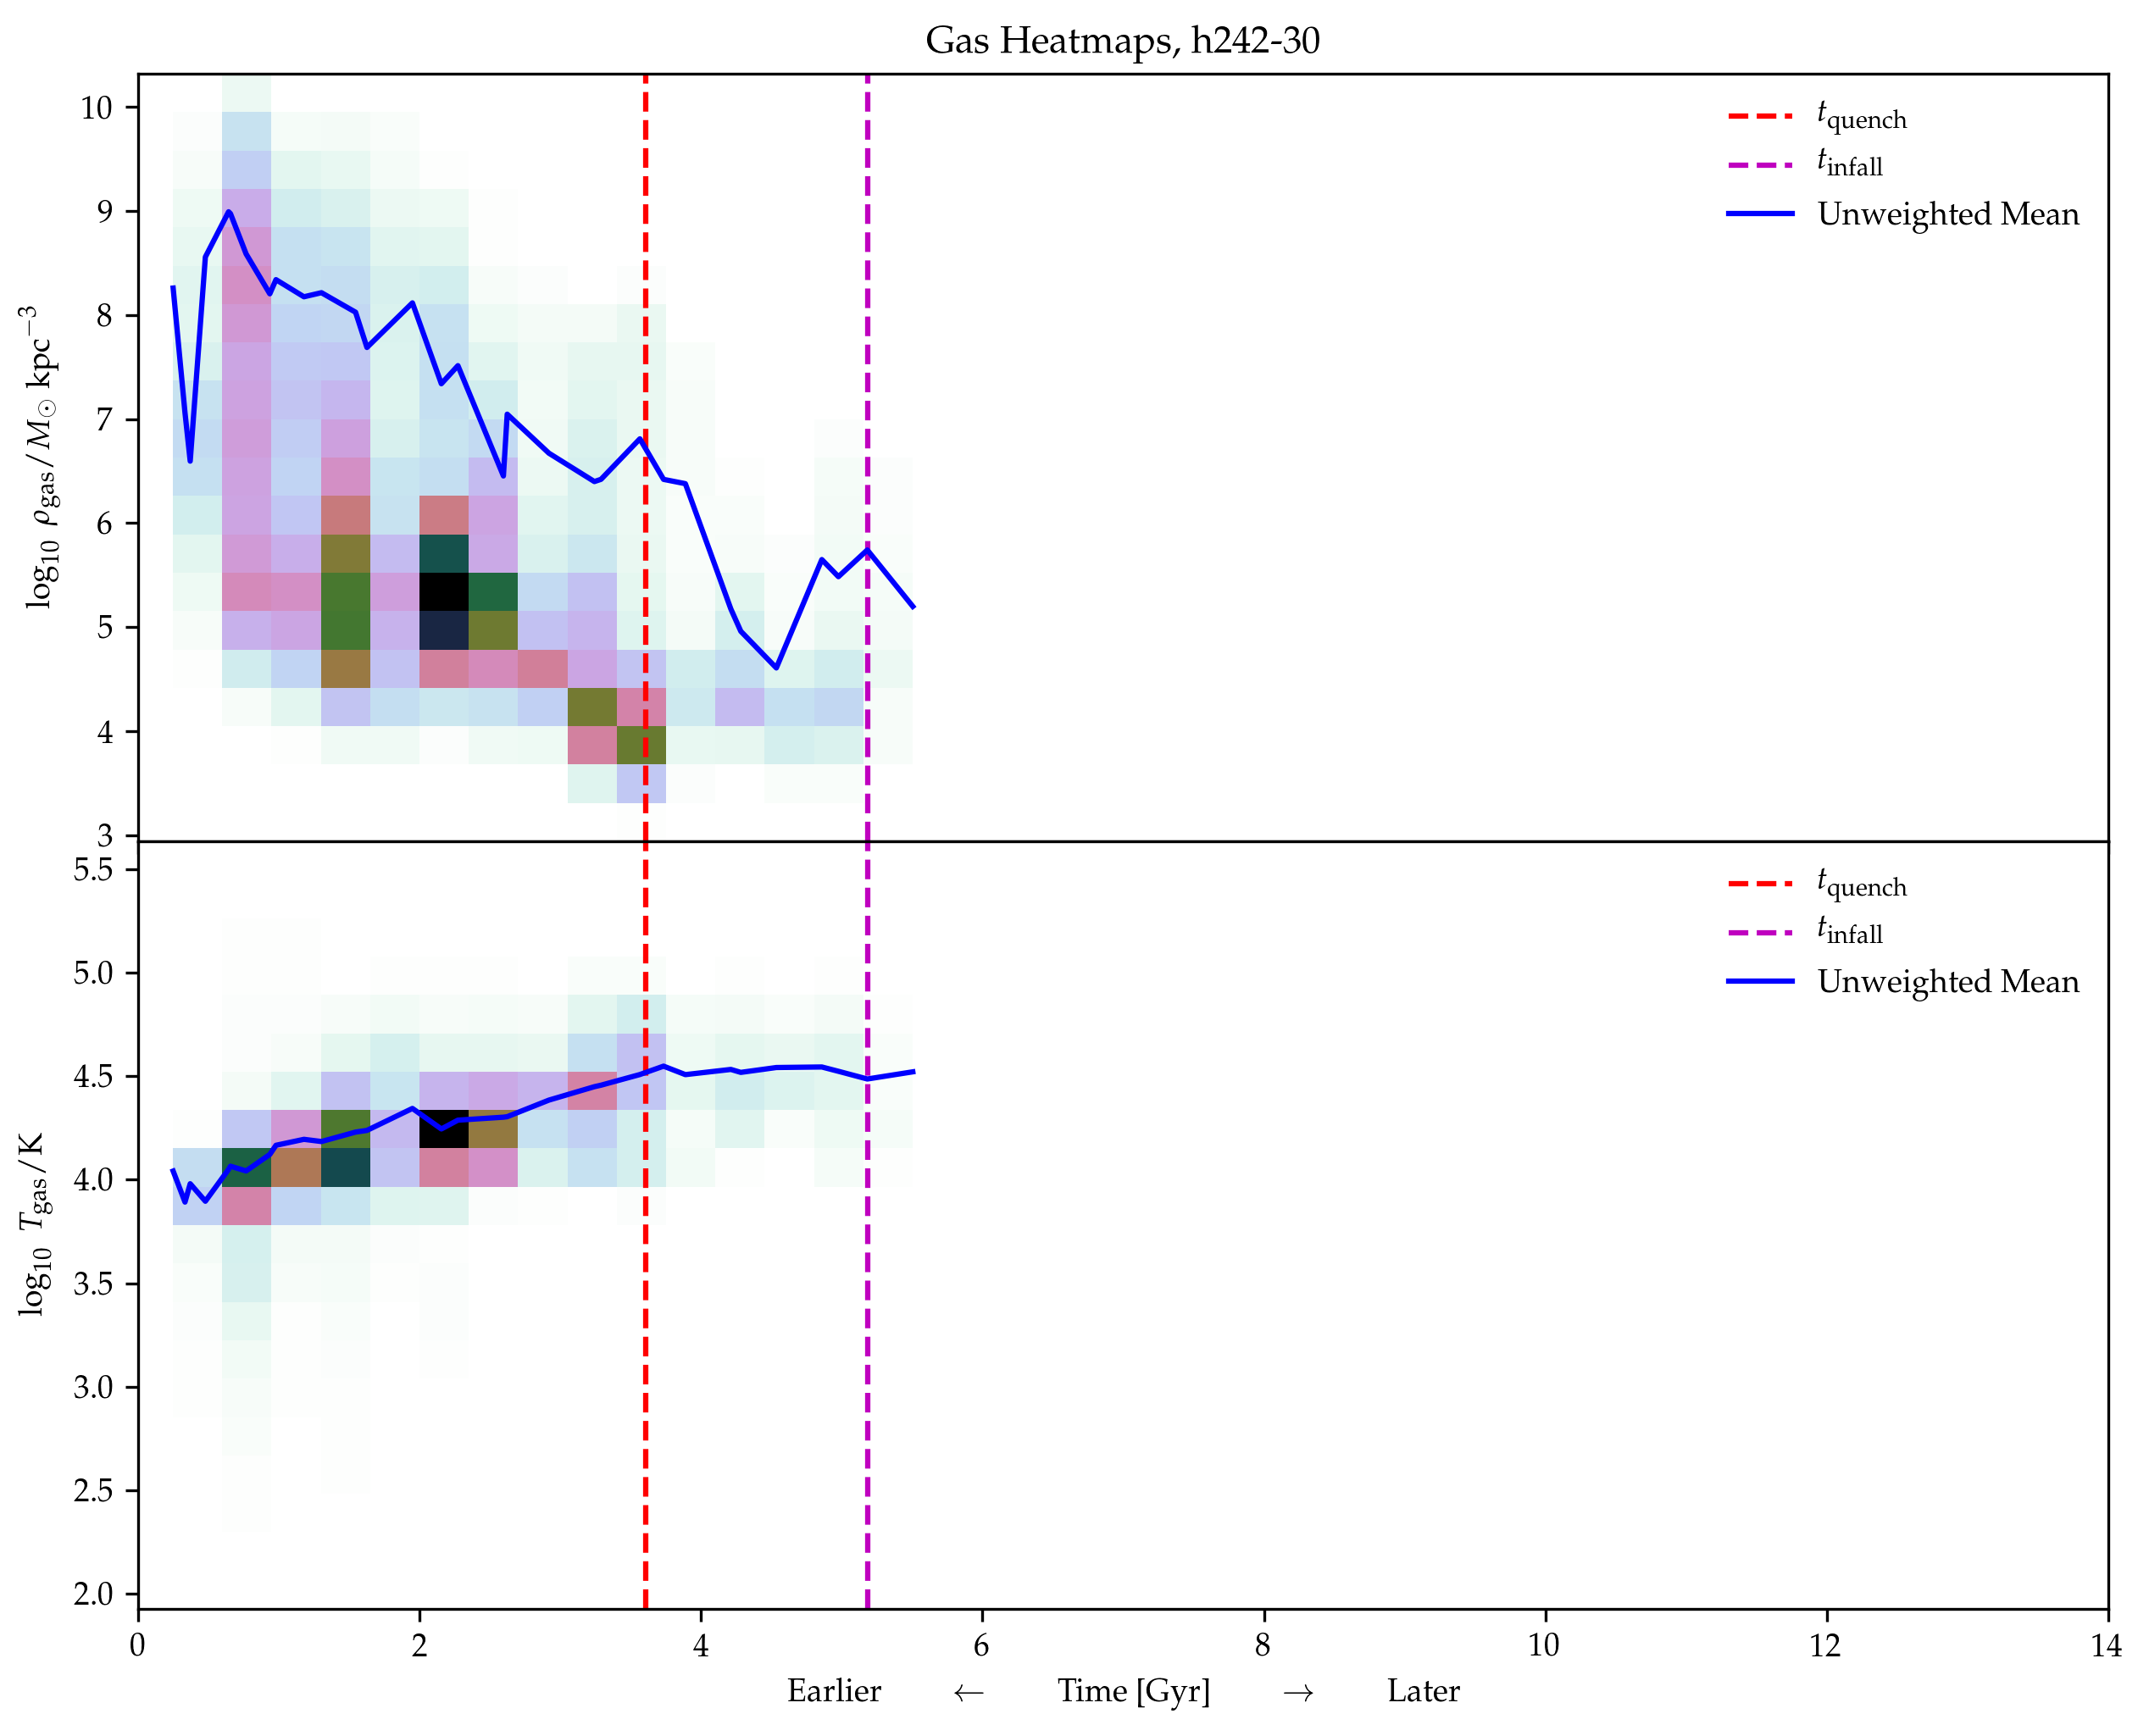

1


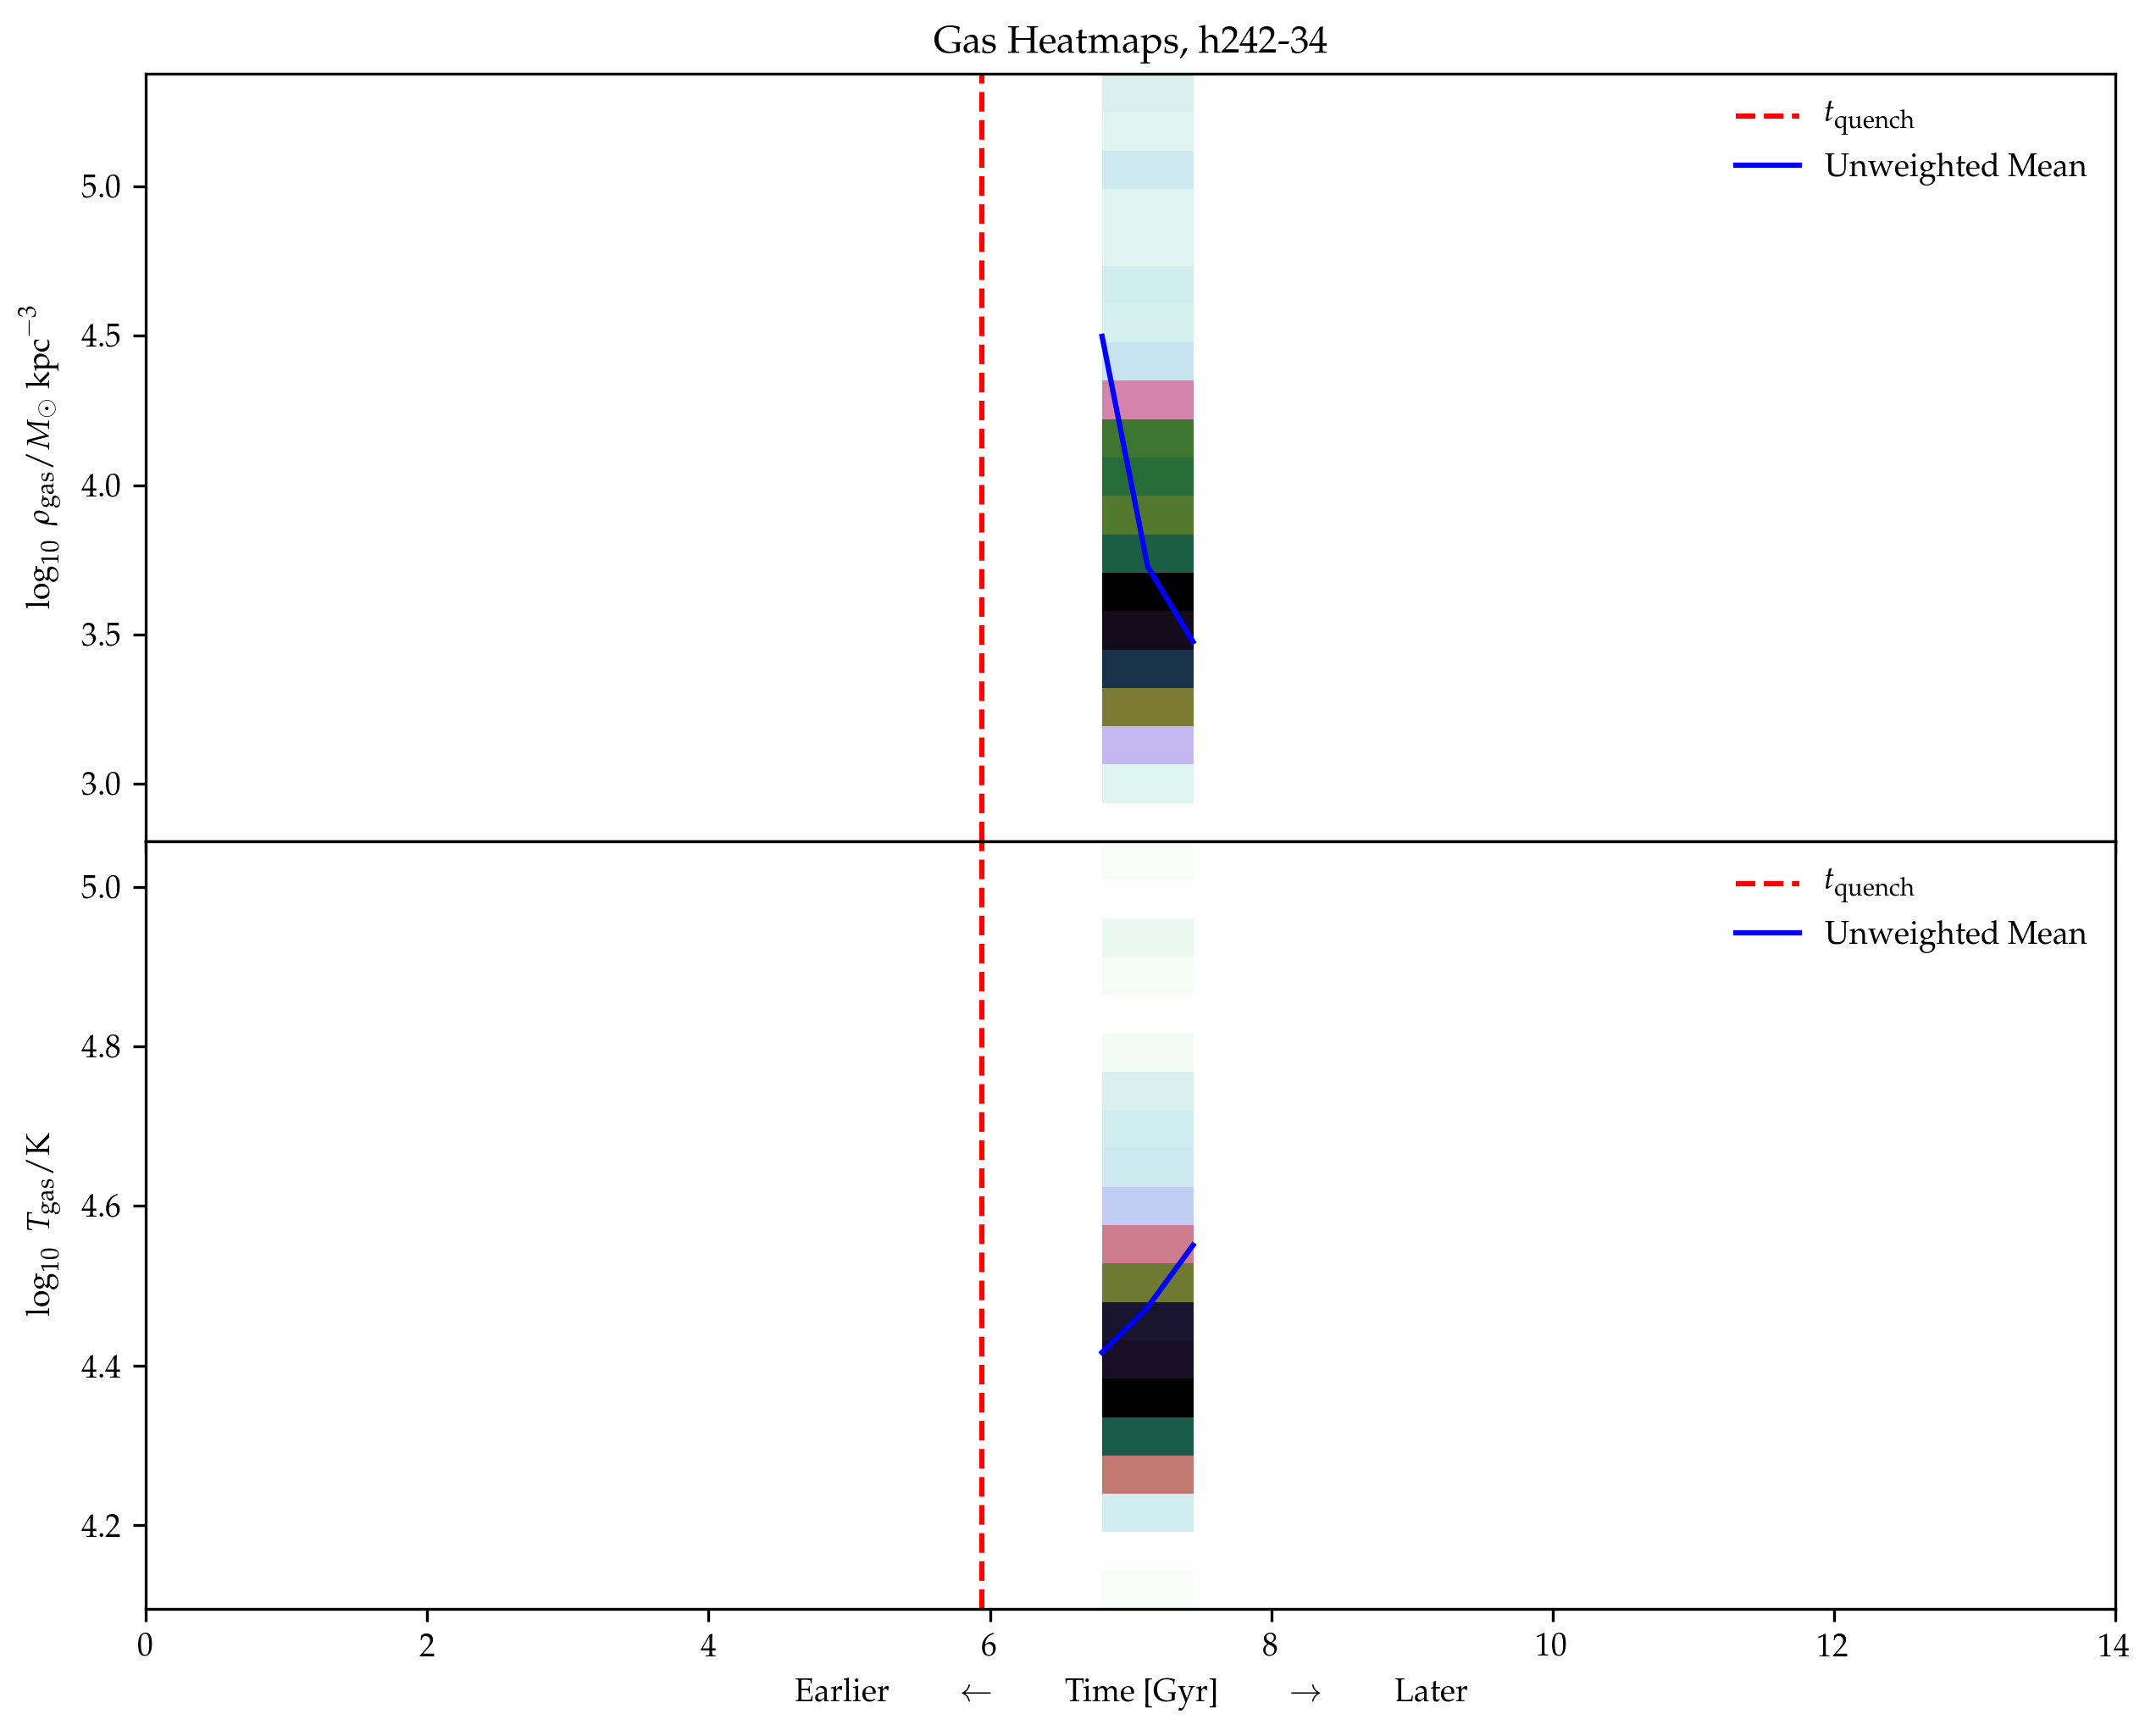

38


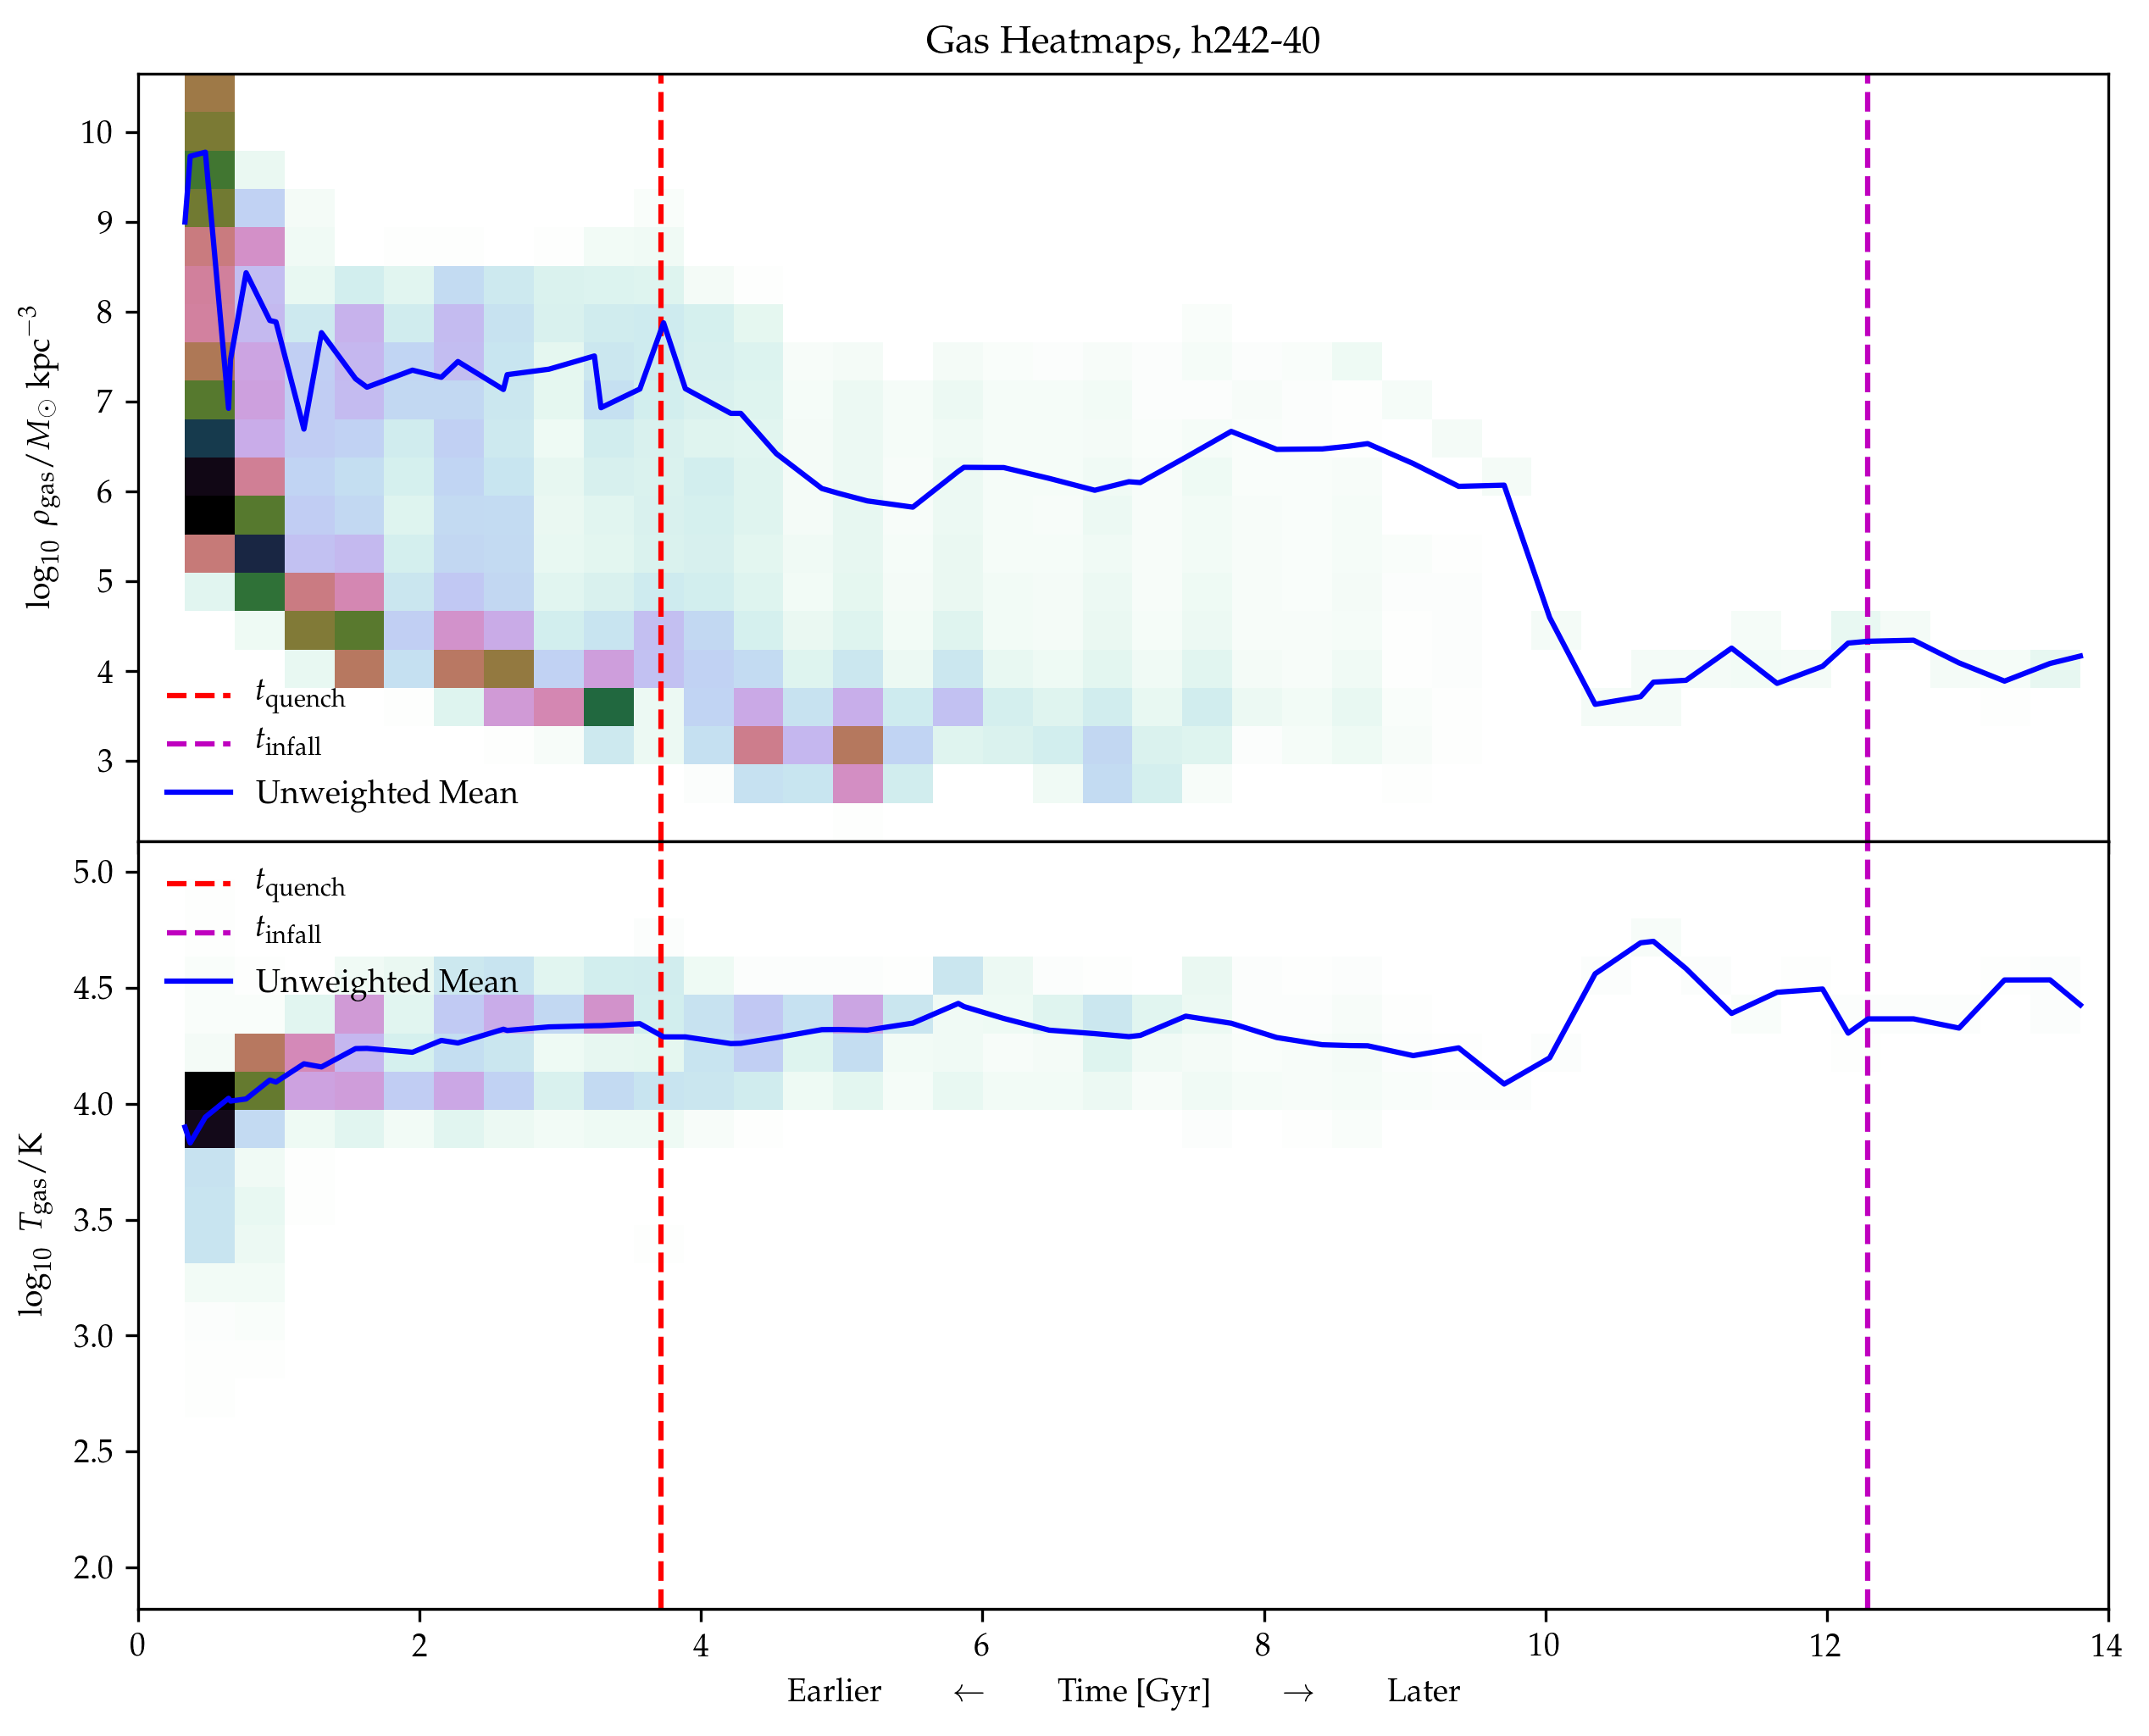

33


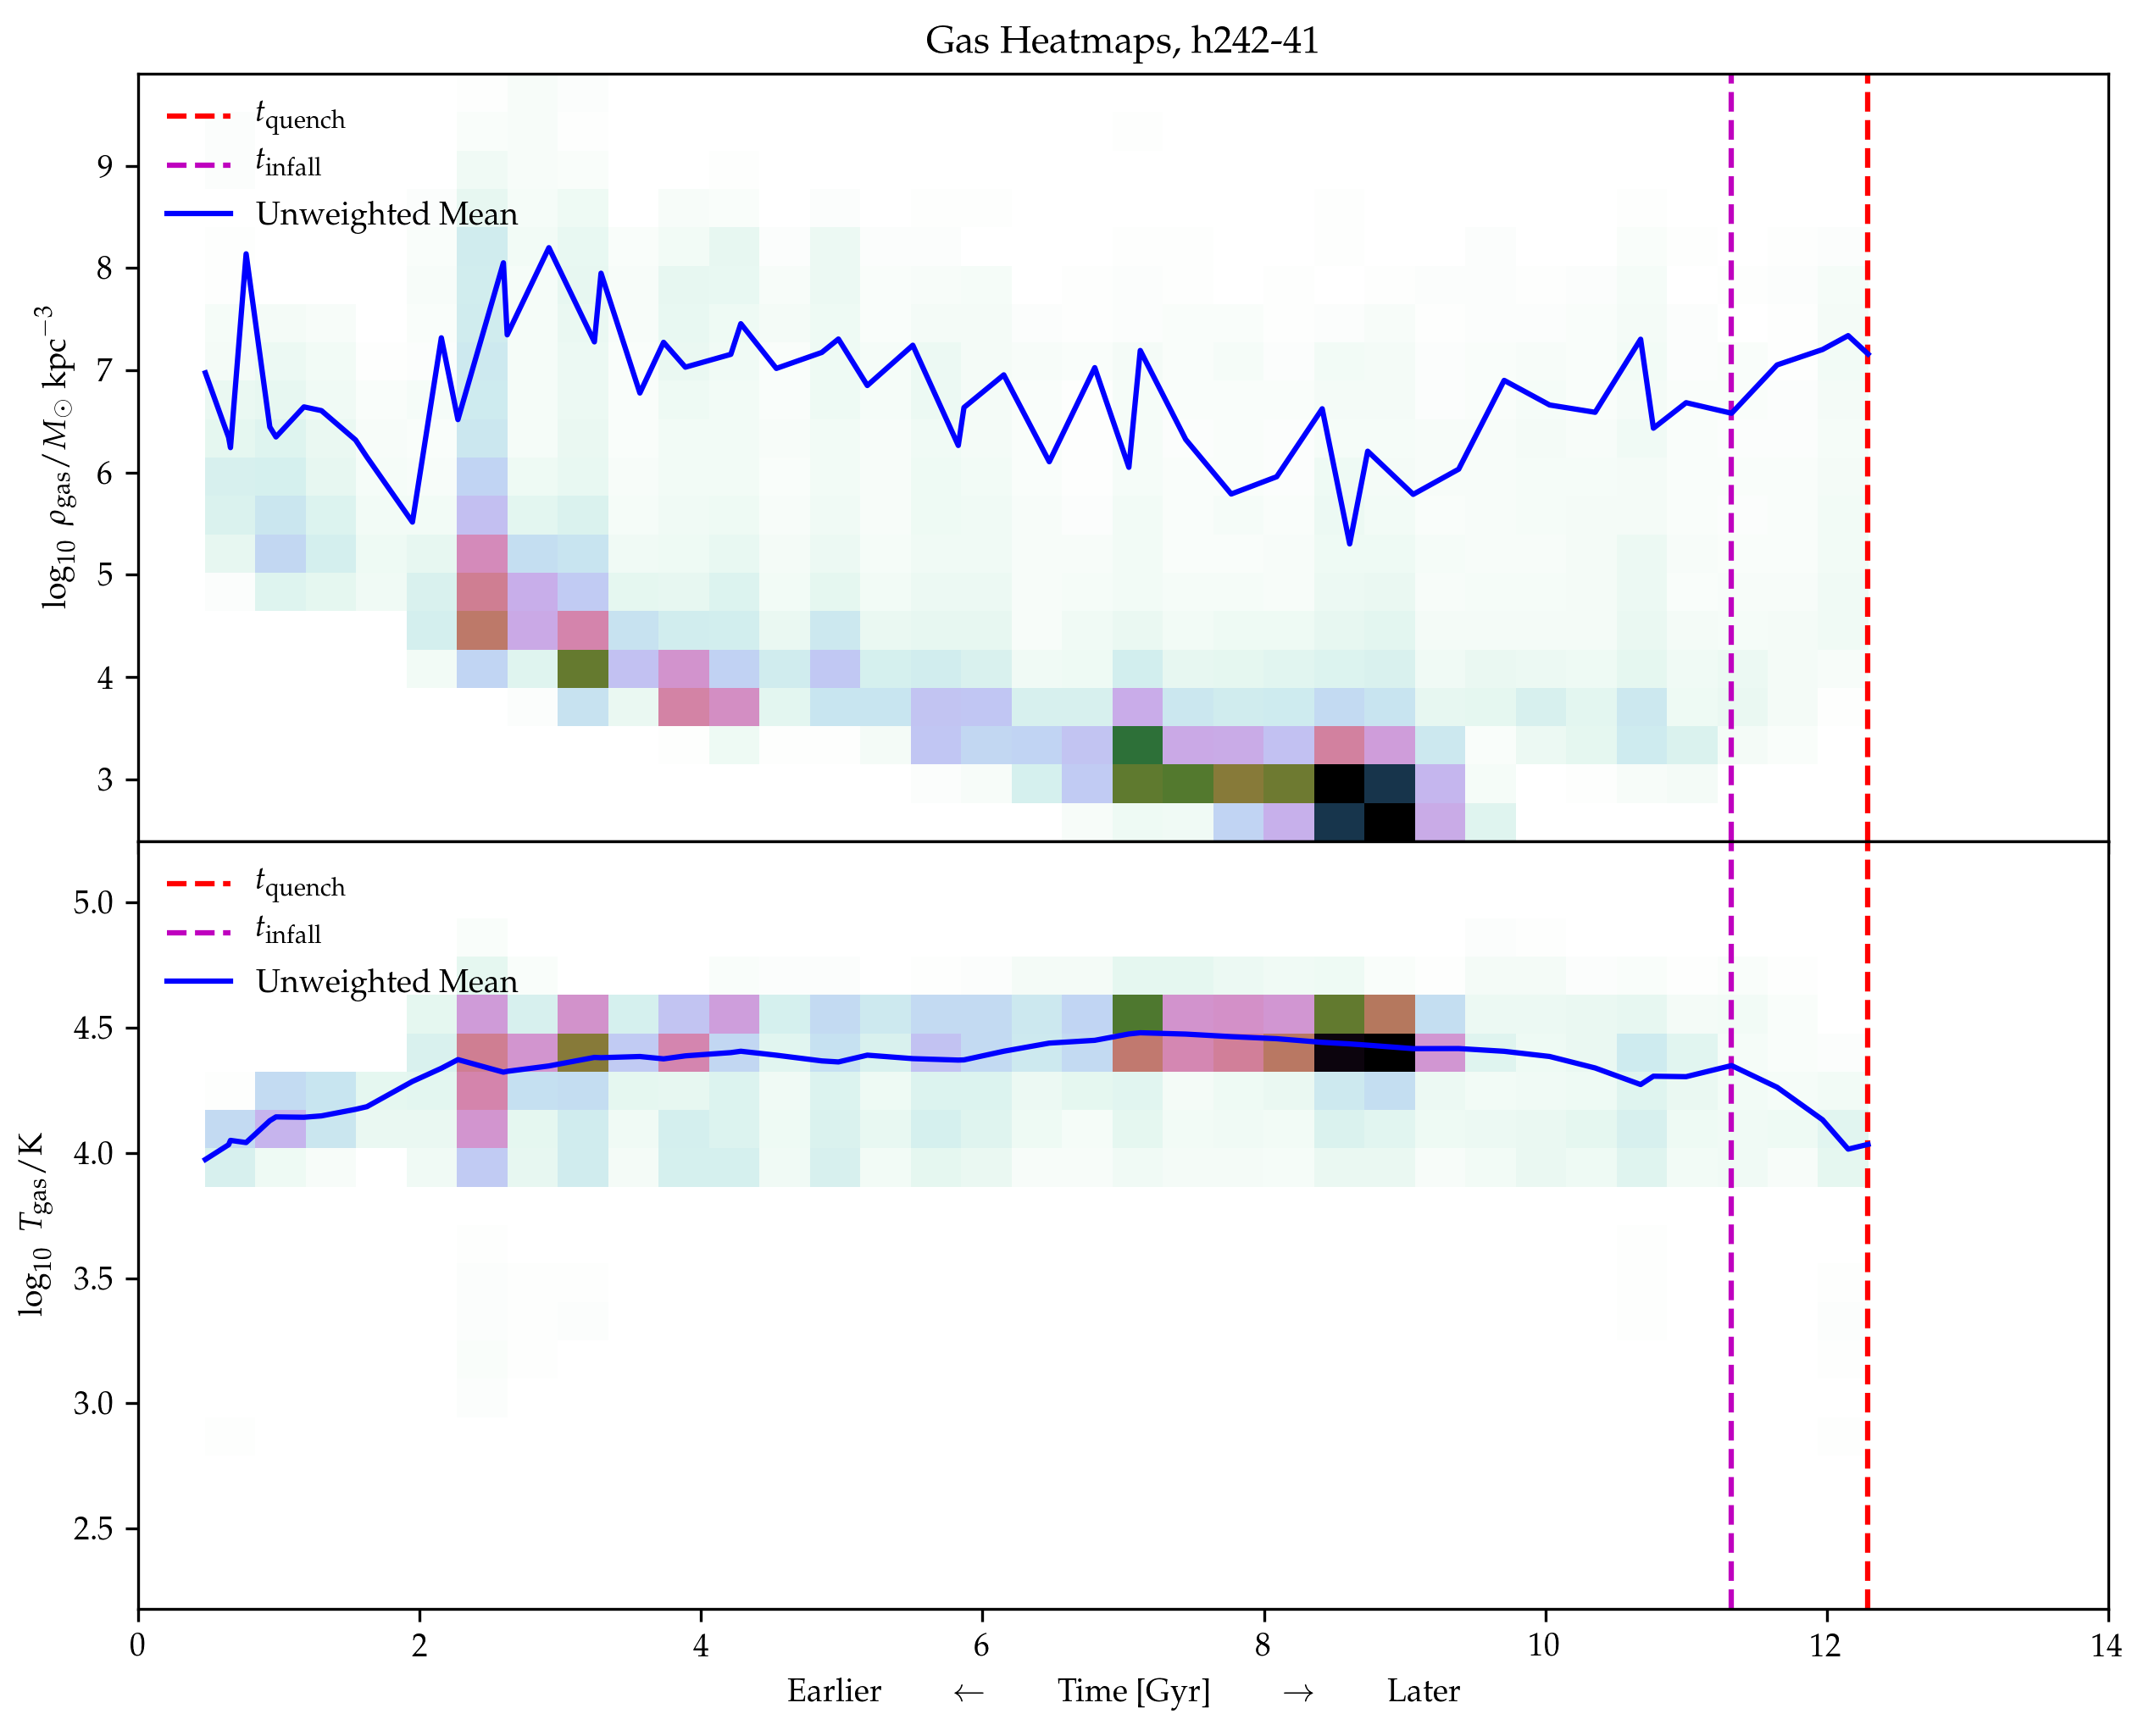

11


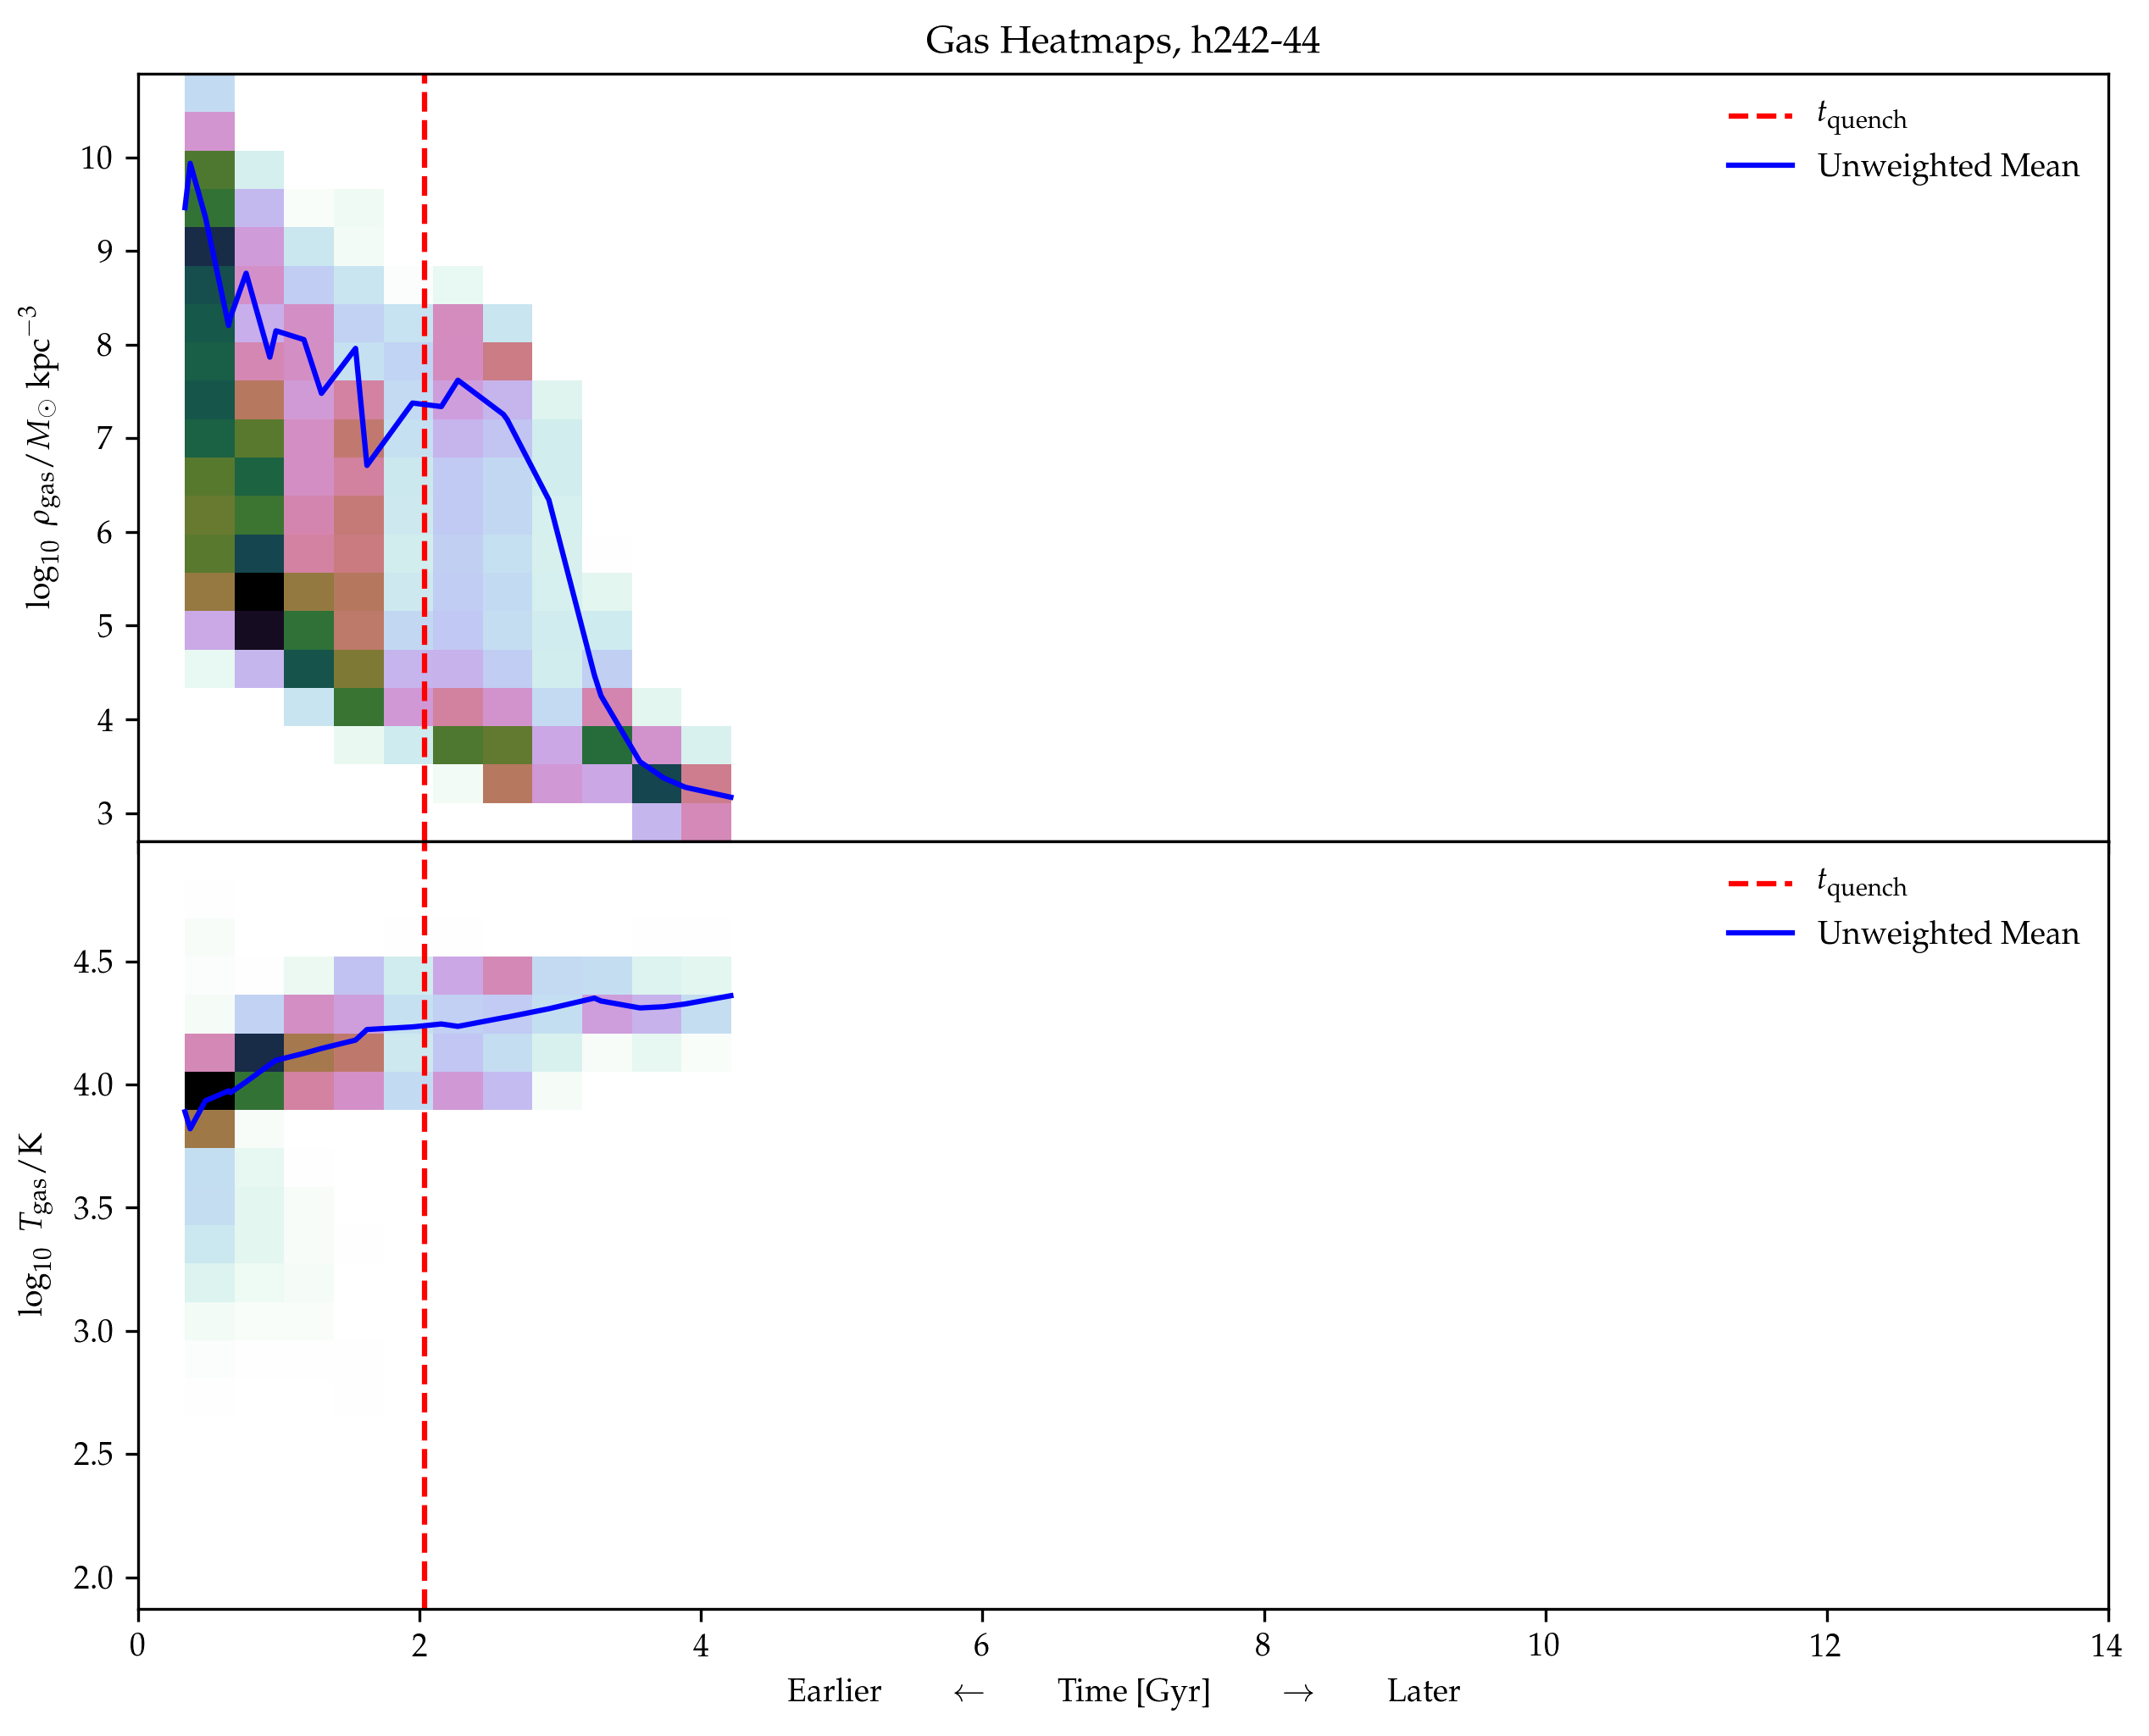

21


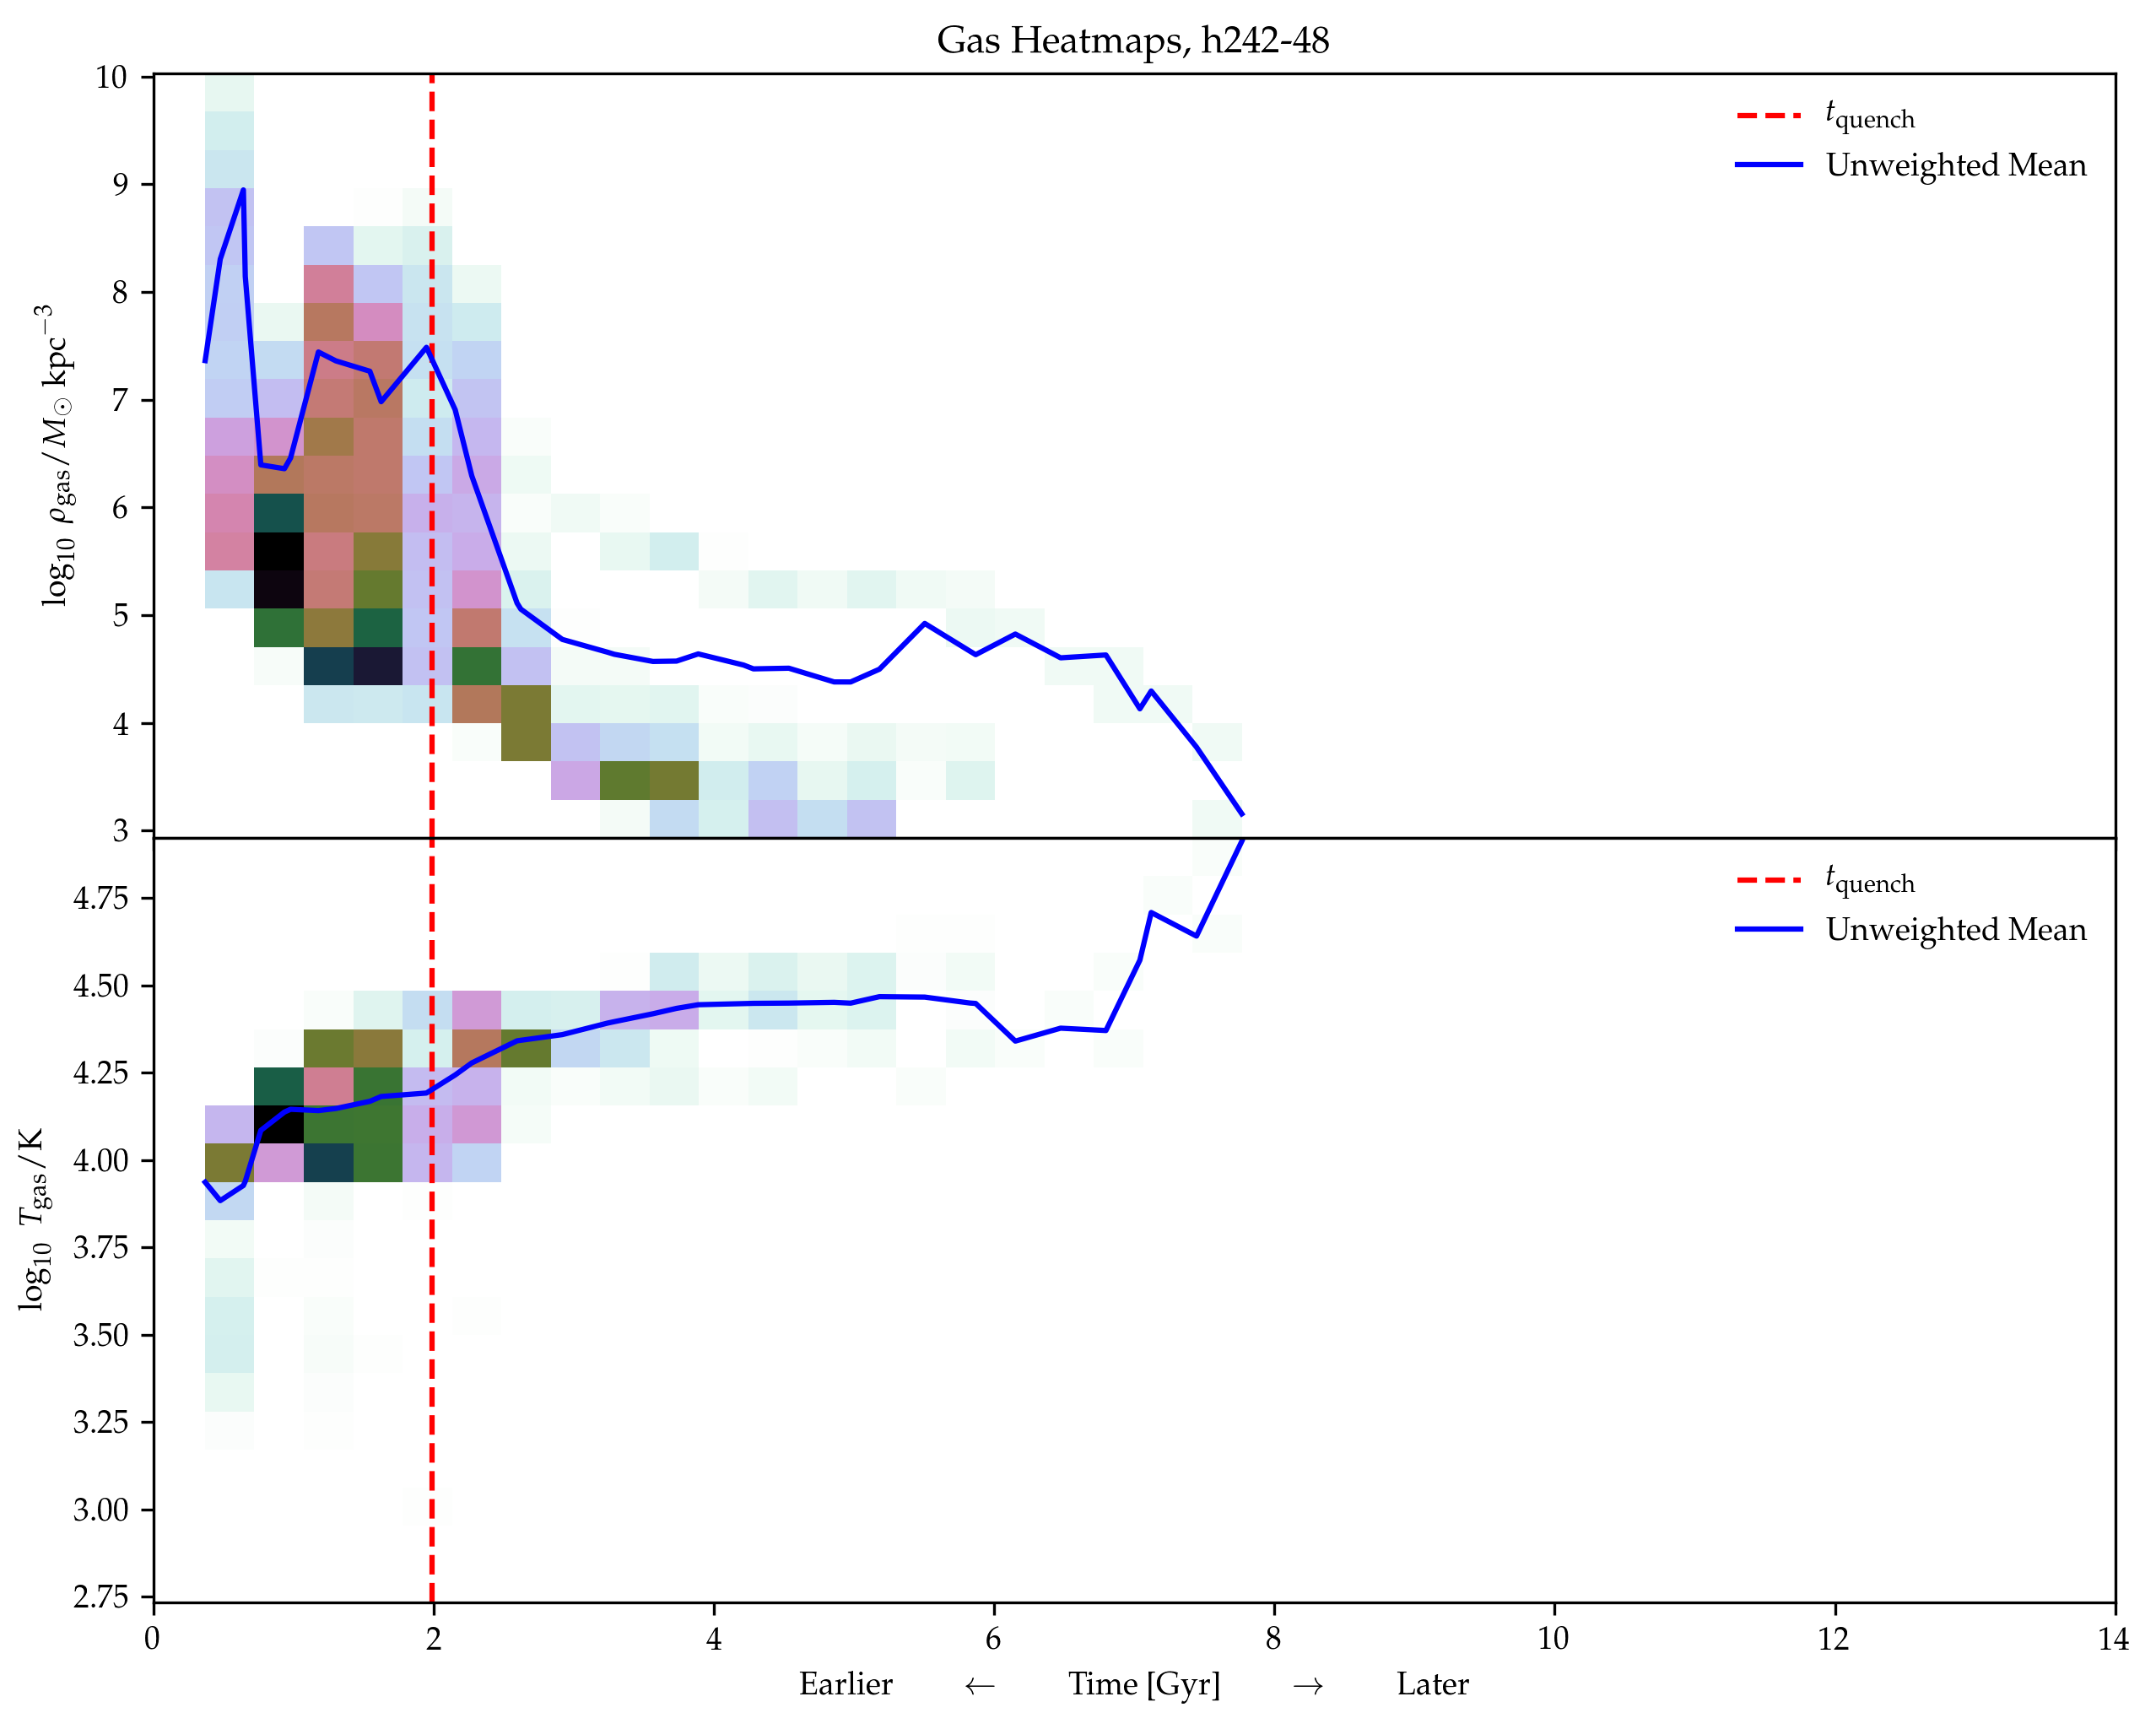

9


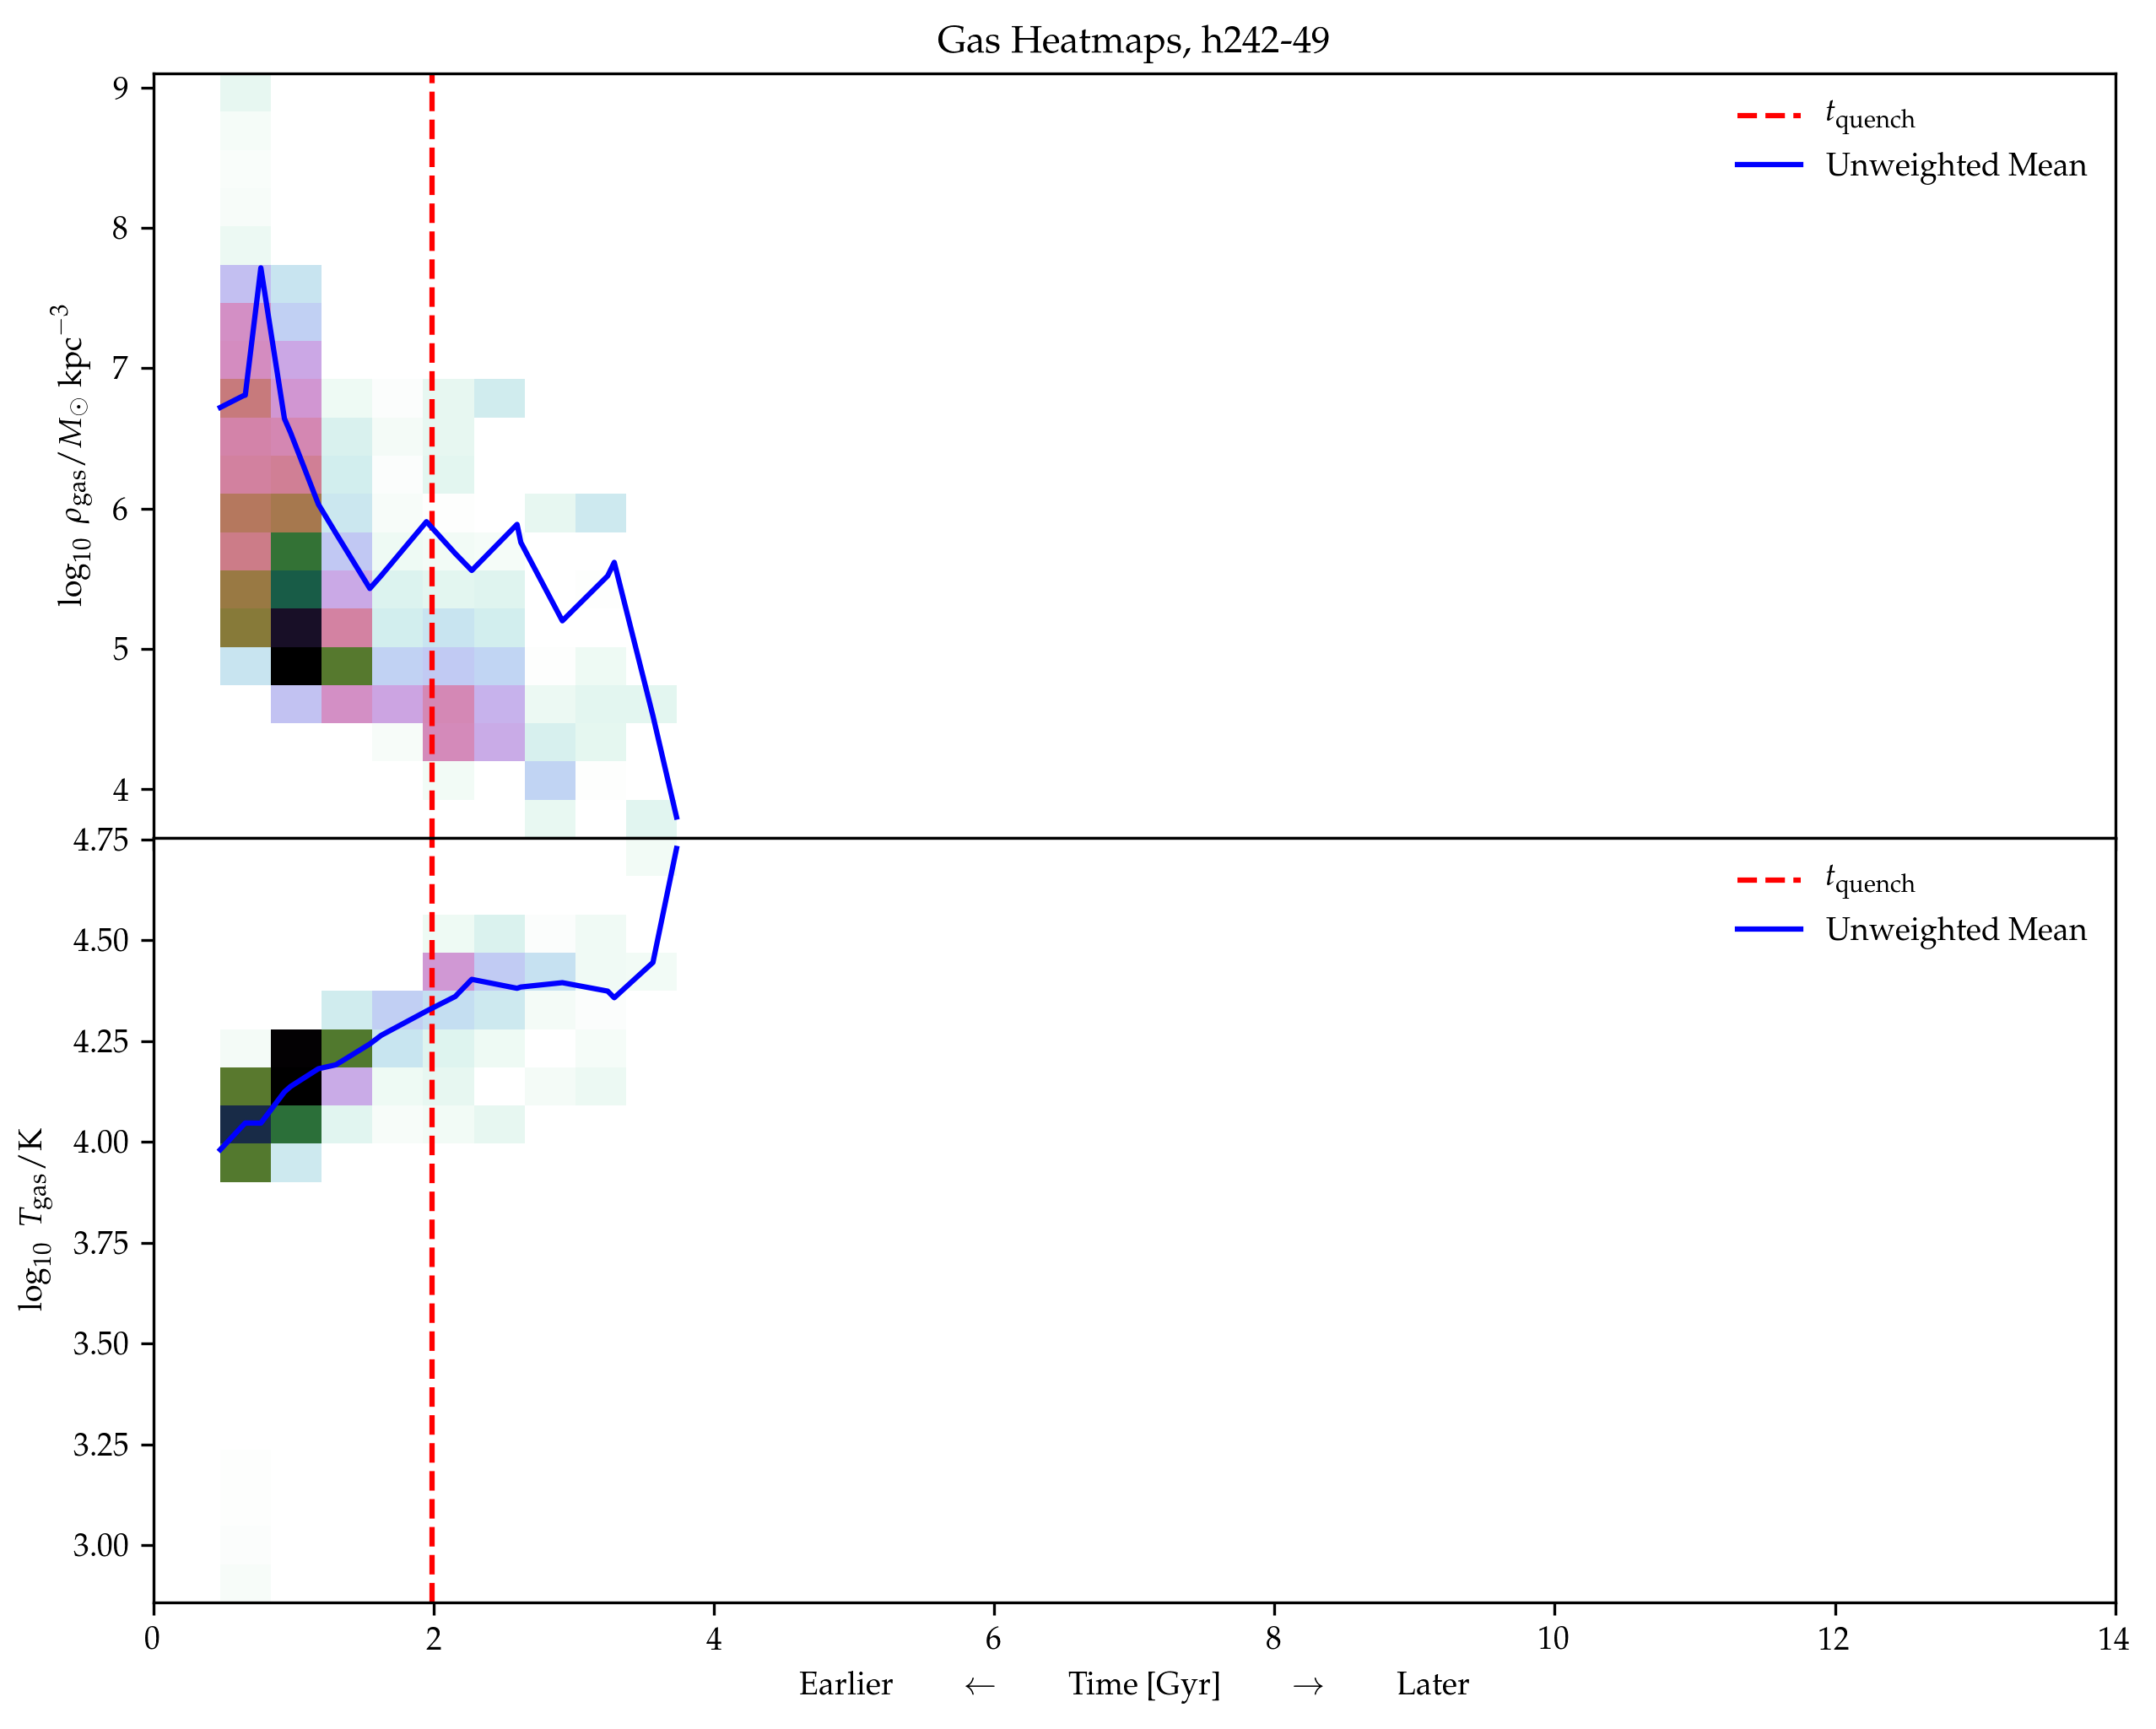

19


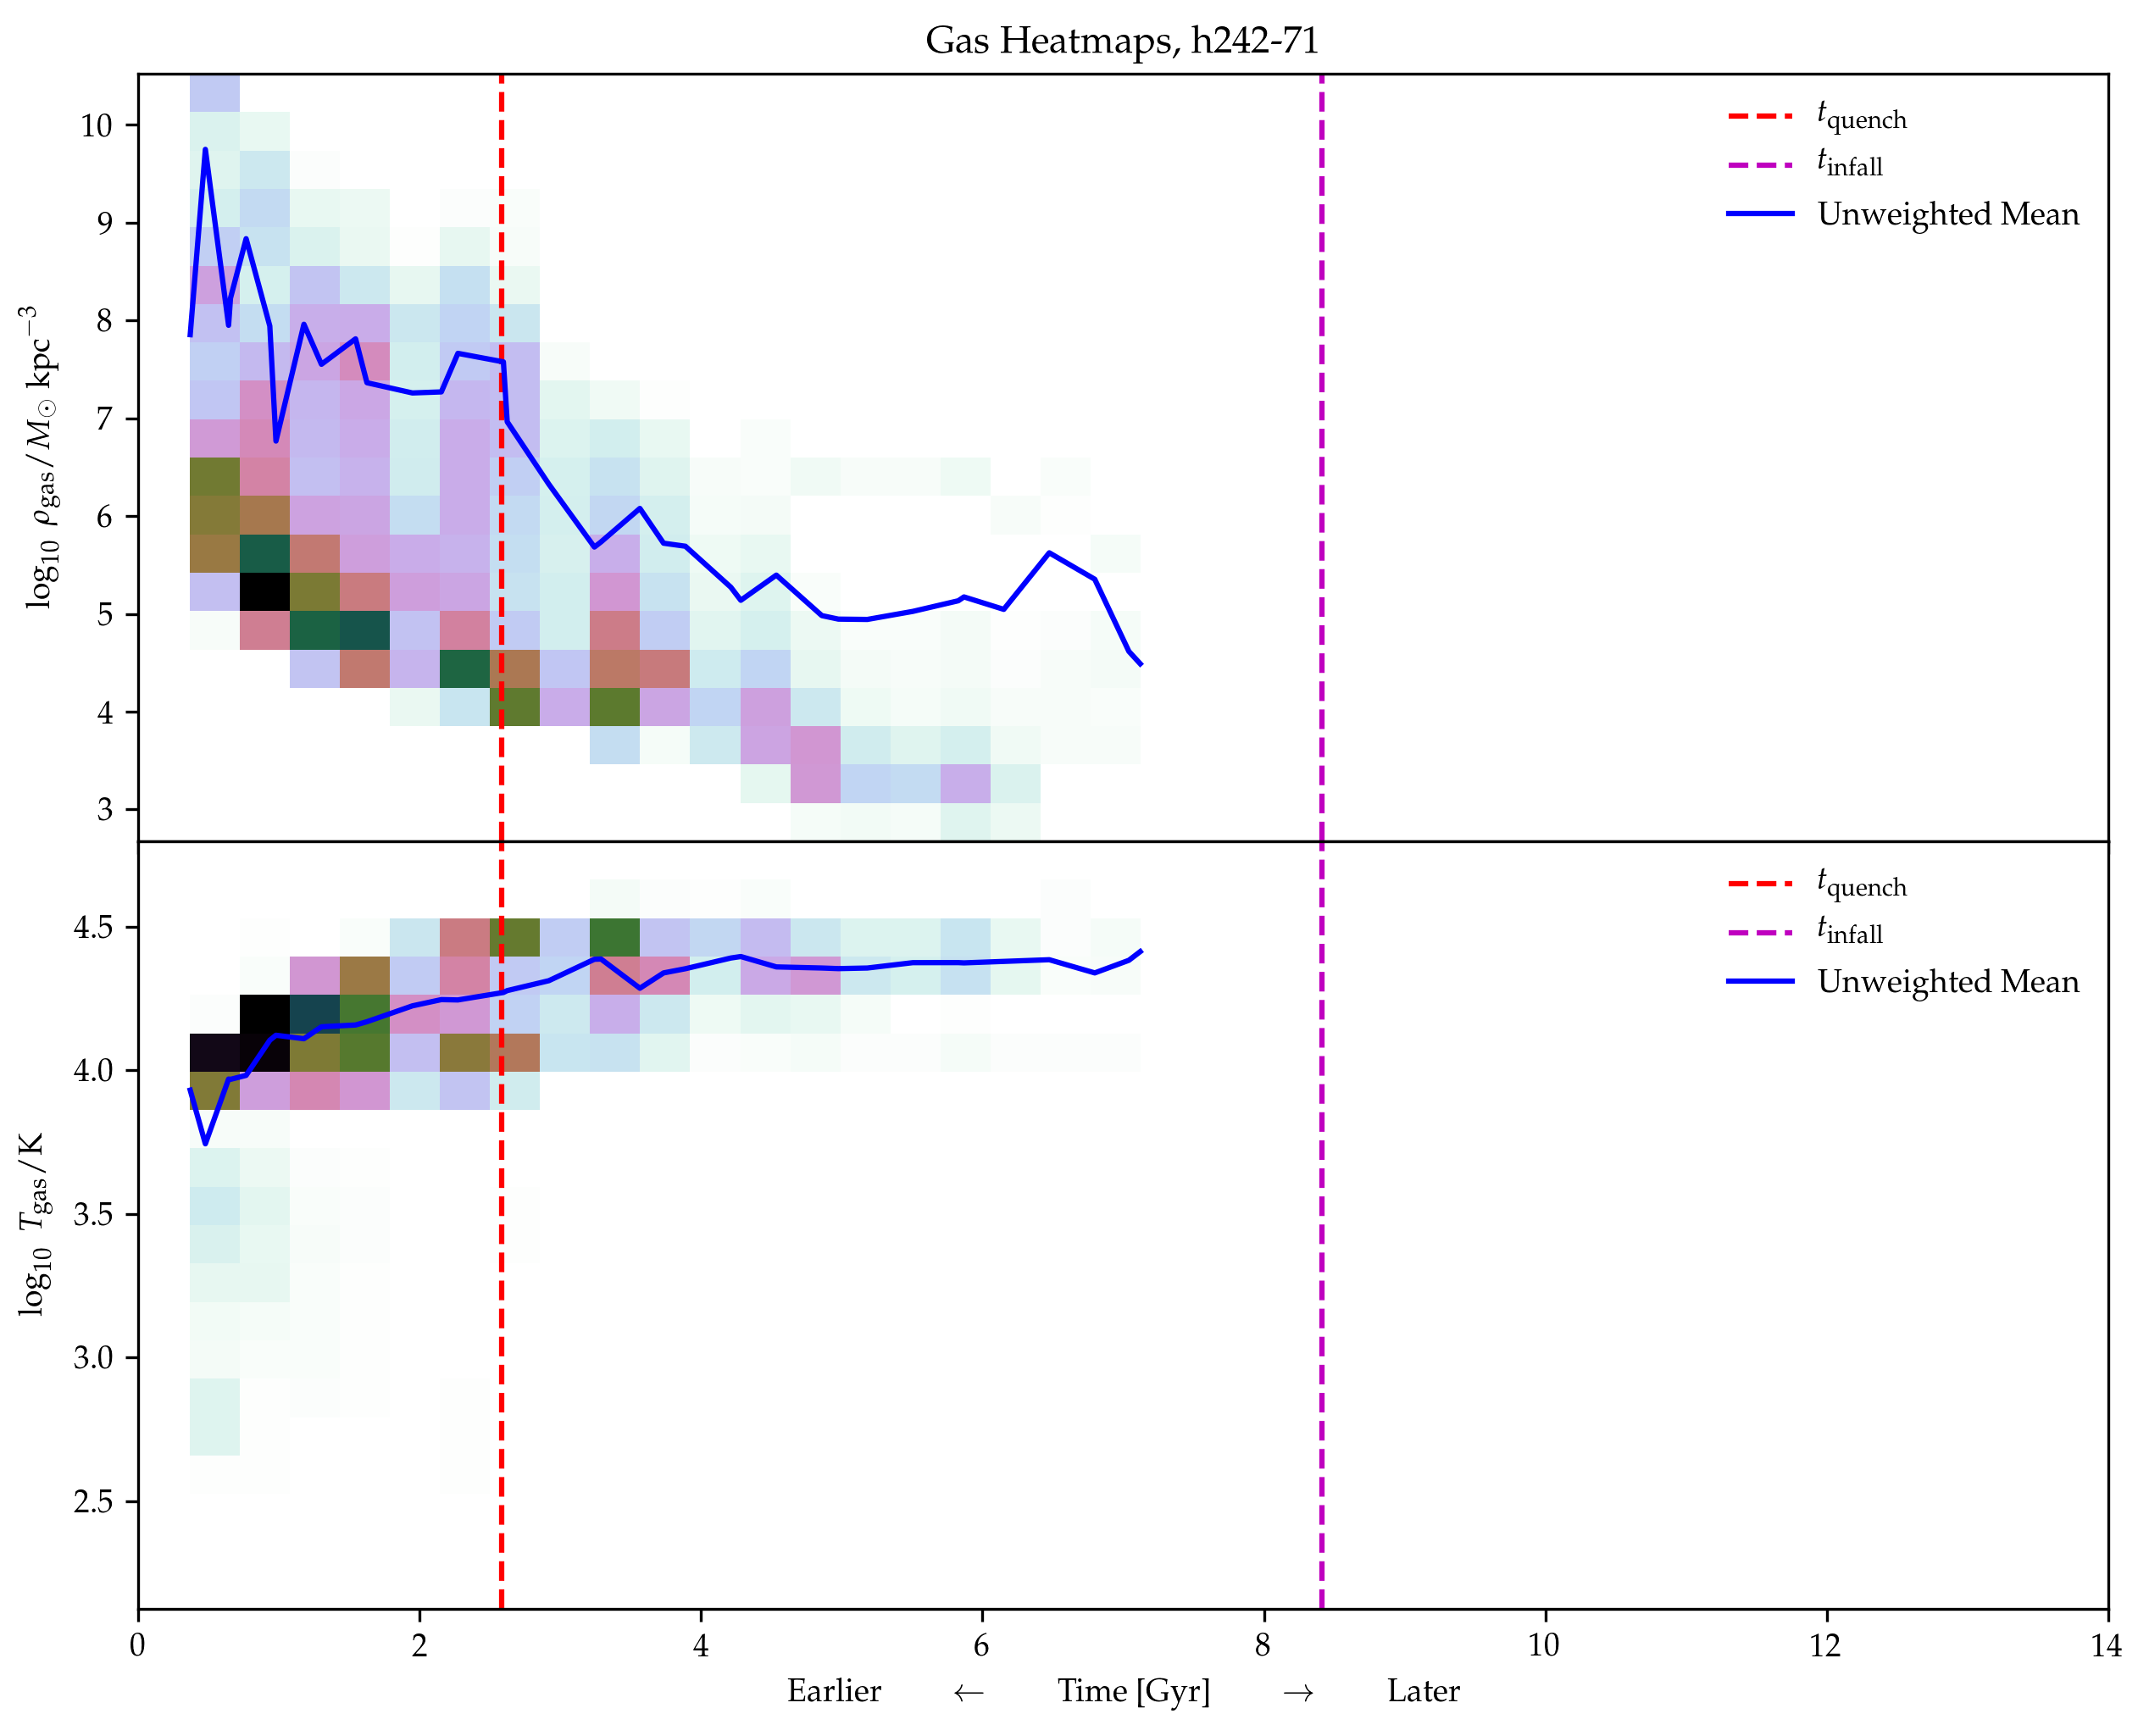

28


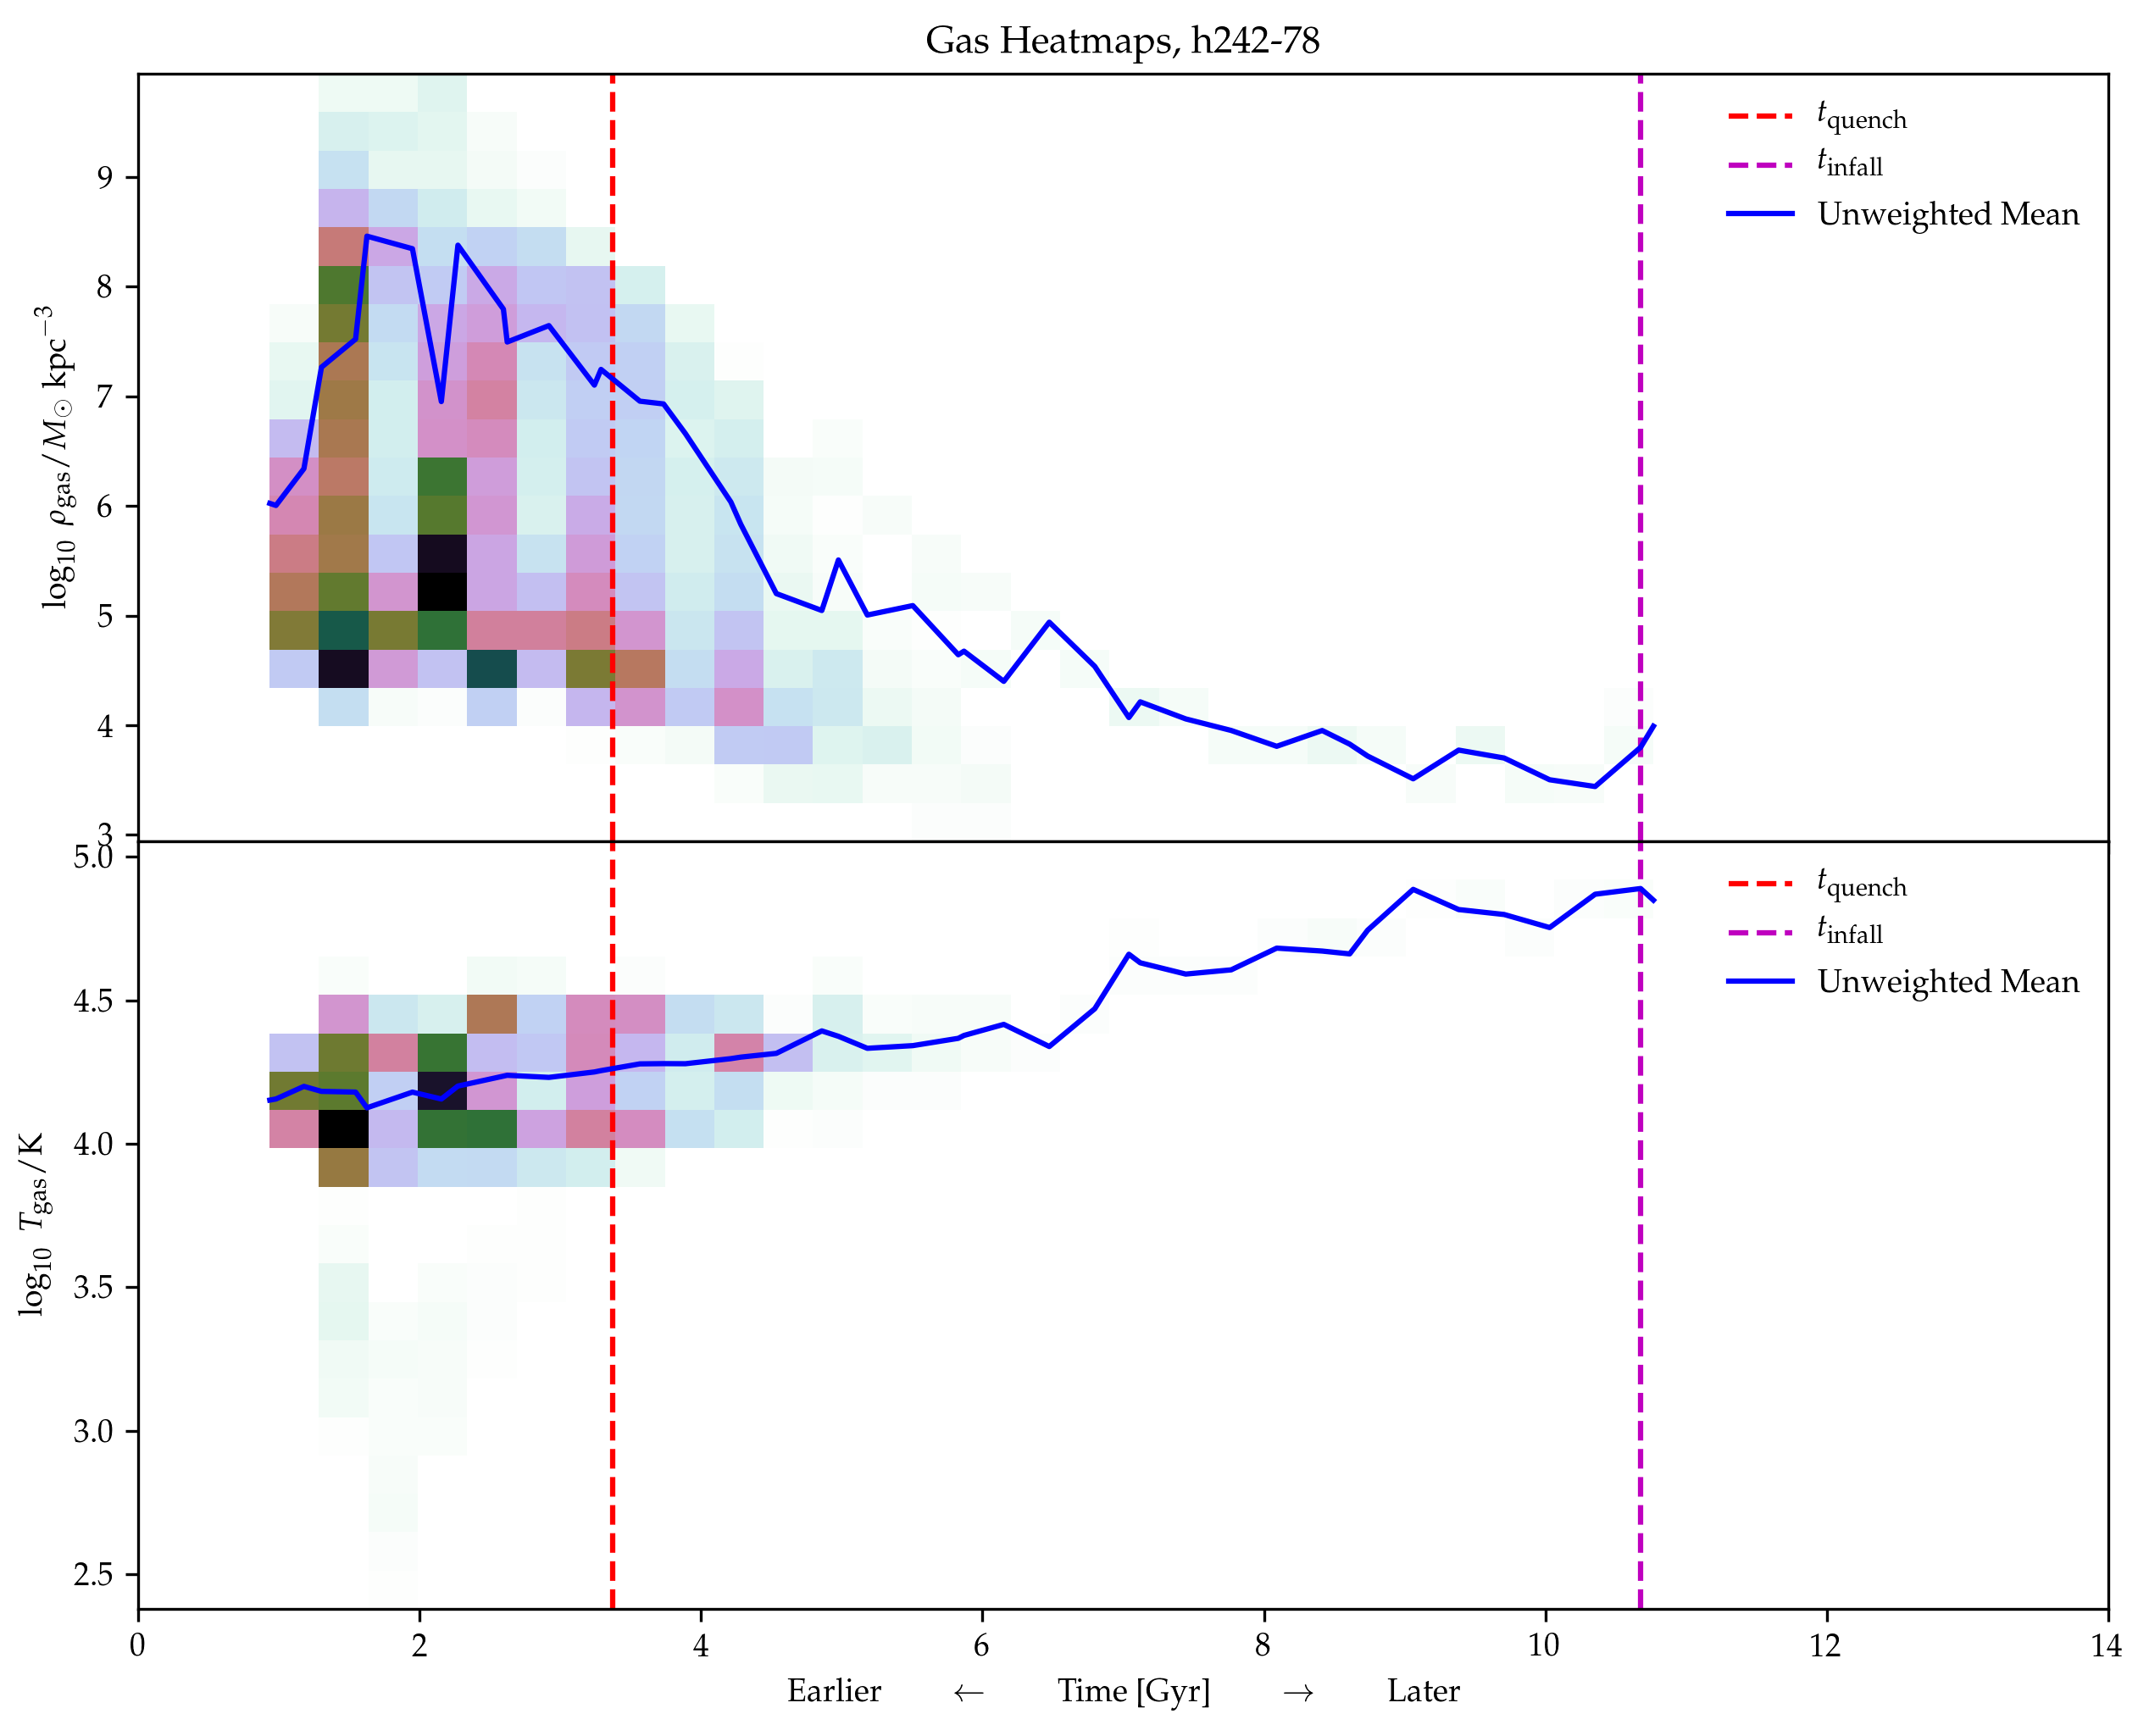

38


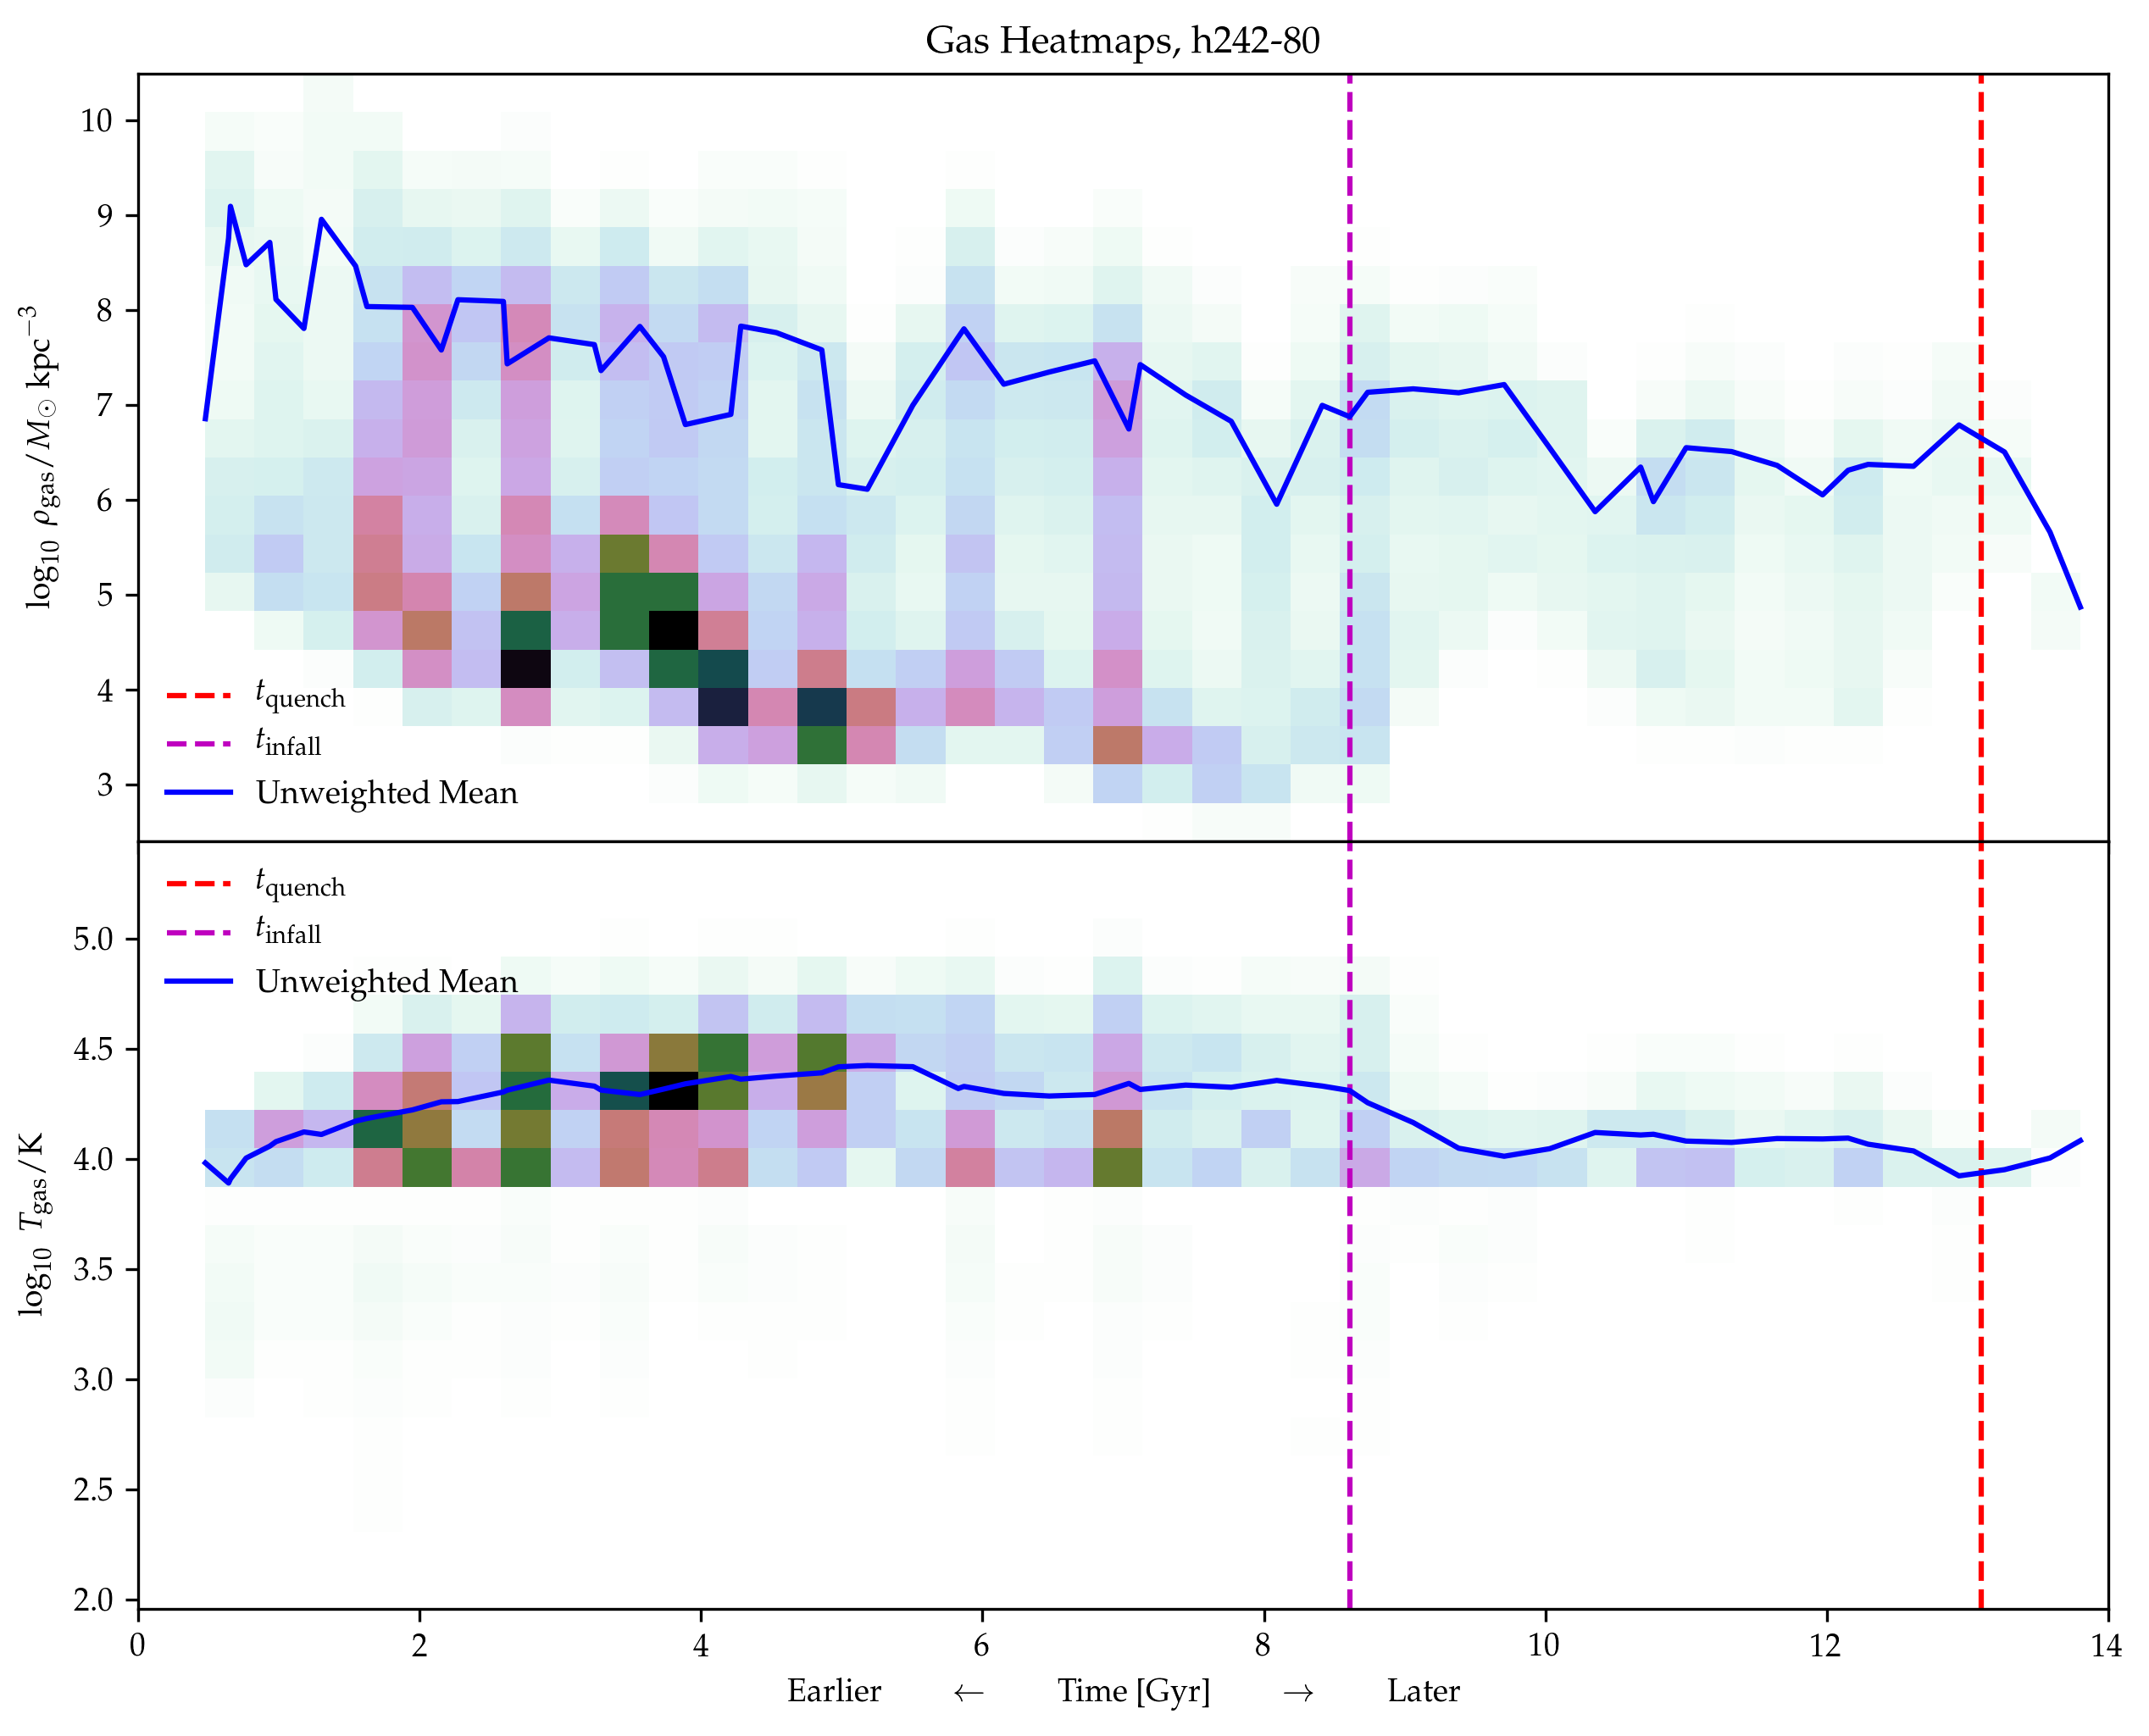

23


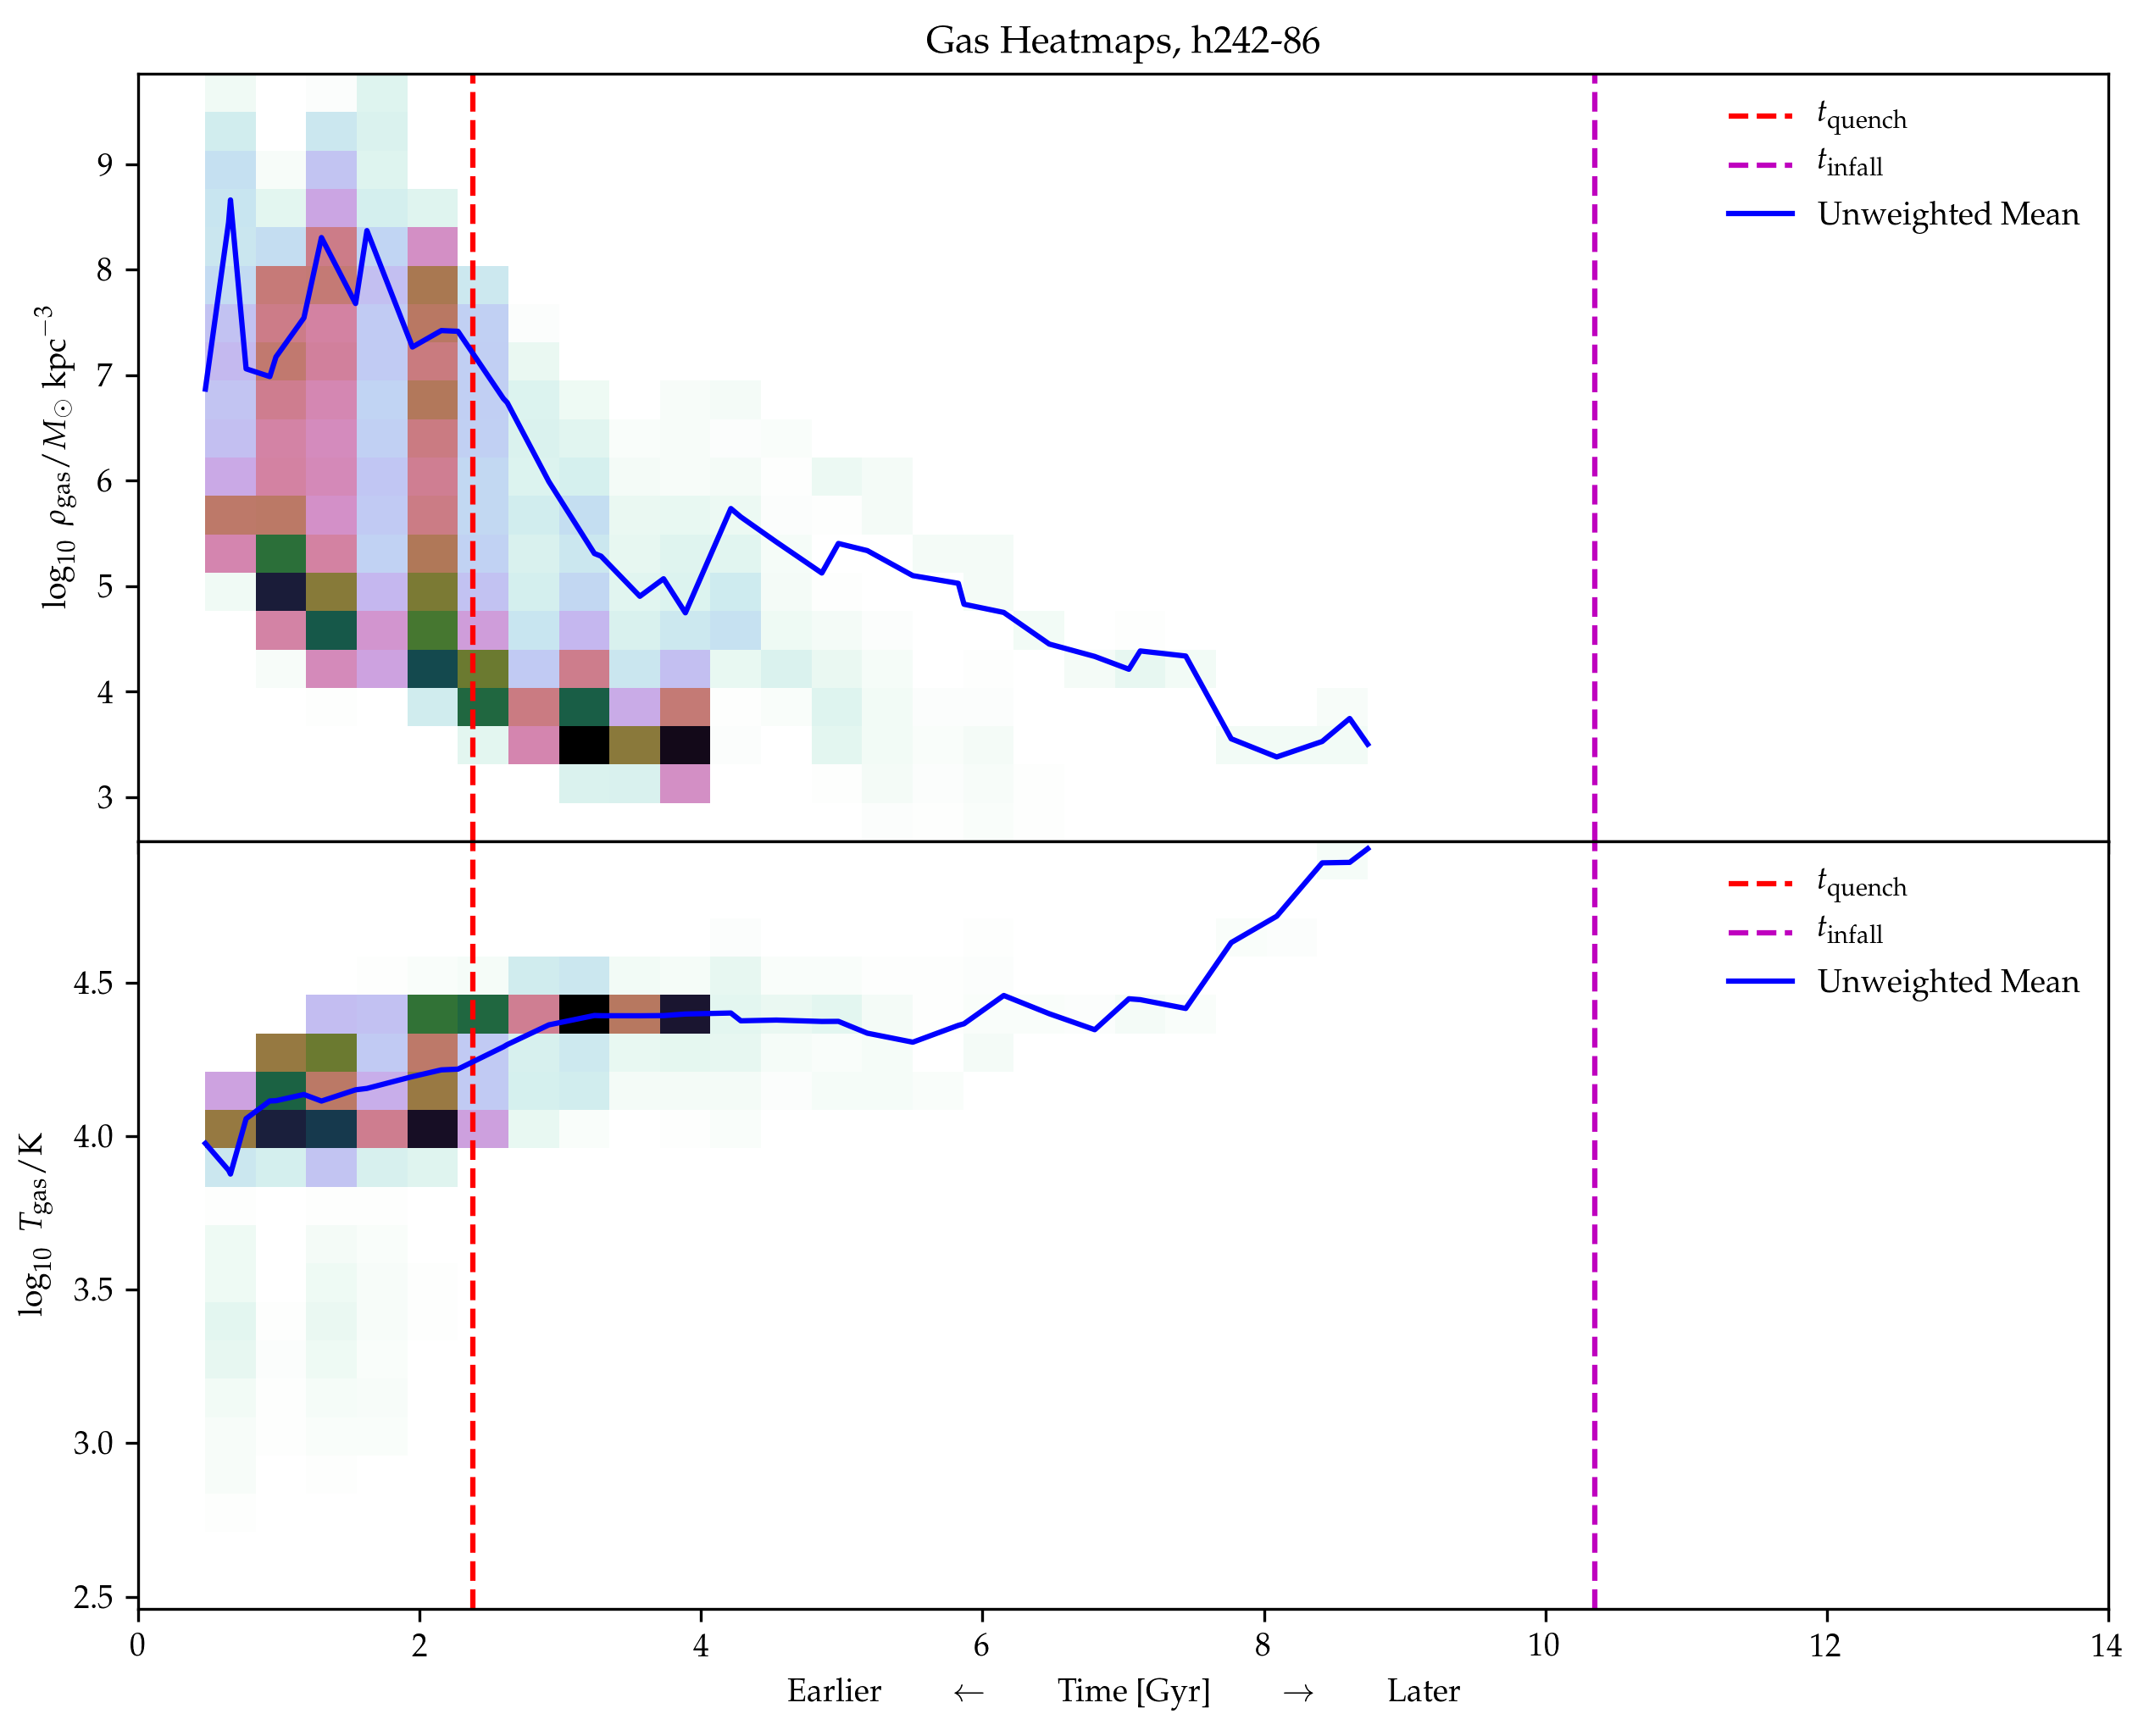

12


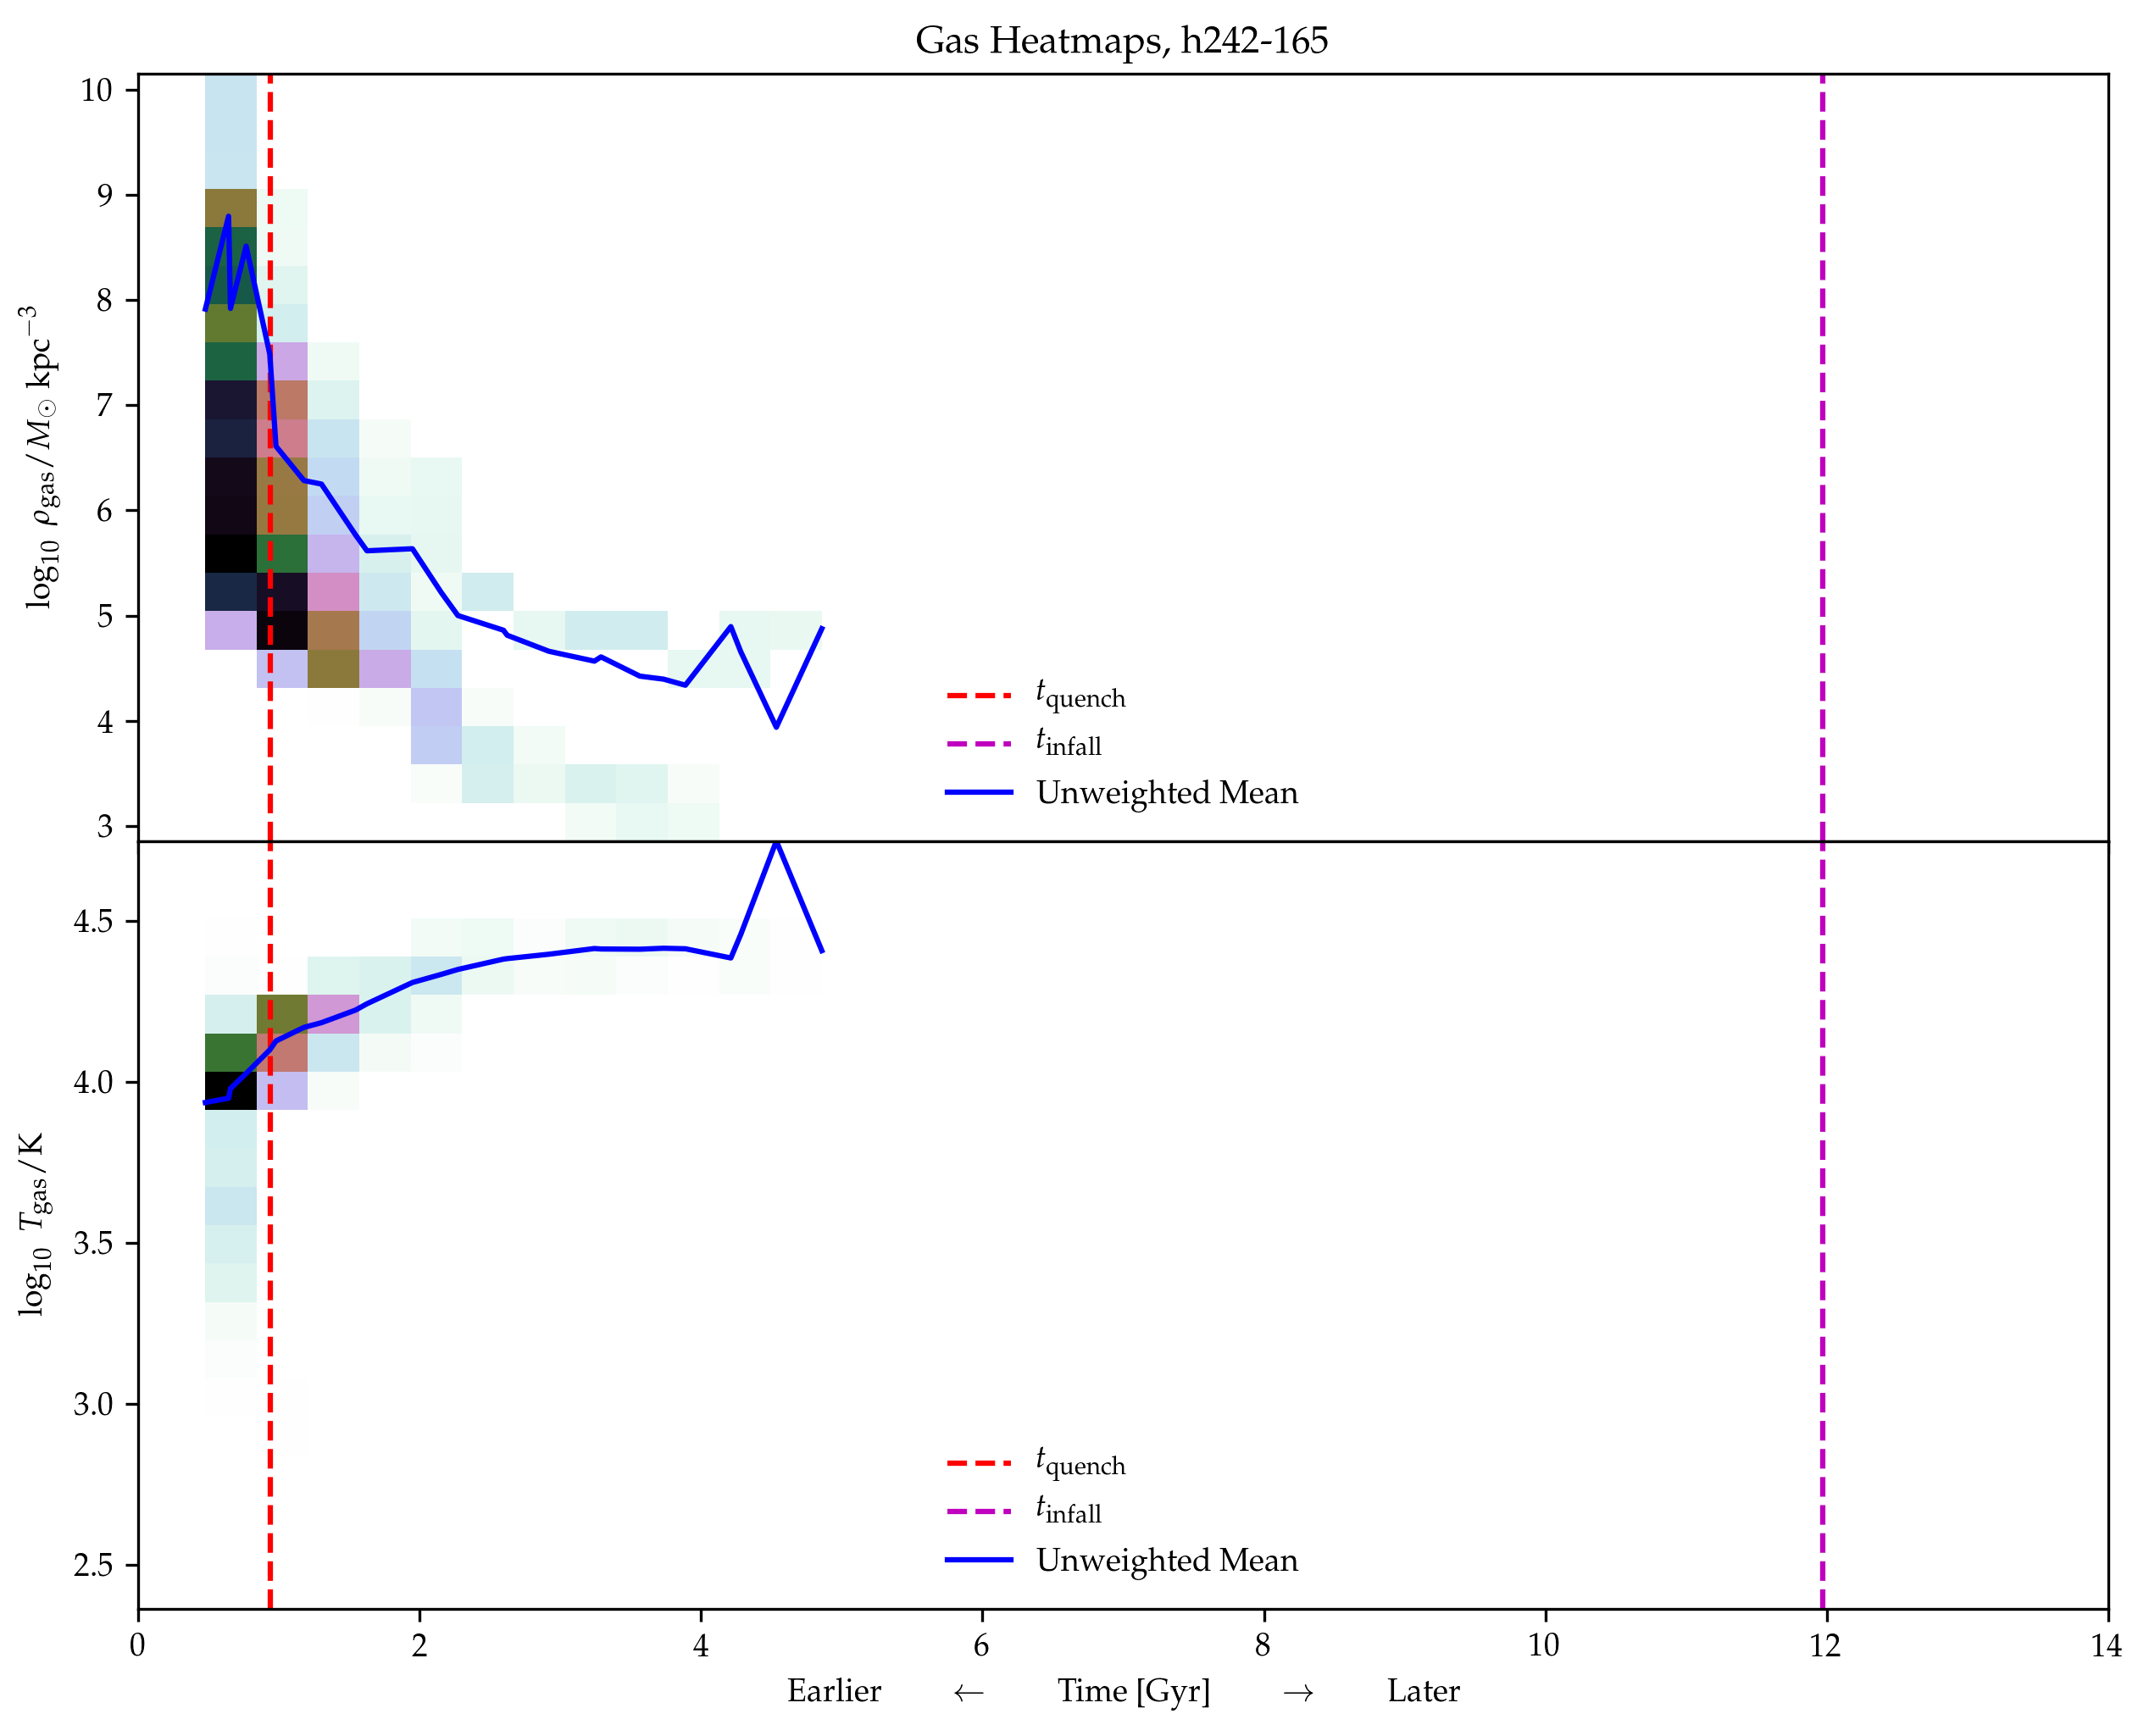

34


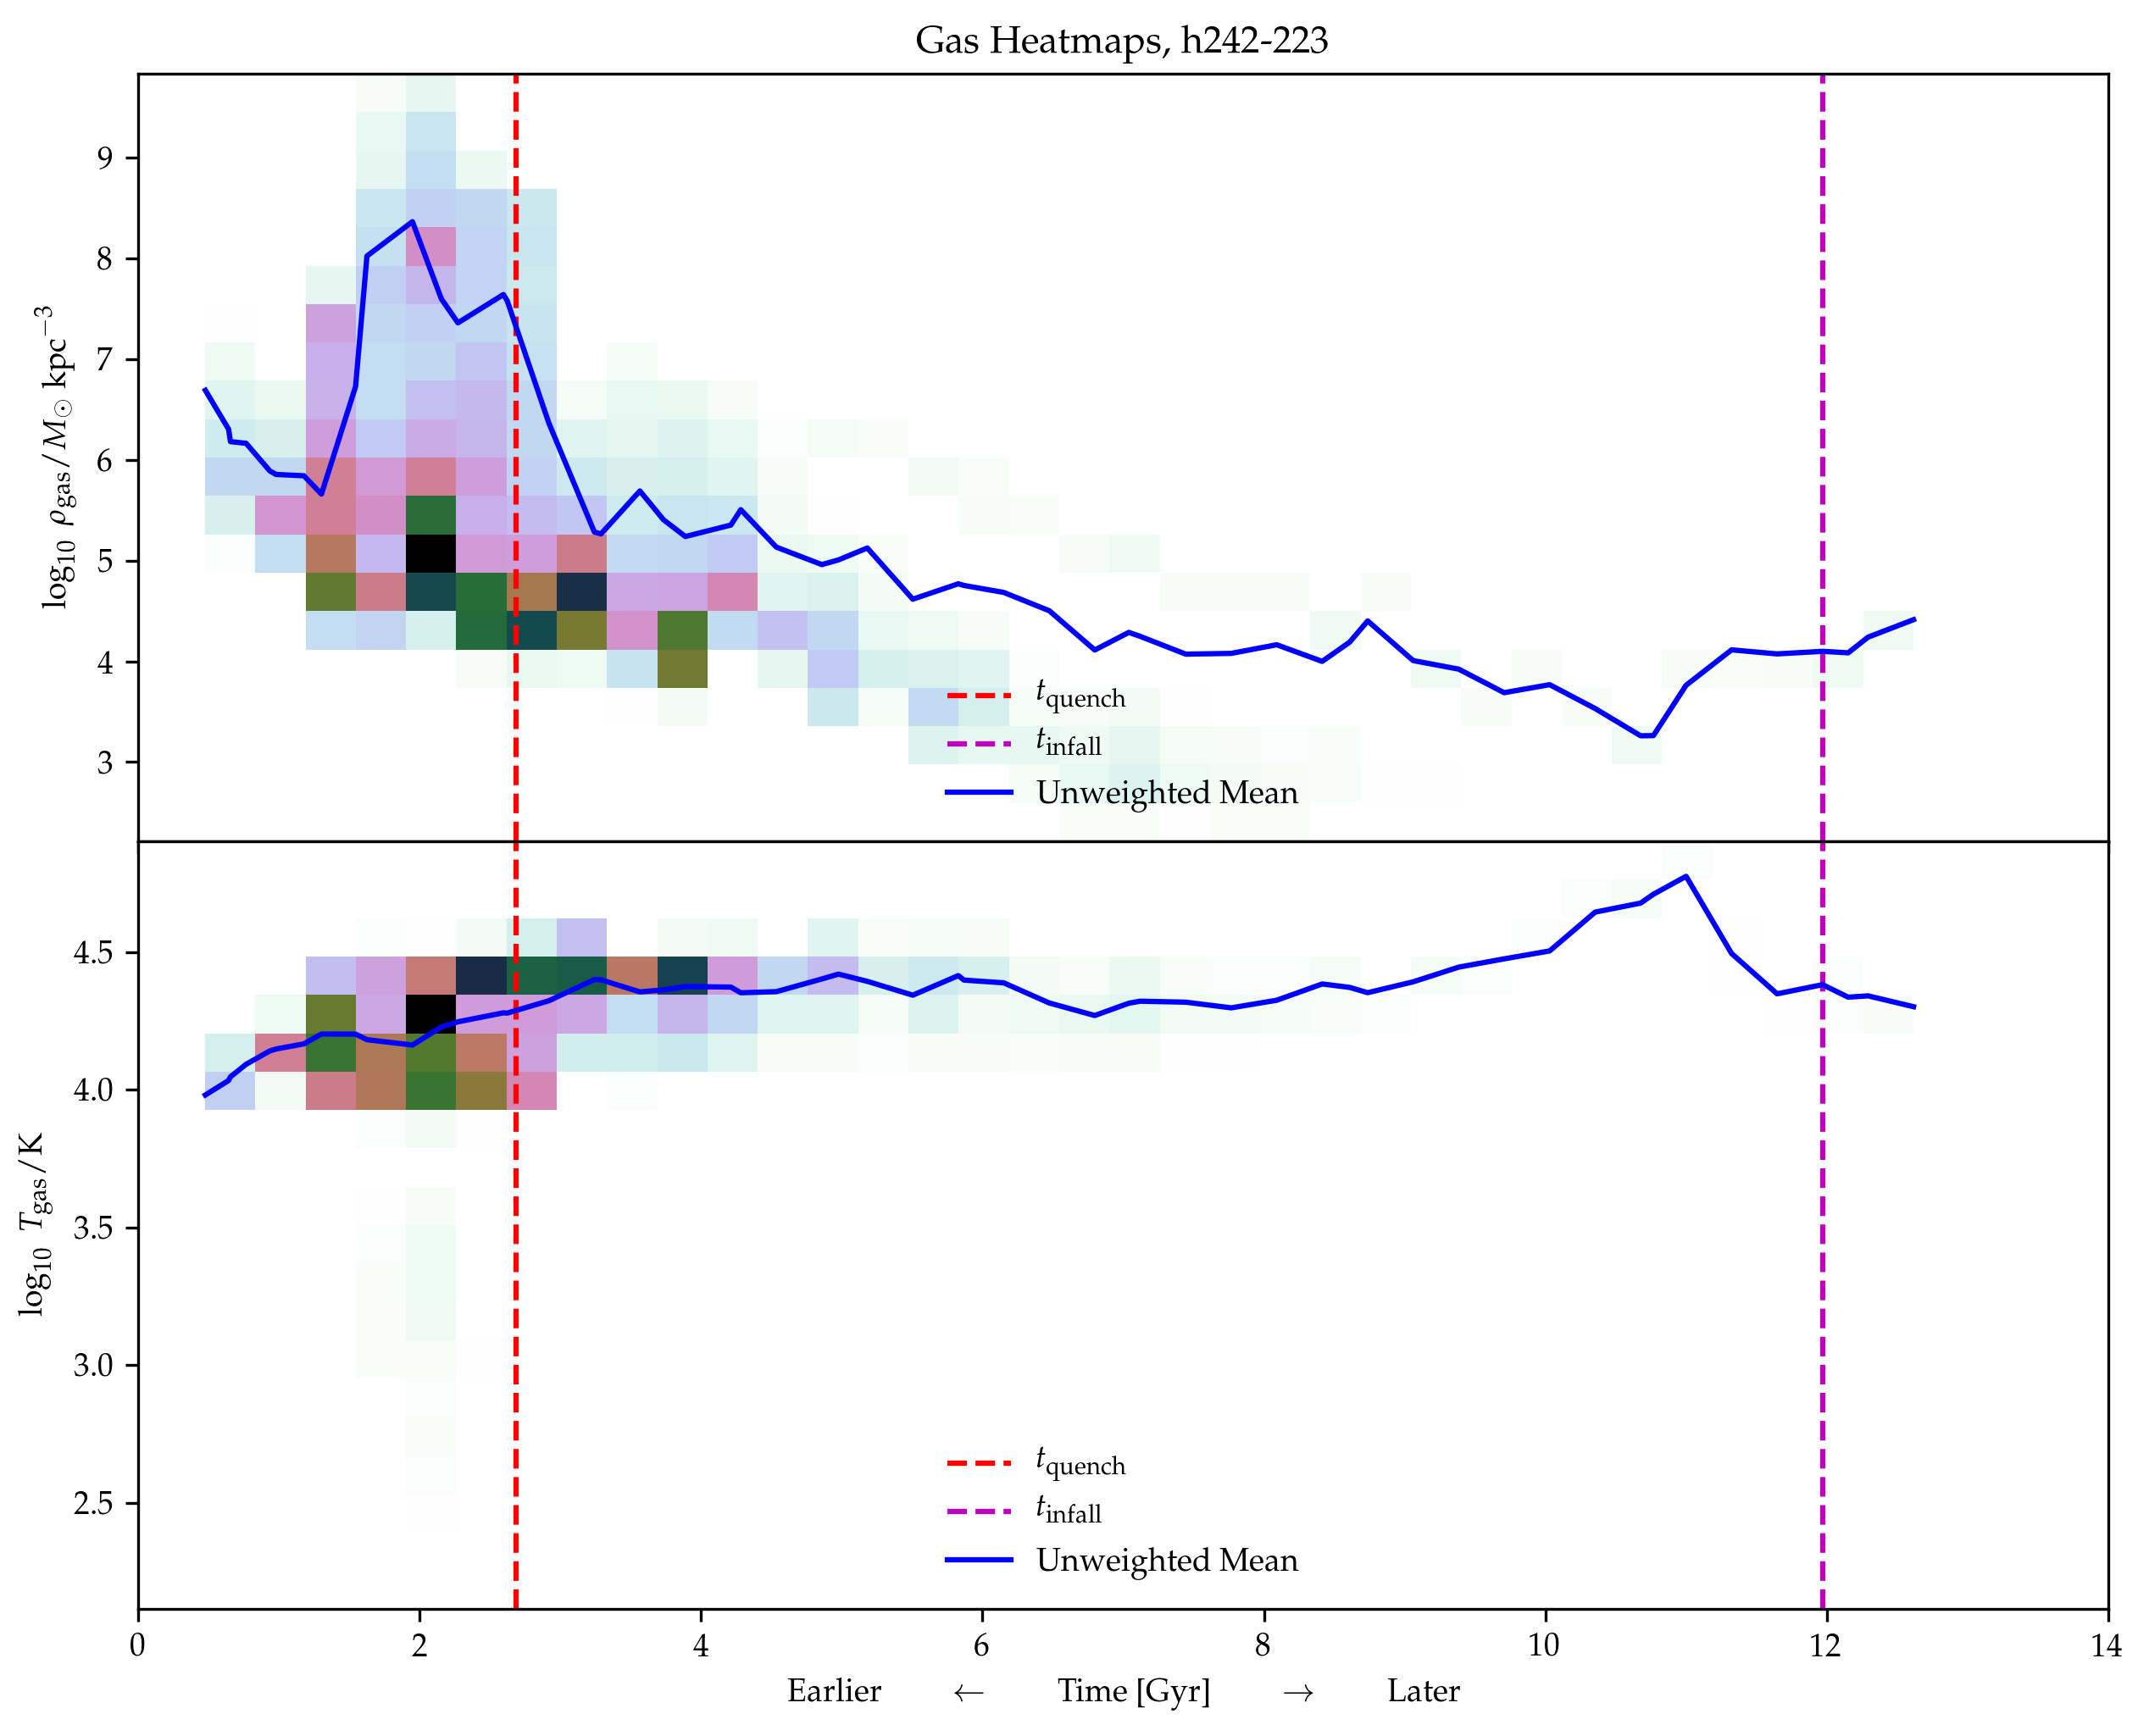

12


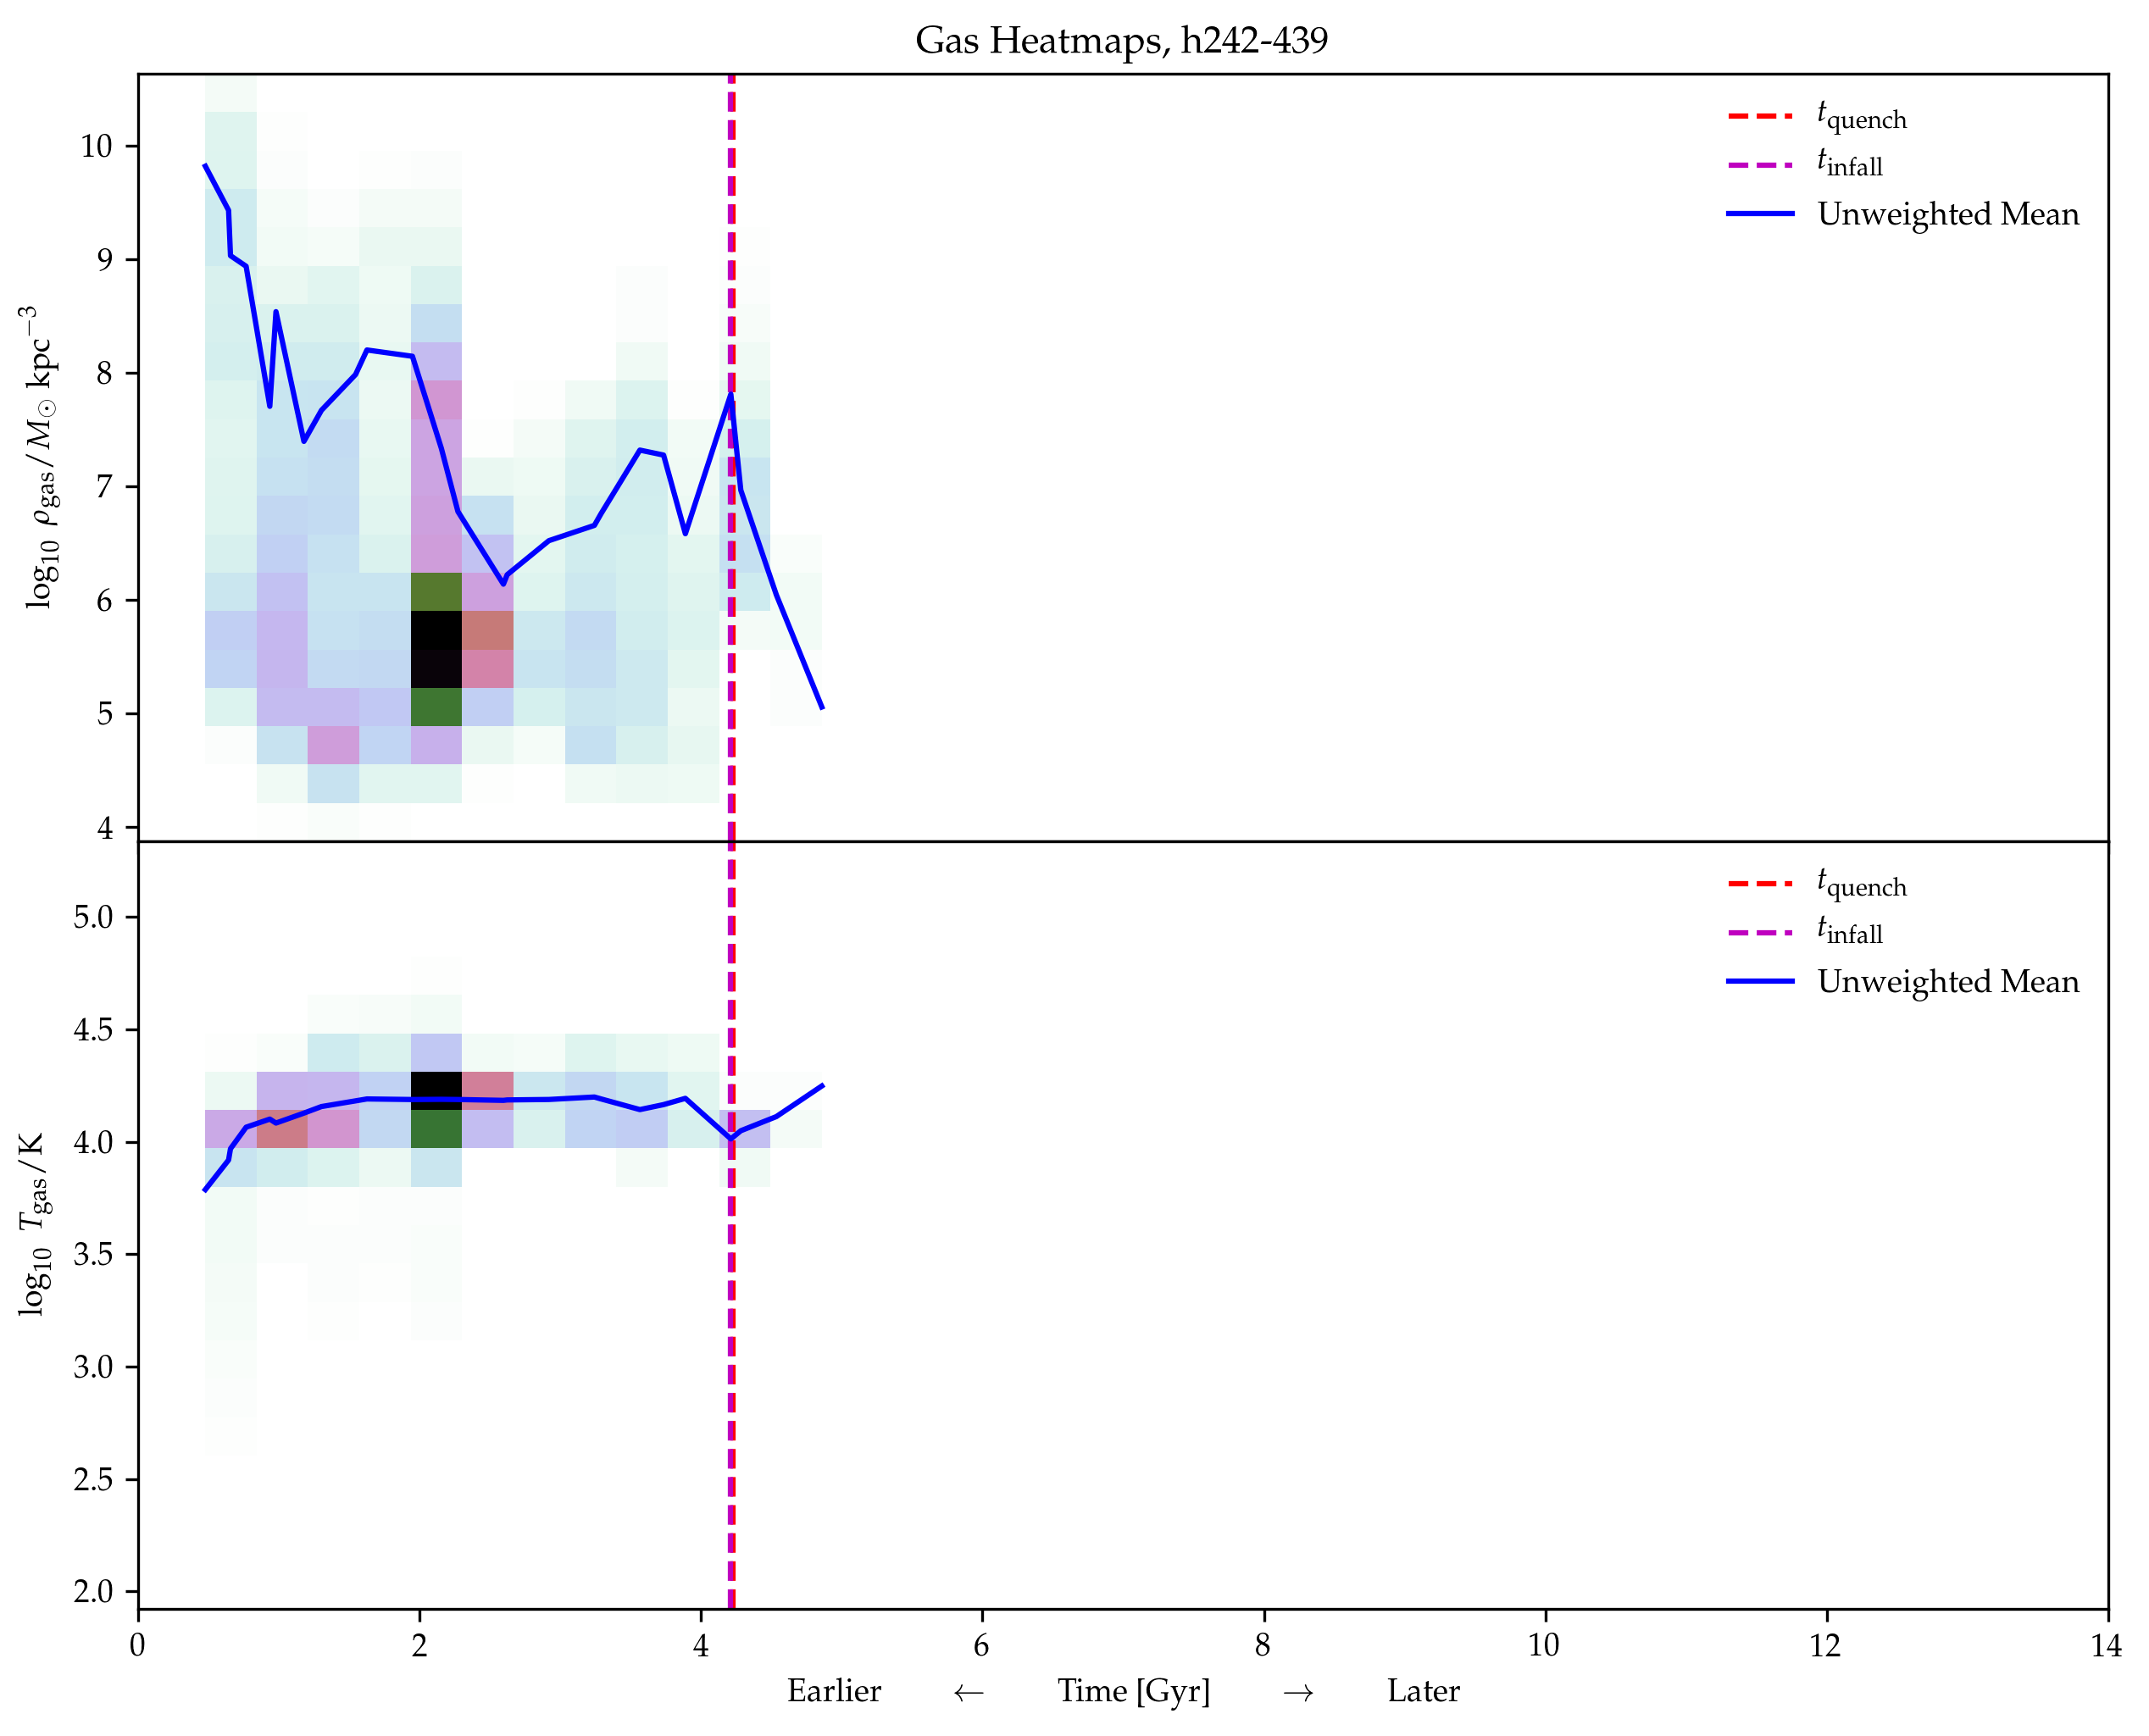

In [317]:
sim = 'h242'
data = read_timesteps(sim)
print(list(np.unique(data.z0haloid)))

for haloid in [10, 12, 24, 30, 34, 40, 41, 44, 48, 49, 71, 78, 80, 86, 165, 223, 439]:
    d = data[data.z0haloid==haloid]
    
    # determine t_quench
    timescales = read_timescales()
    timescales = timescales[(timescales.sim == sim) & (timescales.haloid==haloid)]
    tquench = timescales.tquench.tolist()[0]
    tquench = 13.800797497330507 - tquench
    
    tinfall = timescales.tinfall.tolist()[0]
    tinfall = 13.800797497330507 - tinfall
    
    # get distributions of gas density
    times, rhos = np.array([]), np.array([])
    for time, rho in zip(d.time, d.gas_rho):
        if len(rho) != 0:
            rhos = np.append(rhos, rho)
            times = np.append(times, [time]*len(rho))

    rho_mean = [np.log10(np.mean(rho)) for rho in d.gas_rho]
    
    xbins = int((np.max(times) - np.min(times))/14 * 40)
    print(xbins)
    
    rhos_heatmap, xedges, yedges = np.histogram2d(times, np.log10(rhos), bins=(xbins,20))
    rhos_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # get distributions of gas temperature
    times, temps = np.array([]), np.array([])
    for time, temp in zip(d.time, d.gas_temp):
        if len(temp) != 0:
            temps = np.append(temps, temp)
            times = np.append(times, [time]*len(temp))

    temp_mean = [np.log10(np.mean(temp)) for temp in d.gas_temp]

    temps_heatmap, xedges, yedges = np.histogram2d(times, np.log10(temps), bins=(xbins,20))
    temps_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig, ax = plt.subplots(2,1,dpi=300,figsize=(10,8),sharex=True)
    
    ax[0].set_title(f'Gas Heatmaps, {sim}-{haloid}')
    
    if not np.isnan(tquench):
        ax[0].plot([tquench,tquench], [np.min(np.log10(rhos)), np.max(np.log10(rhos))], 'r--', label='$t_{\mathrm{quench}}$')
    if not np.isnan(tinfall):
        ax[0].plot([tinfall,tinfall], [np.min(np.log10(rhos)), np.max(np.log10(rhos))], 'm--', label='$t_{\mathrm{infall}}$')
        
    ax[0].imshow(rhos_heatmap.T, extent=rhos_extent, origin='lower', cmap='cubehelix_r', aspect='auto')
    ax[0].set_ylabel(r'$\log_{10}~\rho_{\mathrm{gas}} / M_{\odot}~\mathrm{kpc}^{-3}$')
    ax[0].set_xlim(0, 14)
    ax[0].plot(d.time, rho_mean, 'b-', label='Unweighted Mean')
#     ax[0].plot(d.time, rho_mean_unw, 'b--', linewidth=0.5, label='Unweighted Mean')
    ax[0].legend(frameon=False)
    
    if not np.isnan(tquench):
        ax[1].plot([tquench,tquench], [np.min(np.log10(temps)),np.max(np.log10(temps))], 'r--', label='$t_{\mathrm{quench}}$')
    if not np.isnan(tinfall):
        ax[1].plot([tinfall,tinfall], [np.min(np.log10(temps)),np.max(np.log10(temps))], 'm--', label='$t_{\mathrm{infall}}$')
        
    ax[1].imshow(temps_heatmap.T, extent=temps_extent, origin='lower', cmap='cubehelix_r', aspect='auto')
    ax[1].set_xlabel(r'Earlier $\qquad\leftarrow\qquad$ Time [Gyr] $\qquad\rightarrow\qquad$ Later')
    ax[1].set_ylabel(r'$\log_{10}~T_{\mathrm{gas}} / \mathrm{K}$')
    ax[1].set_xlim(0,14)
    ax[1].plot(d.time, temp_mean, 'b-', label='Unweighted Mean')
#     ax[1].plot(d.time, temp_mean_unw, 'b--', linewidth=0.5, label='Unweighted Mean')
    ax[1].legend(frameon=False)
    
    plt.subplots_adjust(hspace=0.)
    plt.show()